# Fetch data into csv file

In [ ]:
#!/usr/bin/env python3
# -*- coding: utf-8 -*-

"""
Quick EDA pipeline for the Census-like dataset:
1) Load column names from `census-bureau.columns`
2) Load data rows from `census-bureau.data`
3) Basic cleaning (trim spaces, unify NA, dtypes, dedup)
4) Simple visualizations (class balance, numeric histograms, top-categories)
5) Persist a cleaned CSV for downstream ML
"""

import os
import sys
from typing import List
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

COLUMNS_FILE = "census-bureau.columns"
DATA_FILE = "census-bureau.data"
CLEANED_CSV = "census_clean.csv"
FIG_DIR = "figs"

def read_columns(path: str) -> List[str]:
    """Read column names from a `.columns` file.
    Robust to either:
      - one-name-per-line format, or
      - one comma-separated line format.
    """
    with open(path, "r", encoding="utf-8") as f:
        raw = f.read().strip()

    # If file has multiple lines, assume one column per line
    if "\n" in raw and "," not in raw:
        cols = [line.strip() for line in raw.splitlines() if line.strip()]
    else:
        # Otherwise split by comma (and also split lines then commas to be safe)
        parts = []
        for line in raw.splitlines():
            parts.extend([p.strip() for p in line.split(",") if p.strip()])
        cols = parts

    # De-duplicate while preserving order
    seen = set()
    ordered = []
    for c in cols:
        if c not in seen:
            ordered.append(c)
            seen.add(c)
    return ordered


def load_data(data_path: str, columns: List[str]) -> pd.DataFrame:
    """Load the data file using provided column names.
    Treat '?' as missing and strip whitespace around string fields.
    """
    df = pd.read_csv(
        data_path,
        header=None,          # there is no header row in the raw data
        names=columns,
        sep=",",
        na_values=["?", " ?"],  # common patterns in census-like datasets
        engine="python"
    )

    # Strip surrounding spaces from object columns (common in this dataset)
    obj_cols = df.select_dtypes(include=["object"]).columns
    for c in obj_cols:
        df[c] = df[c].astype(str).str.strip().replace({"?": np.nan})

    return df


def basic_cleaning(df: pd.DataFrame) -> pd.DataFrame:
    """Apply lightweight cleaning:
    - Standardize column names
    - Drop exact duplicates
    - Coerce obvious numeric-like columns (if any were read as object)
    """
    # Standardize column names: lower snake_case
    df = df.rename(columns=lambda x: x.strip().lower().replace(" ", "_"))

    # Drop exact duplicates
    before = len(df)
    df = df.drop_duplicates()
    after = len(df)
    print(f"[INFO] Dropped {before - after} duplicate rows.")

    # Try to coerce numeric-looking columns that are currently object
    for c in df.columns:
        if df[c].dtype == "object":
            # If majority of non-null values look numeric, try to convert
            sample = df[c].dropna().head(1000)
            if len(sample) > 0:
                numeric_like = sample.str.fullmatch(r"[-+]?\d+(\.\d+)?").mean()
                if numeric_like > 0.8:  # heuristic threshold
                    df[c] = pd.to_numeric(df[c], errors="coerce")

    return df


def detect_target_column(df: pd.DataFrame) -> str:
    """Heuristically detect the income target column (often the last column).
    Returns the column name; falls back to the last column.
    """
    candidates = [c for c in df.columns if "income" in c or "class" in c or "label" in c]
    if candidates:
        return candidates[-1]
    return df.columns[-1]


def encode_binary_target(df: pd.DataFrame, target_col: str) -> pd.DataFrame:
    """Map income classes like '<=50K' and '>50K' to 0/1 if applicable."""
    if df[target_col].dtype == "object":
        # Normalize to remove spaces
        s = df[target_col].str.strip().str.lower()
        unique_vals = s.dropna().unique()
        # Common patterns in census income: '<=50k', '>50k'
        mapping = {
            "<=50k": 0, "≤50k": 0, "less_than_50k": 0, "lt50k": 0,
            ">50k": 1, "≥50k": 1, "gte50k": 1
        }
        # Try direct mapping
        if set(unique_vals).issubset(set(mapping.keys())):
            df[target_col] = s.map(mapping).astype("Int64")
        else:
            # Try a fuzzy mapping if it contains '50k'
            if any("50k" in v for v in unique_vals):
                df[target_col] = s.apply(
                    lambda x: 0 if "≤50k" in x or "<=50k" in x or "lt" in x or "less" in x
                    else (1 if ">50k" in x or "≥50k" in x or "gte" in x else pd.NA)
                ).astype("Int64")
    return df


def quick_overview(df: pd.DataFrame, target_col: str):
    """Print basic dataset info and class balance."""
    print("\n[INFO] DataFrame info:")
    print(df.info())
    print("\n[INFO] Missing values (top 10 columns):")
    print(df.isna().sum().sort_values(ascending=False).head(10))

    if target_col in df.columns:
        print("\n[INFO] Target distribution:")
        print(df[target_col].value_counts(dropna=False))


def ensure_fig_dir():
    """Create figure output directory if not exists."""
    if not os.path.exists(FIG_DIR):
        os.makedirs(FIG_DIR, exist_ok=True)


def plot_class_balance(df: pd.DataFrame, target_col: str):
    """Bar plot for the target distribution (if categorical/binary)."""
    if target_col not in df.columns:
        return
    ensure_fig_dir()
    counts = df[target_col].value_counts(dropna=False).sort_index()
    plt.figure(figsize=(5, 4))
    counts.plot(kind="bar")
    plt.title(f"Target Distribution: {target_col}")
    plt.xlabel("Class")
    plt.ylabel("Count")
    plt.tight_layout()
    out = os.path.join(FIG_DIR, "01_target_distribution.png")
    plt.savefig(out, dpi=160)
    plt.close()
    print(f"[PLOT] Saved {out}")


def plot_numeric_histograms(df: pd.DataFrame, max_plots: int = 8):
    """Histograms for up to `max_plots` numeric columns."""
    num_cols = df.select_dtypes(include=[np.number]).columns.tolist()
    if not num_cols:
        return
    ensure_fig_dir()
    for i, c in enumerate(num_cols[:max_plots], start=1):
        plt.figure(figsize=(5, 4))
        df[c].dropna().hist(bins=40)
        plt.title(f"Histogram: {c}")
        plt.xlabel(c)
        plt.ylabel("Frequency")
        plt.tight_layout()
        out = os.path.join(FIG_DIR, f"02_hist_{i:02d}_{c}.png")
        plt.savefig(out, dpi=160)
        plt.close()
        print(f"[PLOT] Saved {out}")


def plot_top_categories(df: pd.DataFrame, max_cols: int = 6, top_k: int = 8):
    """Bar plots of top-K category frequencies for up to `max_cols` object columns."""
    cat_cols = df.select_dtypes(include=["object"]).columns.tolist()
    if not cat_cols:
        return
    ensure_fig_dir()
    for i, c in enumerate(cat_cols[:max_cols], start=1):
        vc = df[c].value_counts(dropna=False).head(top_k)
        plt.figure(figsize=(6, 4))
        vc.plot(kind="bar")
        plt.title(f"Top-{top_k} Categories: {c}")
        plt.xlabel(c)
        plt.ylabel("Count")
        plt.tight_layout()
        out = os.path.join(FIG_DIR, f"03_cat_{i:02d}_{c}.png")
        plt.savefig(out, dpi=160)
        plt.close()
        print(f"[PLOT] Saved {out}")


def main():
    # Sanity checks
    if not os.path.exists(COLUMNS_FILE) or not os.path.exists(DATA_FILE):
        print(f"[ERROR] Please place `{COLUMNS_FILE}` and `{DATA_FILE}` in the same folder as this script.")
        sys.exit(1)

    # 1) Read schema/columns
    columns = read_columns(COLUMNS_FILE)
    print(f"[INFO] Loaded {len(columns)} columns.")

    # 2) Load raw data with those columns
    df = load_data(DATA_FILE, columns)
    print(f"[INFO] Loaded data shape: {df.shape}")

    # 3) Basic cleaning
    df = basic_cleaning(df)

    # 4) Detect and (optionally) encode target
    target_col = detect_target_column(df)
    print(f"[INFO] Heuristic target column: `{target_col}`")
    df = encode_binary_target(df, target_col)

    # 5) Quick overview + simple plots
    quick_overview(df, target_col)
    plot_class_balance(df, target_col)
    plot_numeric_histograms(df, max_plots=8)
    plot_top_categories(df, max_cols=6, top_k=8)

    # 6) Persist a cleaned CSV for downstream ML
    df.to_csv(CLEANED_CSV, index=False)
    print(f"[SAVE] Cleaned CSV saved to `{CLEANED_CSV}`")

    print("\n[DONE] EDA complete. Check the `figs/` folder for plots.")

if __name__ == "__main__":
    main()


# 1. EDA

In [ ]:
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import OneHotEncoder, StandardScaler
from sklearn.impute import SimpleImputer
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier, HistGradientBoostingClassifier
from sklearn.model_selection import StratifiedKFold, cross_val_score
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from textwrap import fill
from math import sqrt
from sklearn.base import BaseEstimator, TransformerMixin
from lightgbm import LGBMClassifier
from sklearn.model_selection import StratifiedKFold, GridSearchCV, cross_val_predict
from sklearn.metrics import precision_recall_curve, average_precision_score, classification_report, confusion_matrix, roc_auc_score,auc
from imblearn.pipeline import Pipeline as ImbPipeline
from imblearn.over_sampling import SMOTE
from itertools import product
from sklearn.base import clone
from sklearn.pipeline import Pipeline
import xgboost as xgb
import random, itertools
import xgboost as xgb
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.metrics import (
    classification_report, confusion_matrix, roc_auc_score,
    average_precision_score, precision_recall_curve, f1_score
)
import torch
import torch.nn as nn
from torch.utils.data import Dataset, DataLoader, TensorDataset
from scipy import sparse
from catboost import CatBoostClassifier, Pool
import os

In [ ]:


%matplotlib inline

# Optional: wider display for DataFrame heads
pd.set_option("display.max_columns", 100)
pd.set_option("display.width", 160)

# Path to your already-cleaned CSV (change if needed)
CSV_PATH = "census_clean.csv"

# Load the cleaned dataset (no file is written in this notebook)
df = pd.read_csv(CSV_PATH)

print(df.shape)
df.head()

(196294, 42)


,age,class_of_worker,detailed_industry_recode,detailed_occupation_recode,education,wage_per_hour,enroll_in_edu_inst_last_wk,marital_stat,major_industry_code,major_occupation_code,race,hispanic_origin,sex,member_of_a_labor_union,reason_for_unemployment,full_or_part_time_employment_stat,capital_gains,capital_losses,dividends_from_stocks,tax_filer_stat,region_of_previous_residence,state_of_previous_residence,detailed_household_and_family_stat,detailed_household_summary_in_household,weight,migration_code-change_in_msa,migration_code-change_in_reg,migration_code-move_within_reg,live_in_this_house_1_year_ago,migration_prev_res_in_sunbelt,num_persons_worked_for_employer,family_members_under_18,country_of_birth_father,country_of_birth_mother,country_of_birth_self,citizenship,own_business_or_self_employed,fill_inc_questionnaire_for_veteran's_admin,veterans_benefits,weeks_worked_in_year,year,label
0,73,Not in universe,0,0,High school graduate,0,Not in universe,Widowed,Not in universe or children,Not in universe,White,All other,Female,Not in universe,Not in universe,Not in labor force,0,0,0,Nonfiler,Not in universe,Not in universe,Other Rel 18+ ever marr not in subfamily,Other relative of householder,1700.09,NaN,NaN,NaN,Not in universe under 1 year old,NaN,0,Not in universe,United-States,United-States,United-States,Native- Born in the United States,0,Not in universe,2,0,95,- 50000.
1,58,Self-employed-not incorporated,4,34,Some college but no degree,0,Not in universe,Divorced,Construction,Precision production craft & repair,White,All other,Male,Not in universe,Not in universe,Children or Armed Forces,0,0,0,Head of household,South,Arkansas,Householder,Householder,1053.55,MSA to MSA,Same county,Same county,No,Yes,1,Not in universe,United-States,United-States,United-States,Native- Born in the United States,0,Not in universe,2,52,94,- 50000.
2,18,Not in universe,0,0,10th grade,0,High school,Never married,Not in universe or children,Not in universe,Asian or Pacific Islander,All other,Female,Not in universe,Not in universe,Not in labor force,0,0,0,Nonfiler,Not in universe,Not in universe,Child 18+ never marr Not in a subfamily,Child 18 or older,991.95,NaN,NaN,NaN,Not in universe under 1 year old,NaN,0,Not in universe,Vietnam,Vietnam,Vietnam,Foreign born- Not a citizen of U S,0,Not in universe,2,0,95,- 50000.
3,9,Not in universe,0,0,Children,0,Not in universe,Never married,Not in universe or children,Not in universe,White,All other,Female,Not in universe,Not in universe,Children or Armed Forces,0,0,0,Nonfiler,Not in universe,Not in universe,Child <18 never marr not in subfamily,Child under 18 never married,1758.14,Nonmover,Nonmover,Nonmover,Yes,Not in universe,0,Both parents present,United-States,United-States,United-States,Native- Born in the United States,0,Not in universe,0,0,94,- 50000.
4,10,Not in universe,0,0,Children,0,Not in universe,Never married,Not in universe or children,Not in universe,White,All other,Female,Not in universe,Not in universe,Children or Armed Forces,0,0,0,Nonfiler,Not in universe,Not in universe,Child <18 never marr not in subfamily,Child under 18 never married,1069.16,Nonmover,Nonmover,Nonmover,Yes,Not in universe,0,Both parents present,United-States,United-States,United-States,Native- Born in the United States,0,Not in universe,0,0,94,- 50000.


In [11]:
df.columns


Index(['age', 'class_of_worker', 'detailed_industry_recode', 'detailed_occupation_recode', 'education', 'wage_per_hour', 'enroll_in_edu_inst_last_wk',
       'marital_stat', 'major_industry_code', 'major_occupation_code', 'race', 'hispanic_origin', 'sex', 'member_of_a_labor_union', 'reason_for_unemployment',
       'full_or_part_time_employment_stat', 'capital_gains', 'capital_losses', 'dividends_from_stocks', 'tax_filer_stat', 'region_of_previous_residence',
       'state_of_previous_residence', 'detailed_household_and_family_stat', 'detailed_household_summary_in_household', 'weight',
       'migration_code-change_in_msa', 'migration_code-change_in_reg', 'migration_code-move_within_reg', 'live_in_this_house_1_year_ago',
       'migration_prev_res_in_sunbelt', 'num_persons_worked_for_employer', 'family_members_under_18', 'country_of_birth_father', 'country_of_birth_mother',
       'country_of_birth_self', 'citizenship', 'own_business_or_self_employed', 'fill_inc_questionnaire_for_veter

In [12]:
df.describe()

,age,detailed_industry_recode,detailed_occupation_recode,wage_per_hour,capital_gains,capital_losses,dividends_from_stocks,weight,num_persons_worked_for_employer,own_business_or_self_employed,veterans_benefits,weeks_worked_in_year,year
count,196294.000000,196294.000000,196294.000000,196294.000000,196294.000000,196294.000000,196294.000000,196294.000000,196294.000000,196294.000000,196294.000000,196294.000000,196294.000000
mean,34.929468,15.603187,11.490468,56.336505,441.870037,37.927593,200.722386,1743.267584,1.988105,0.178304,1.538183,23.553889,94.499328
std,22.210001,18.106401,14.498128,277.054333,4735.677027,274.081174,2000.130616,996.945985,2.371018,0.557739,0.836813,24.428588,0.500001
min,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,37.870000,0.000000,0.000000,0.000000,0.000000,94.000000
25%,16.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,1061.530000,0.000000,0.000000,2.000000,0.000000,94.000000
50%,34.000000,1.000000,2.000000,0.000000,0.000000,0.000000,0.000000,1620.175000,1.000000,0.000000,2.000000,12.000000,94.000000
75%,50.000000,33.000000,26.000000,0.000000,0.000000,0.000000,0.000000,2194.060000,4.000000,0.000000,2.000000,52.000000,95.000000
max,90.000000,51.000000,46.000000,9999.000000,99999.000000,4608.000000,99999.000000,18656.300000,6.000000,2.000000,2.000000,52.000000,95.000000


In [13]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 196294 entries, 0 to 196293
Data columns (total 42 columns):
 #   Column                                      Non-Null Count   Dtype  
---  ------                                      --------------   -----  
 0   age                                         196294 non-null  int64  
 1   class_of_worker                             196294 non-null  object 
 2   detailed_industry_recode                    196294 non-null  int64  
 3   detailed_occupation_recode                  196294 non-null  int64  
 4   education                                   196294 non-null  object 
 5   wage_per_hour                               196294 non-null  int64  
 6   enroll_in_edu_inst_last_wk                  196294 non-null  object 
 7   marital_stat                                196294 non-null  object 
 8   major_industry_code                         196294 non-null  object 
 9   major_occupation_code                       196294 non-null  object 
 

In [15]:
df.isna().sum().sort_values(ascending=False)

migration_code-change_in_msa                  98015
migration_code-change_in_reg                  98015
migration_code-move_within_reg                98015
migration_prev_res_in_sunbelt                 98015
country_of_birth_father                        6703
country_of_birth_mother                        6107
country_of_birth_self                          3389
hispanic_origin                                 870
state_of_previous_residence                     707
citizenship                                       0
detailed_household_and_family_stat                0
own_business_or_self_employed                     0
family_members_under_18                           0
num_persons_worked_for_employer                   0
fill_inc_questionnaire_for_veteran's_admin        0
live_in_this_house_1_year_ago                     0
veterans_benefits                                 0
weeks_worked_in_year                              0
year                                              0
weight      

In [4]:
# Heuristically detect the target column (common names or fallback to last column).
def detect_target_column(df: pd.DataFrame) -> str:
    candidates = [c for c in df.columns if any(k in c.lower() for k in ["income", "class", "label", "target"])]
    return candidates[-1] if candidates else df.columns[-1]

TARGET_COL = detect_target_column(df)
print("Heuristic target column:", TARGET_COL)

# If the target is text like '<=50K'/' >50K', convert to numeric 0/1 for convenience (won't overwrite your CSV).
def try_encode_binary_target(series: pd.Series) -> pd.Series:
    if series.dtype == "object":
        s = series.astype(str).str.strip().str.lower()
        mapping = {"<=50k": 0, "≤50k": 0, ">50k": 1, "≥50k": 1}
        # Only map if values look like the expected labels
        uniq = set(s.dropna().unique())
        if uniq.issubset(set(mapping.keys())):
            return s.map(mapping)
    return series

df[TARGET_COL] = try_encode_binary_target(df[TARGET_COL])
df[TARGET_COL].value_counts(dropna=False)

Heuristic target column: label


label
- 50000.    183912
50000+.      12382
Name: count, dtype: int64

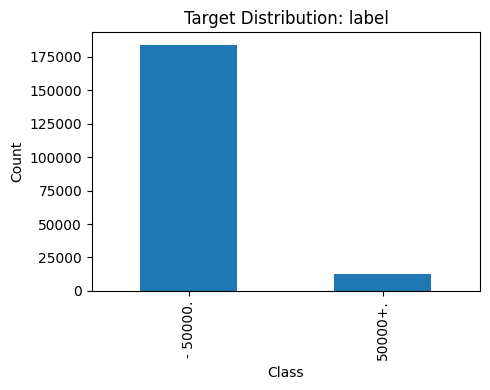

In [5]:
# Plot the class distribution inline.
counts = df[TARGET_COL].value_counts(dropna=False).sort_index()
plt.figure(figsize=(5, 4))
counts.plot(kind="bar")
plt.title(f"Target Distribution: {TARGET_COL}")
plt.xlabel("Class")
plt.ylabel("Count")
plt.tight_layout()
plt.show()

From above picture, we can know it's a unbalanced dataset.

[INFO] plotting 41 features (max_features=41).


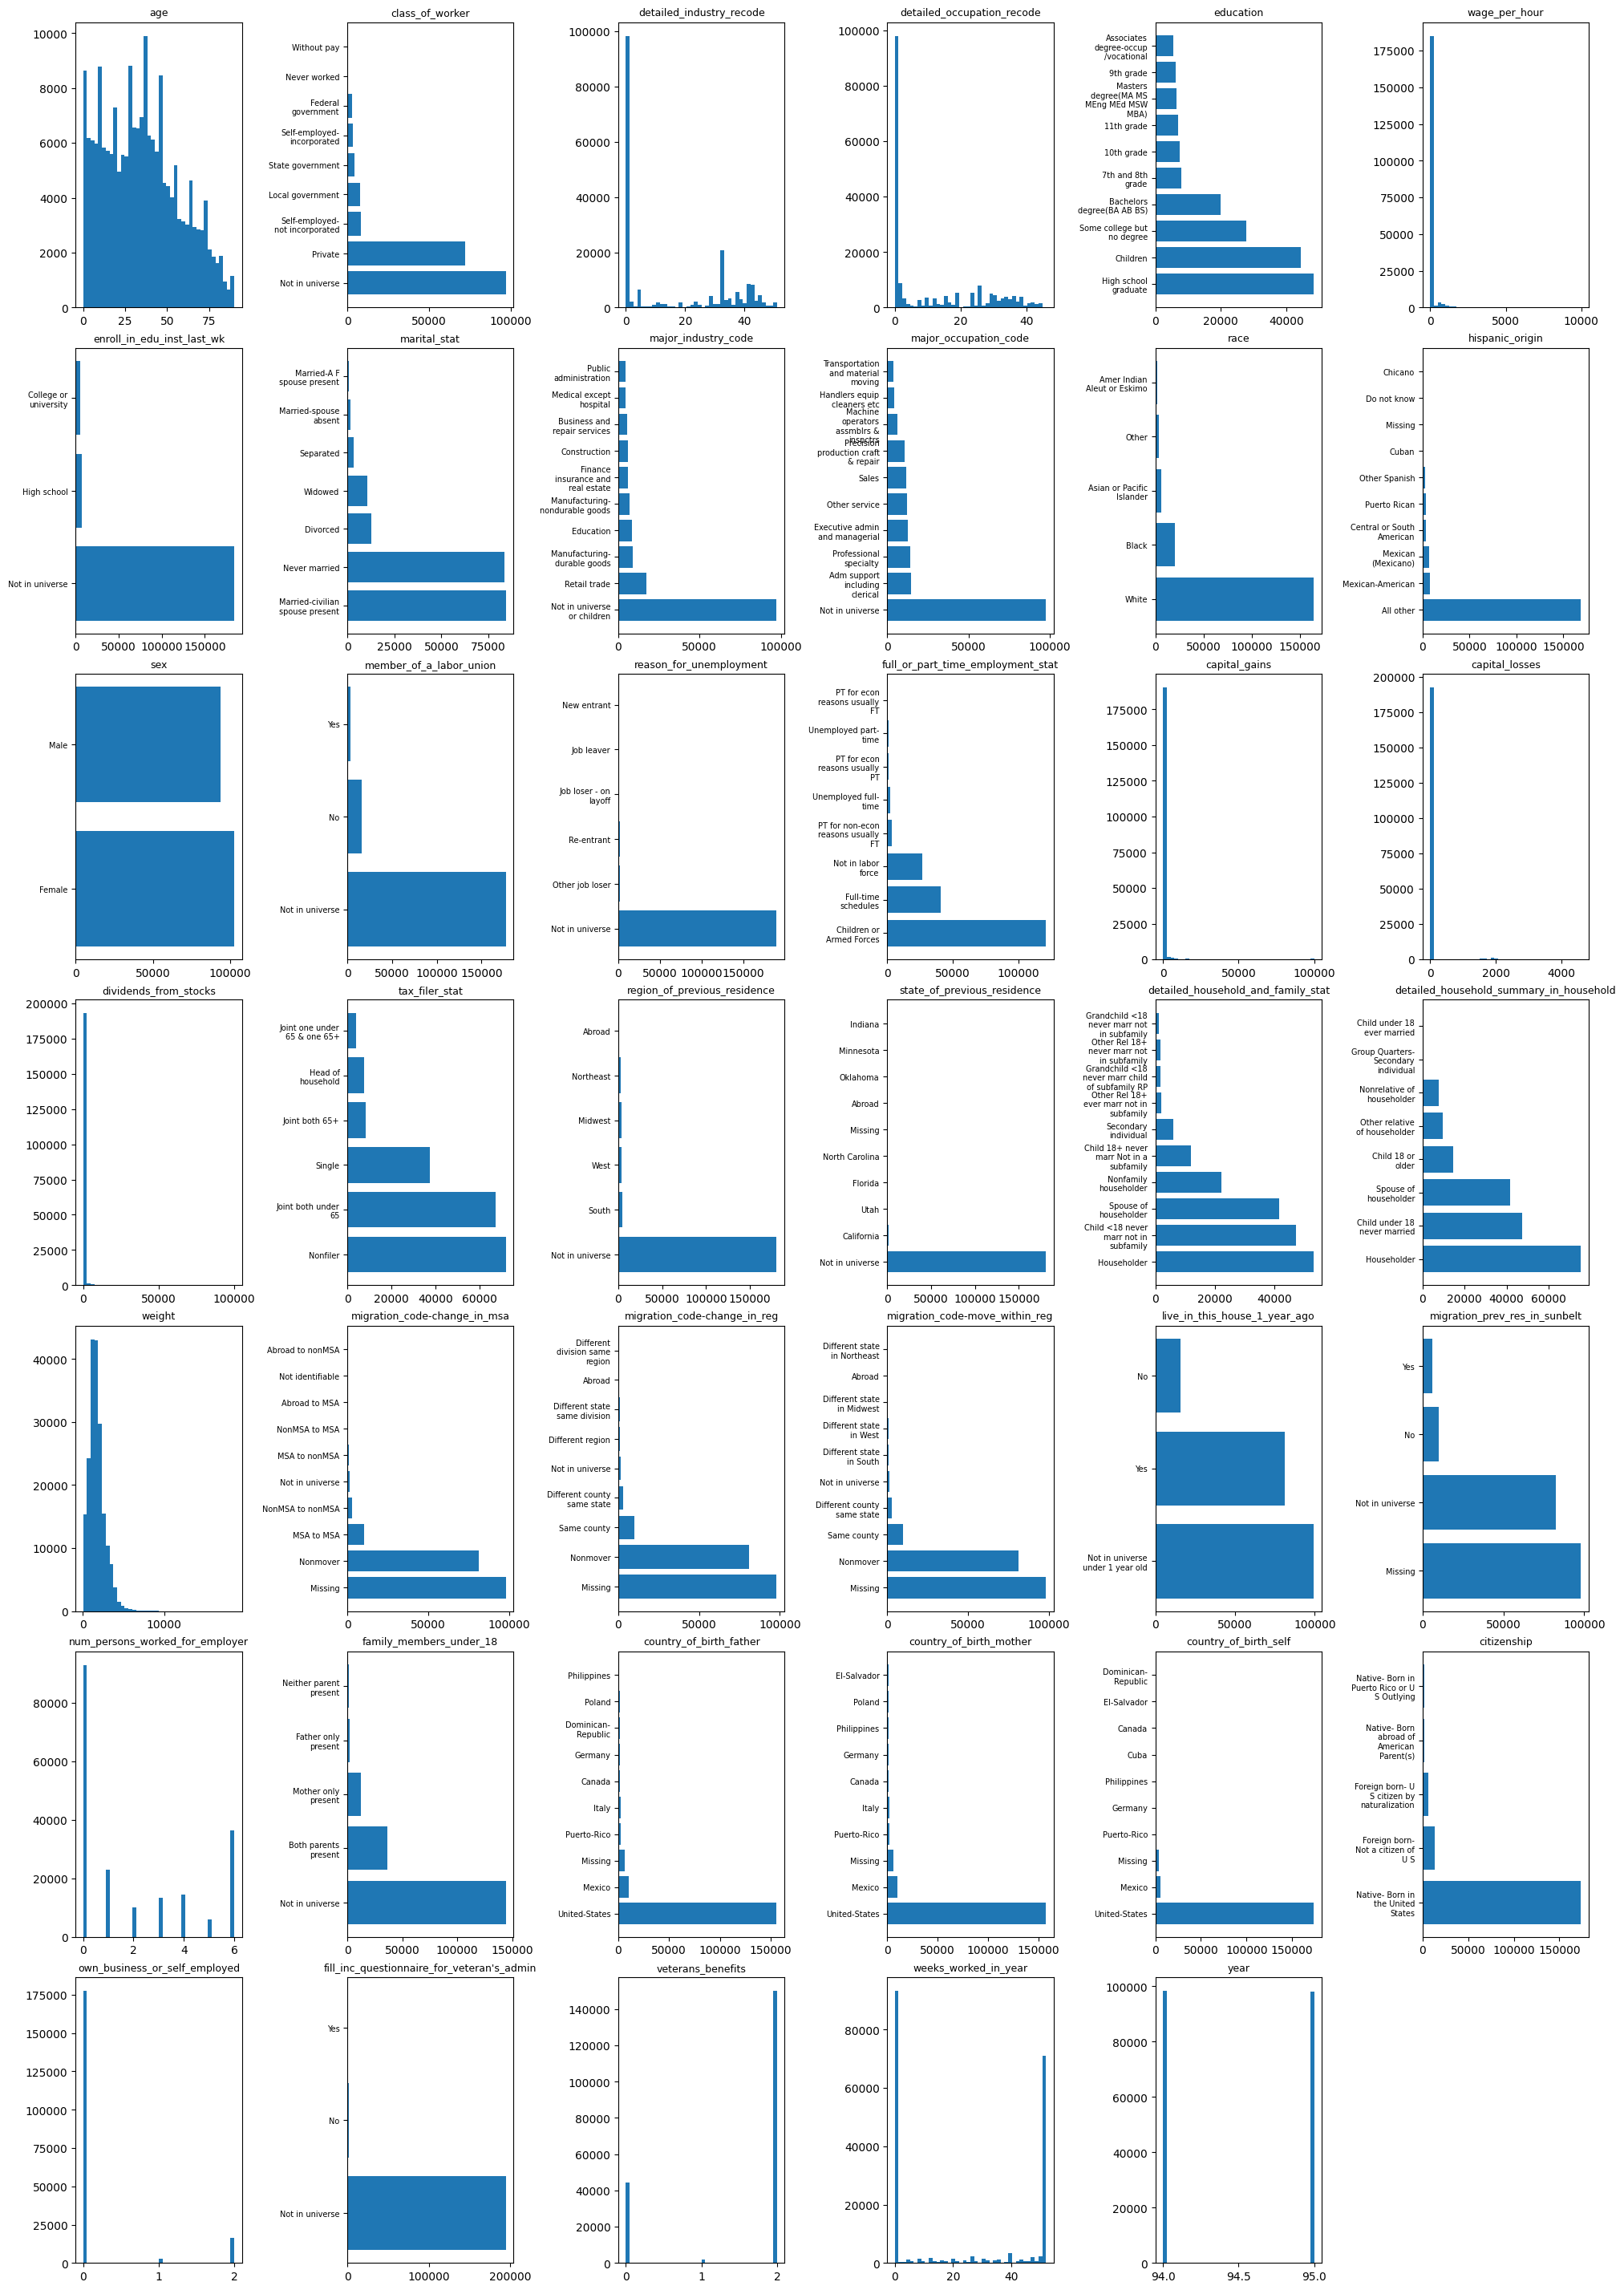

In [ ]:



def plot_features_grid(
    df: pd.DataFrame,
    label_col: str = "label",
    nrows: int = 9,
    ncols: int = 5,
    max_features: int = 41,
    top_k: int = 10,
    drop_constant: bool = True,
    wrap_width: int = 16,       # max characters per line for category labels
    cat_barh: bool = True,      # draw categorical features as horizontal bars
):
    """
    Plot a grid of feature distributions:
      - Numeric columns: histogram
      - Categorical/object columns: top-K frequency bar chart (horizontal by default)
    """

    # 1) pick feature columns (exclude label)
    features = [c for c in df.columns if c != label_col]

    # (Optional) drop constant columns (no variance)
    if drop_constant:
        features = [c for c in features if df[c].nunique(dropna=False) > 1]

    # 2) limit to first max_features
    features = features[:max_features]
    total = len(features)
    print(f"[INFO] plotting {total} features (max_features={max_features}).")

    # 3) make grid (constrained_layout reduces overlap better than tight_layout)
    fig, axes = plt.subplots(
        nrows=nrows, ncols=ncols, figsize=(20, 32), constrained_layout=True
    )
    axes = axes.flatten()

    for i, c in enumerate(features):
        ax = axes[i]
        if pd.api.types.is_numeric_dtype(df[c]):
            # numeric: histogram
            ax.hist(df[c].dropna(), bins=40)
            ax.set_title(c, fontsize=9)
            ax.set_xlabel("")
            ax.set_ylabel("")
        else:
            # categorical: top-k frequency
            vc = (
                df[c].fillna("Missing")
                .astype(str)
                .value_counts()
                .head(top_k)
            )

            if cat_barh:
                # horizontal bar plot: avoids x-label crowding
                vc = vc.sort_values(ascending=True)  # small at top, big at bottom
                ax.barh(range(len(vc)), vc.values)
                # wrap long labels into multiple lines
                wrapped = [fill(str(s), width=wrap_width) for s in vc.index]
                ax.set_yticks(range(len(vc)))
                ax.set_yticklabels(wrapped, fontsize=7)
                ax.invert_yaxis()  # highest count at the top
                ax.set_title(c, fontsize=9)
                ax.set_xlabel("")  # clean look
                ax.set_ylabel("")
            else:
                # vertical bars fallback (not recommended for long labels)
                vc.plot(kind="bar", ax=ax)
                ax.set_title(c, fontsize=9)
                ax.tick_params(axis="x", labelrotation=45, labelsize=7)
                # optional: right-align long labels
                for tick in ax.get_xticklabels():
                    tick.set_horizontalalignment("right")
                ax.set_xlabel("")
                ax.set_ylabel("")

    # remove unused axes if features < nrows*ncols
    for j in range(total, nrows * ncols):
        fig.delaxes(axes[j])

    plt.show()

# ---- call it ----
plot_features_grid(
    df,
    label_col="label",
    nrows=8, ncols=6, max_features=41, top_k=10,
    wrap_width=16, cat_barh=True
)

age', 'class_of_worker', 'detailed_industry_recode', 'detailed_occupation_recode', 'education', 'wage_per_hour', 'enroll_in_edu_inst_last_wk',
       'marital_stat', 'major_industry_code', 'major_occupation_code', 'race', 'hispanic_origin', 'sex', 'member_of_a_labor_union', 'reason_for_unemployment',
       'full_or_part_time_employment_stat', 'capital_gains', 'capital_losses', 'dividends_from_stocks', 'tax_filer_stat', 'region_of_previous_residence',
       'state_of_previous_residence', 'detailed_household_and_family_stat', 'detailed_household_summary_in_household', 'weight',
       'migration_code-change_in_msa', 'migration_code-change_in_reg', 'migration_code-move_within_reg', 'live_in_this_house_1_year_ago',
       'migration_prev_res_in_sunbelt', 'num_persons_worked_for_employer', 'family_members_under_18', 'country_of_birth_father', 'country_of_birth_mother',
       'country_of_birth_self', 'citizenship', 'own_business_or_self_employed', 'fill_inc_questionnaire_for_veteran's_admin', 'veterans_benefits',
       'weeks_worked_in_year', 'year', 'label'

##  Summary for data


###  1. Numerical Features
- **age**: Skewed towards younger to middle-aged individuals; the majority are between 30–40 years old, fewer elderly.  
- **wage_per_hour**: The vast majority are 0, suggesting most people receive fixed salaries rather than hourly wages.  
- **capital_gains / capital_losses / dividends_from_stocks**: Almost all are 0, with a few extreme values. These are highly sparse features and may need log-scaling.  
- **weight (fnlwgt)**: Exponentially decaying distribution; this is a survey sampling weight and we should not use it as a predictive feature.  
- **weeks_worked_in_year**: Mostly concentrated at 0 and 52, implying many either did not work at all or worked full-time for the entire year.  



###  2. Categorical Features
- **education**: Most frequent levels are high school, some college, and bachelor’s degree; very few master’s/PhDs.  
- **marital_status**: Married individuals dominate, followed by those who have never married; divorced/separated are fewer.  
- **sex**: Male and female are relatively balanced, with slightly more males.  
- **race**: White dominates, with very small counts of other races.  
- **hispanic_origin**: Mostly labeled as “Not in universe,” suggesting limited informational value.  
- **class_of_worker**: Private sector is the largest group, followed by self-employed or government workers.  
- **union_membership, veteran_benefits**: Almost all are “No” or “Not in universe,” making them near-constant features.  
- **region/state of previous residence, migration codes**: Largely “Not in universe,” highly imbalanced distributions.  



###  3. Feature Quality & Preprocessing Recommendations
- **Highly sparse / near-constant variables** (e.g., `veterans_benefits`, `union_membership`, ): Likely low predictive power, consider dropping or binarizing.  
- **Long-tailed distributions** (`capital_gains`, `capital_losses`,`dividends_from_stocks`): Apply log transformation or binning.  
- **High-cardinality categorical variables** (`state_of_previous_residence`, `detailed_industry_recode`): Should be grouped or target-encoded rather than one-hot encoded.  
- **“Not in universe” values**: Should be treated as a unified “Missing/Not applicable” category instead of as true levels.  



###  4. Potential Relationships with Income (Hypotheses)
- **Education level**: Higher education is strongly linked with >50K income.  
- **Marital status**: Married individuals likely have higher income (dual earners, more stable employment).  
- **Capital gains/losses**: Non-zero values almost certainly indicate higher income.  
- **Work duration**: Full-year workers (52 weeks) are much more likely to be >50K compared to those not working.  



### Conclusion
- The dataset is highly imbalanced, with many features dominated by a single value.  
- Some variables carry little informational value and can be dropped.  
- Features likely to be most predictive: education, age, marital status, capital gains/losses, and weeks worked per year.  

In [ ]:
# --- Utilities for categorical/continuous detection and association metrics ---

try:
    from scipy.stats import chi2_contingency
    SCIPY_AVAILABLE = True
except Exception:
    SCIPY_AVAILABLE = False

def detect_columns_for_assoc(
    df: pd.DataFrame,
    label_col: str = "label",
    min_unique_cont: int = 15,
    min_unique_ratio: float = 0.01,
) -> tuple[list[str], list[str]]:
    """
    Heuristically detect categorical vs continuous columns.
    - Categorical: non-numeric OR low-cardinality numeric OR names containing 'recode'
    - Continuous: numeric with enough unique values and not 'recode'
    """
    n = len(df)
    # Start with obvious categorical (object/category dtypes)
    cat_cols = df.select_dtypes(include=["object", "category"]).columns.tolist()

    # Numeric columns
    num_cols = df.select_dtypes(include=[np.number]).columns.tolist()

    # Add likely-coded numeric columns to categorical set
    coded_numeric = []
    for c in num_cols:
        if "recode" in c.lower():
            coded_numeric.append(c)
        else:
            uniq = df[c].nunique(dropna=True)
            # treat small-cardinality numeric as categorical
            if uniq <= 20:  
                coded_numeric.append(c)
    cat_cols = list(dict.fromkeys(cat_cols + coded_numeric))

    # Remove the label from categorical if present
    if label_col in cat_cols:
        cat_cols.remove(label_col)

    # Continuous = numeric columns with enough unique values and not in coded list
    cont_cols = []
    for c in num_cols:
        if c in coded_numeric:
            continue
        uniq = df[c].nunique(dropna=True)
        if uniq >= max(min_unique_cont, int(min_unique_ratio * n)):
            cont_cols.append(c)

    # Optional: commonly dropped columns (you can comment these out if you want to keep)
    for drop_c in ["year", "weight"]:
        if drop_c in cont_cols:
            cont_cols.remove(drop_c)

    return cat_cols, cont_cols


def cramers_v_bias_corrected(x: pd.Series, y: pd.Series) -> float:
    """
    Cramér’s V with bias-correction (Bergsma & Wicher, 2013).
    Works for two categorical variables.
    """
    tbl = pd.crosstab(x, y)
    if tbl.size == 0 or tbl.shape[0] < 2 or tbl.shape[1] < 2:
        return np.nan

    if SCIPY_AVAILABLE:
        chi2 = chi2_contingency(tbl, correction=False)[0]
    else:
        # Manual chi-square
        observed = tbl.values
        row_sums = observed.sum(axis=1, keepdims=True)
        col_sums = observed.sum(axis=0, keepdims=True)
        total = observed.sum()
        expected = row_sums @ col_sums / total
        with np.errstate(divide='ignore', invalid='ignore'):
            chi2 = np.nansum((observed - expected) ** 2 / expected)

    n = tbl.values.sum()
    r, k = tbl.shape
    phi2 = chi2 / n
    # Bias correction
    phi2corr = max(0, phi2 - (k - 1) * (r - 1) / (n - 1))
    rcorr = r - (r - 1) ** 2 / (n - 1)
    kcorr = k - (k - 1) ** 2 / (n - 1)
    denom = min((kcorr - 1), (rcorr - 1))
    return sqrt(phi2corr / denom) if denom > 0 else np.nan


def correlation_ratio(categories: pd.Series, values: pd.Series) -> float:
    """
    Correlation ratio (η, we return η^2) for categorical → continuous association.
    η^2 = between-group variance / total variance (0..1).
    """
    # Align and drop missing pairs
    data = pd.DataFrame({"cat": categories, "val": values}).dropna()
    if data.empty:
        return np.nan

    groups = data.groupby("cat")["val"]
    counts = groups.count().values.astype(float)
    means = groups.mean().values
    overall_mean = data["val"].mean()

    # Between-group sum of squares / total sum of squares
    ss_between = np.sum(counts * (means - overall_mean) ** 2)
    ss_total = np.sum((data["val"] - overall_mean) ** 2)
    if ss_total <= 0:
        return np.nan
    return ss_between / ss_total  # η^2

[INFO] categorical cols (34): ['class_of_worker', 'education', 'enroll_in_edu_inst_last_wk', 'marital_stat', 'major_industry_code', 'major_occupation_code', 'race', 'hispanic_origin', 'sex', 'member_of_a_labor_union', 'reason_for_unemployment', 'full_or_part_time_employment_stat', 'tax_filer_stat', 'region_of_previous_residence', 'state_of_previous_residence', 'detailed_household_and_family_stat', 'detailed_household_summary_in_household', 'migration_code-change_in_msa', 'migration_code-change_in_reg', 'migration_code-move_within_reg', 'live_in_this_house_1_year_ago', 'migration_prev_res_in_sunbelt', 'family_members_under_18', 'country_of_birth_father', 'country_of_birth_mother', 'country_of_birth_self', 'citizenship', "fill_inc_questionnaire_for_veteran's_admin", 'detailed_industry_recode', 'detailed_occupation_recode', 'num_persons_worked_for_employer', 'own_business_or_self_employed', 'veterans_benefits', 'year']
[INFO] continuous cols  (6): ['age', 'capital_gains', 'capital_losses'

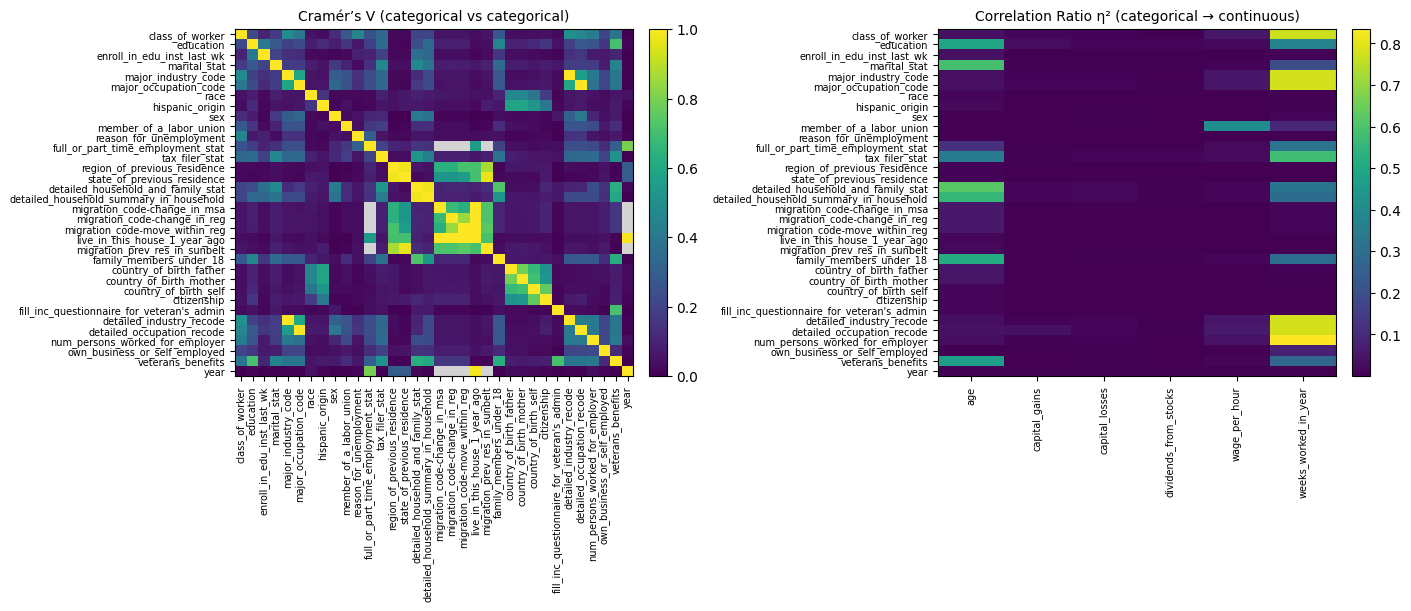

In [ ]:
# --- Build Cramér’s V (cat-cat) and η² (cat-cont) matrices ---


SAMPLE_N = None        # None -> use full data; set to an int for faster sampling (e.g., 80000)
MAX_CAT_COLS = 50      # cap number of categorical columns (to keep the heatmap readable)
MAX_CONT_COLS = 50     # cap number of continuous columns

# 1) Optional sampling for speed
_df = df.sample(n=SAMPLE_N, random_state=42) if SAMPLE_N else df

# 2) HYBRID column selection: explicit list + relaxed auto-detection
EXPLICIT_CONT_COLS = [
    "age", "wage_per_hour",
    "capital_gains", "capital_losses", "dividends_from_stocks",
    "weeks_worked_in_year"
]

# Relaxed thresholds so typical count-like features pass the filter
AUTO_MIN_UNIQUE = 5
AUTO_MIN_UNIQUE_RATIO = 0.0005  # 0.05% of rows

# Auto-detect on the (possibly sampled) DataFrame
cat_auto, cont_auto = detect_columns_for_assoc(
    _df,
    label_col="label",
    min_unique_cont=AUTO_MIN_UNIQUE,
    min_unique_ratio=AUTO_MIN_UNIQUE_RATIO,
)

# Start from explicit continuous columns that actually exist
cont_cols = [c for c in EXPLICIT_CONT_COLS if c in _df.columns]
# Add relaxed auto-detected continuous columns
cont_cols = sorted(set(cont_cols).union(cont_auto))
# Drop known non-predictive / survey-only columns
cont_cols = [c for c in cont_cols if c not in ("year", "weight")]
# Keep only non-degenerate and cap the count
cont_cols = [c for c in cont_cols if _df[c].nunique(dropna=True) > 1][:MAX_CONT_COLS]

# Categorical = auto-detected (remove degenerate + label) and cap the count
cat_cols = [c for c in cat_auto if c != "label" and _df[c].nunique(dropna=True) > 1][:MAX_CAT_COLS]

print(f"[INFO] categorical cols ({len(cat_cols)}):", cat_cols)
print(f"[INFO] continuous cols  ({len(cont_cols)}):", cont_cols)

# 3) Cramér’s V (cat-cat)
cv_mat = pd.DataFrame(index=cat_cols, columns=cat_cols, dtype=float)
for i, c1 in enumerate(cat_cols):
    for j, c2 in enumerate(cat_cols):
        if j < i:
            cv_mat.iat[i, j] = cv_mat.iat[j, i]  # reuse symmetry
        else:
            v = 1.0 if c1 == c2 else cramers_v_bias_corrected(_df[c1], _df[c2])
            cv_mat.iat[i, j] = v

# 4) Correlation Ratio η² (cat-cont)
eta_mat = pd.DataFrame(index=cat_cols, columns=cont_cols, dtype=float)
for c1 in cat_cols:
    for c2 in cont_cols:
        eta_mat.loc[c1, c2] = correlation_ratio(_df[c1], _df[c2])

# 5) Plot heatmaps 
import numpy as np
import matplotlib.pyplot as plt

def plot_heatmaps_side_by_side(cv_mat: pd.DataFrame, eta_mat: pd.DataFrame,
                               fig_width: float = 14, fig_height: float = 6,
                               tick_font_small: int = 7, title_font: int = 10):
    """Render the two association heatmaps side-by-side with compact sizing."""
    # Sanity checks
    has_cv = cv_mat is not None and cv_mat.shape[0] >= 2
    has_eta = eta_mat is not None and eta_mat.shape[0] >= 1 and eta_mat.shape[1] >= 1
    if not (has_cv or has_eta):
        print("Nothing to plot.")
        return

    # Prepare figure and axes (1 row, 2 columns)
    if has_cv and has_eta:
        fig, axes = plt.subplots(1, 2, figsize=(fig_width, fig_height), constrained_layout=True)
        ax1, ax2 = axes
    elif has_cv:
        fig, ax1 = plt.subplots(1, 1, figsize=(fig_width/2, fig_height), constrained_layout=True)
        ax2 = None
    else:
        fig, ax2 = plt.subplots(1, 1, figsize=(fig_width/2, fig_height), constrained_layout=True)
        ax1 = None

    
    def _plot_single(ax, mat, title):
        arr = mat.values.astype(float)
        masked = np.ma.masked_invalid(arr)
        cmap = plt.cm.viridis.copy()
        cmap.set_bad(color="lightgray")  # show NaNs as light gray for readability
        im = ax.imshow(masked, aspect="auto", interpolation="nearest", cmap=cmap)
        ax.set_title(title, fontsize=title_font)
        ax.set_xticks(range(mat.shape[1]))
        ax.set_xticklabels(mat.columns, rotation=90, fontsize=tick_font_small)
        ax.set_yticks(range(mat.shape[0]))
        ax.set_yticklabels(mat.index, fontsize=tick_font_small)
        plt.colorbar(im, ax=ax, fraction=0.046, pad=0.04)
        return im

    if has_cv:
        _plot_single(ax1, cv_mat, "Cramér’s V (categorical vs categorical)")

    if has_eta:
        _plot_single(ax2, eta_mat, "Correlation Ratio η² (categorical → continuous)")

    plt.show()


plot_heatmaps_side_by_side(cv_mat, eta_mat, fig_width=14, fig_height=6, tick_font_small=7)


In [73]:
df['live_in_this_house_1_year_ago']

0         Not in universe under 1 year old
1                                       No
2         Not in universe under 1 year old
3                                      Yes
4                                      Yes
                        ...               
196289    Not in universe under 1 year old
196290                                 Yes
196291    Not in universe under 1 year old
196292    Not in universe under 1 year old
196293                                 Yes
Name: live_in_this_house_1_year_ago, Length: 196294, dtype: object

## Insights from Association Heatmaps

This summary interprets the two plots you generated:
- **Cramér’s V (categorical vs categorical)** — shows redundancy/association among categorical features.
- **Correlation Ratio η² (categorical → continuous)** — shows how much each categorical feature explains the variance of continuous features.


### 1)  Cramér’s V heatmap  (categorical–categorical)

#### Strong “clusters” (high association → potential redundancy)
- **Region ↔ State of previous residence**  
  These are near-deterministic (very bright block). **Keep one**: prefer the coarser `region_of_previous_residence` or map `state` → `region`.
- **Migration-related variables**  
  (`migration_code-change_in_msa`, `_in_reg`, `_move_within_reg`, `live_in_this_house_1_year_ago`, `migration_prev_res_in_sunbelt`) form a tight cluster.  
  → Combine into **1–2 derived features** (e.g., `is_mover`, `moved_across_region`) and drop the rest.
- **marital_stat ↔ tax_filer_stat**  
  Strong association; both describe family/filing status.  
  → For linear models, **choose one** (often `marital_stat`). For tree models they can co-exist but add dimensionality.
- **Household pair**  
  `detailed_household_and_family_stat` ↔ `detailed_household_summary_in_household` are highly associated.  
  → Keep one or coarsen categories.
- **citizenship ↔ country_of_birth_(self/father/mother)**  
  High association: `citizenship` usually subsumes birthplace information.  
  → Keep **`citizenship`** or **`country_of_birth_self`**; dropping the other birthplace columns reduces redundancy.

> Takeaway: the bright blocks indicate **information duplication**. Prune or group to reduce noise and dimensionality—especially important for linear models and one-hot encodings.



### 2)  η² heatmap  (categorical → continuous)

#### Categorical features that explain continuous targets
- **weeks_worked_in_year**  
  Strongly explained by **`full_or_part_time_employment_stat`**, with notable contributions from **`tax_filer_stat`** and **`marital_stat`**.  
  → These variables overlap conceptually with “work intensity.” Prefer **`weeks_worked_in_year` + 1–2 categorical drivers**; avoid stacking many near-duplicates in linear models.
- **wage_per_hour**  
  Most explained by **`class_of_worker`** and **`major_occupation_code`**.  
  → Employment type and occupation are key drivers of hourly wage; keep them (consider grouping to control one-hot size).
- **age**  
  Partly explained by **`marital_stat`** and **`education`** (moderate, not strong).  
  → Reasonable to keep all three; note the overlap in life-stage signal.
- **capital_gains / capital_losses / dividends_from_stocks**  
  η² is near zero against most categorical features—i.e., **largely independent signals**.  
  → Keep them; they are sparse but highly discriminative when non-zero (consider binarization + log/binning).
- **year**  
  Very low η² across the board.  
  → **Drop**; it adds no predictive value.



### 3) Actionable feature-engineering plan

1. **De-duplicate clusters**
   - Keep `region` or map `state → region`.
   - Collapse migration variables to `is_mover` and `moved_across_region`.
   - Prefer `marital_stat` over `tax_filer_stat` for linear models; OK to keep both for trees.
   - Keep only one of the household pair.
   - Keep `citizenship` (or `country_of_birth_self`) and drop the other birthplace columns.

2. **Preserve strong/independent signals**
   - Keep `weeks_worked_in_year`, `class_of_worker`, `major_occupation_code`, `education`, `age`.
   - Keep `capital_gains`, `capital_losses`, `dividends_from_stocks`; apply **binarization (`>0`) + `log1p`/binning**.

3. **Encoding & scaling**
   - **High-cardinality** categories (state, occupation, industry): use **target encoding** or coarse grouping; avoid exploding one-hot.
   - **Low-cardinality** categories (sex, marital_stat): one-hot is fine.
   - Scale only where needed (e.g., linear/NN models). Tree models do not require scaling.

4. **Drop / down-weight**
   - Drop **`year`**.  
   - Consider dropping very rare, near-constant, or “Not in universe” dominated columns unless they add clear lift.



### 4) Modeling implications

- After pruning redundancy and crafting compact encodings, start with:
  - **Linear baseline (Logistic Regression with class_weight="balanced")** to sanity-check signal.
  - **Tree ensemble (LightGBM/XGBoost)** to capture non-linearities; they tolerate correlated inputs better.
- Monitor **Recall/F1/PR-AUC** due to class imbalance; tune thresholds using the validation set.


Use Cramér’s V to **remove/category-group redundant features**, and η² to **identify which categories truly drive continuous behaviors**. Keep independent wealth signals (capital gains/losses/dividends), favor compact groupings/encodings, and drop `year`. This yields a leaner, more predictive feature set with less noise and lower dimensionality.

# 2. Feature Engineering

In [75]:
df.columns

Index(['age', 'class_of_worker', 'detailed_industry_recode', 'detailed_occupation_recode', 'education', 'wage_per_hour', 'enroll_in_edu_inst_last_wk',
       'marital_stat', 'major_industry_code', 'major_occupation_code', 'race', 'hispanic_origin', 'sex', 'member_of_a_labor_union', 'reason_for_unemployment',
       'full_or_part_time_employment_stat', 'capital_gains', 'capital_losses', 'dividends_from_stocks', 'tax_filer_stat', 'region_of_previous_residence',
       'state_of_previous_residence', 'detailed_household_and_family_stat', 'detailed_household_summary_in_household', 'weight',
       'migration_code-change_in_msa', 'migration_code-change_in_reg', 'migration_code-move_within_reg', 'live_in_this_house_1_year_ago',
       'migration_prev_res_in_sunbelt', 'num_persons_worked_for_employer', 'family_members_under_18', 'country_of_birth_father', 'country_of_birth_mother',
       'country_of_birth_self', 'citizenship', 'own_business_or_self_employed', 'fill_inc_questionnaire_for_veter

In [122]:
# --- 1) Feature builder: column dropping, value normalization, derived features ---


class FeatureBuilder(BaseEstimator, TransformerMixin):
    def __init__(self):
        # columns we plan to drop (if present)
        self.drop_cols_ = [
            "year", "weight",  # survey-only
            "state_of_previous_residence",            # keep region instead
            "country_of_birth_father", "country_of_birth_mother"  # keep citizenship or self
        ]
        # pick one of the household pair if both exist
        self.household_pair_ = [
            "detailed_household_and_family_stat",
            "detailed_household_summary_in_household"
        ]
        # strings that mean missing/NA-ish in this dataset
        self.missing_tokens_ = ["Not in universe", "?", " Unknown", "unknown", "  ?"]

    def fit(self, X, y=None):
        return self

    def transform(self, X):
        df = X.copy()

        # 1) unify missing-like tokens (categoricals)
        obj_cols = df.select_dtypes(include=["object", "category"]).columns
        for c in obj_cols:
            df[c] = (
                df[c].astype(str).str.strip()     
                    .replace(self.missing_tokens_, "Missing")
            )

        # 2) if region is missing but state exists, create region from state (BEFORE dropping state)
        if "region_of_previous_residence" not in df.columns and "state_of_previous_residence" in df.columns:
            # Census 4-region mapping by full state name
            northeast = {
                "Connecticut","Maine","Massachusetts","New Hampshire","Rhode Island","Vermont",
                "New Jersey","New York","Pennsylvania"
            }
            midwest = {
                "Illinois","Indiana","Michigan","Ohio","Wisconsin",
                "Iowa","Kansas","Minnesota","Missouri","Nebraska","North Dakota","South Dakota"
            }
            south = {
                "Delaware","District of Columbia","Florida","Georgia","Maryland","North Carolina","South Carolina","Virginia","West Virginia",
                "Alabama","Kentucky","Mississippi","Tennessee",
                "Arkansas","Louisiana","Oklahoma","Texas"
            }
            west = {
                "Arizona","Colorado","Idaho","Montana","Nevada","New Mexico","Utah","Wyoming",
                "Alaska","California","Hawaii","Oregon","Washington"
            }
            def state_to_region(s):
                s = str(s)
                if s in ("Missing", "Not in universe", "?", "unknown", "  ?"):
                    return "Missing"
                if s in northeast: return "Northeast"
                if s in midwest:   return "Midwest"
                if s in south:     return "South"
                if s in west:      return "West"
                # for territories / foreign / odd tokens
                if "puerto" in s.lower() or "guam" in s.lower() or "outlying" in s.lower():
                    return "Other"
                return "Other"
            df["region_of_previous_residence"] = df["state_of_previous_residence"].map(state_to_region)

        # 3) drop redundant/low-value columns (NOW after the mapping above)
        drop_exist = [c for c in self.drop_cols_ if c in df.columns]
        df = df.drop(columns=drop_exist, errors="ignore")

        # 4) if both household columns exist, keep the first one and drop the other
        both_have = [c for c in self.household_pair_ if c in df.columns]
        if len(both_have) == 2:
            df = df.drop(columns=[both_have[1]])

        # 5) derived features
        if "wage_per_hour" in df.columns:
            df["hourly_worker"] = (df["wage_per_hour"] > 0).astype(int)
            df["log_wage_per_hour"] = np.where(df["wage_per_hour"] > 0, np.log1p(df["wage_per_hour"]), 0.0)

        for col in ["capital_gains", "capital_losses", "dividends_from_stocks"]:
            if col in df.columns:
                df[f"has_{col}"] = (df[col] > 0).astype(int)
                df[f"log_{col}"] = np.where(df[col] > 0, np.log1p(df[col]), 0.0)

        if "weeks_worked_in_year" in df.columns:
            df["full_year_worker"] = (df["weeks_worked_in_year"] >= 50).astype(int)
            df["no_work"] = (df["weeks_worked_in_year"] == 0).astype(int)

        # 6) mobility flag (deterministic mapping based on your actual categories)

        move_signals = []

        # live_in_this_house_1_year_ago: Yes -> non-mover(0), No -> mover(1),
        # "Not in universe under 1 year old" -> unknown (NaN)
        if "live_in_this_house_1_year_ago" in df.columns:
            s = df["live_in_this_house_1_year_ago"].astype(str)
            map_house = {
                "Yes": 0,
                "No": 1,
                "Not in universe under 1 year old": np.nan,
                "Missing": np.nan,   # in case it was normalized earlier
            }
            move_signals.append(s.map(map_house))

        # migration_code-change_in_msa
        # Nonmover -> 0; any to/from MSA/NonMSA/Abroad -> 1; Not identifiable/Missing -> NaN
        if "migration_code-change_in_msa" in df.columns:
            s = df["migration_code-change_in_msa"].astype(str)
            map_msa = {
                "Nonmover": 0,
                "MSA to MSA": 1,
                "NonMSA to nonMSA": 1,
                "MSA to nonMSA": 1,
                "NonMSA to MSA": 1,
                "Abroad to MSA": 1,
                "Abroad to nonMSA": 1,
                "Not identifiable": np.nan,
                "Not in universe": np.nan,  # if normalization didn't run
                "Missing": np.nan,
            }
            move_signals.append(s.map(map_msa))

        # migration_code-change_in_reg
        # "Same county"/"Nonmover" -> 0; any "Different *" or "Abroad" -> 1; Not in universe/Missing -> NaN
        if "migration_code-change_in_reg" in df.columns:
            s = df["migration_code-change_in_reg"].astype(str)
            map_reg = {
                "Nonmover": 0,
                "Same county": 0,
                "Different region": 1,
                "Different county same state": 1,
                "Different division same region": 1,
                "Different state same division": 1,
                "Abroad": 1,
                "Not in universe": np.nan,
                "Missing": np.nan,
            }
            move_signals.append(s.map(map_reg))

        # migration_code-move_within_reg
        # "Same county"/"Nonmover" -> 0; any "Different state ..." or "Different county same state"/"Abroad" -> 1
        if "migration_code-move_within_reg" in df.columns:
            s = df["migration_code-move_within_reg"].astype(str)
            map_within = {
                "Nonmover": 0,
                "Same county": 0,
                "Different county same state": 1,
                "Different state in South": 1,
                "Different state in Northeast": 1,
                "Different state in Midwest": 1,
                "Different state in West": 1,
                "Abroad": 1,
                "Not in universe": np.nan,
                "Missing": np.nan,
            }
            move_signals.append(s.map(map_within))

        #  migration_prev_res_in_sunbelt is not a direct move indicator, so we ignore here.

        # Aggregate rule per row:
        # if any signal == 1 -> mover (1)
        # elif any signal == 0 -> non-mover (0)
        # else -> unknown (NaN)  (SimpleImputer in your numeric pipeline will fill this, typically to 0)
        if move_signals:
            sig = pd.concat(move_signals, axis=1)
            df["is_mover"] = sig.apply(
                lambda r: 1 if (r == 1).any() else (0 if (r == 0).any() else np.nan),
                axis=1
            ).astype(float)  # keep float so imputer can handle NaN
        assert isinstance(df, pd.DataFrame), "FeatureBuilder.transform must return a DataFrame"
        # age bucket
        if "age" in df.columns:
            df["age_bucket"] = pd.cut(
                df["age"].astype(float),
                bins=[0, 17, 24, 34, 44, 54, 64, 120],
                labels=["u18","18-24","25-34","35-44","45-54","55-64","65+"],
                include_lowest=True
            ).astype("category")
        
        # Weeks worked bucket
        if "weeks_worked_in_year" in df.columns:
            w = df["weeks_worked_in_year"].astype(float)
            df["weeks_bucket"] = pd.cut(
                w, bins=[-1, 0, 26, 51, 100],
                labels=["0","1-26","27-51","52"]
            ).astype("category")
        
        # Age x Education cross
        if "age_bucket" in df.columns and "education" in df.columns:
            df["age_edu"] = (df["age_bucket"].astype(str) + "|" + df["education"].astype(str)).astype("category")
        has_cols = []
        for c in ["capital_gains","capital_losses","dividends_from_stocks"]:
            if c in df.columns:
                has_cols.append((df[c] > 0).astype(int))
        if has_cols:
            df["has_any_capital"] = pd.concat(has_cols, axis=1).max(axis=1).astype(int)

        if "capital_gains" in df.columns and "capital_losses" in df.columns:
            net = (df["capital_gains"].fillna(0) - df["capital_losses"].fillna(0))
            df["cap_net"] = net
            df["log_cap_net_pos"] = np.where(net > 0, np.log1p(net), 0.0)
        # Married flag
        if "marital_stat" in df.columns:
            m = df["marital_stat"].astype(str)
            df["is_married"] = m.str.contains("Married", case=False, na=False).astype(int)

        # Union member flag
        if "member_of_a_labor_union" in df.columns:
            u = df["member_of_a_labor_union"].astype(str).str.strip().str.lower()
            df["is_union"] = u.eq("yes").astype(int)

        # Self-employed flag
        if "class_of_worker" in df.columns:
            cw = df["class_of_worker"].astype(str).str.lower()
            df["is_self_employed"] = cw.str.contains("self-employed", na=False).astype(int)
        if "migration_prev_res_in_sunbelt" in df.columns:
            s = df["migration_prev_res_in_sunbelt"].astype(str).str.strip().str.lower()
            s = s.replace({"not in universe": "missing"})
            s = s.where(s.isin(["yes","no","missing"]), "missing")
            df["prev_res_sunbelt"] = s.astype("category")
        return df
    def fit_transform(self, X, y=None, **fit_params):
        # Be explicit to avoid surprises with Mixin versions
        return self.transform(X)
    

In [ ]:
# --- 2) Target Mean Encoder (renamed to avoid clash) ---



class TargetMeanEncoder1D(BaseEstimator, TransformerMixin):
    def __init__(self, m=50):
        self.m = m  # smoothing

    def _to_series(self, X):
        if isinstance(X, pd.Series):
            return X
        if isinstance(X, pd.DataFrame):
            if X.shape[1] != 1:
                raise ValueError("TargetMeanEncoder1D expects exactly 1 column.")
            return X.iloc[:, 0]
        arr = np.asarray(X)
        if arr.ndim == 2 and arr.shape[1] == 1:
            arr = arr[:, 0]
        return pd.Series(arr)

    def fit(self, X, y):
        s = self._to_series(X).reset_index(drop=True)
        y = pd.Series(y).reset_index(drop=True)
        self.global_mean_ = float(y.mean())
        df_ = pd.DataFrame({"cat": s, "y": y})
        means = df_.groupby("cat")["y"].mean()
        counts = df_.groupby("cat")["y"].count()
        m = self.m
        enc = (means * counts + m * self.global_mean_) / (counts + m)
        self.mapping_ = enc.to_dict()
        return self

    def transform(self, X):
        s = self._to_series(X)
        mapped = s.map(self.mapping_)
        mapped = pd.to_numeric(mapped, errors="coerce")
        out = mapped.fillna(float(self.global_mean_)).to_numpy().reshape(-1, 1)
        return out

# 3. Modeling - objective 1

In [128]:

# function to map various income labels to binary 0/1
def map_label_to_binary_census(s: pd.Series) -> pd.Series:
    """
    Map income label to {0,1} for Census/Adult variants.
    Handles numeric 0/1; '<=50K'/'<=50K.'; '>50K'/'50000+.'; '- 50000.'; and generic patterns.
    """
    # Case 1: already numeric 0/1
    if pd.api.types.is_numeric_dtype(s):
        uniq = set(pd.unique(s))
        if uniq <= {0, 1}:
            return s.astype(int)

    # Normalize strings: strip, lower, remove spaces and periods
    s_norm = (
        s.astype(str)
         .str.strip()
         .str.lower()
         .str.replace(r"\s+", "", regex=True)   # remove all spaces
         .str.replace(".", "", regex=False)     # remove dots
    )

    # Exact tokens commonly seen
    exact_map = {
        "<=50k": 0, "<=50k": 0, "<=50": 0, "<50k": 0, "<50": 0,
        "-50000": 0,            # maps ' - 50000.' → '-50000'
        ">50k": 1, ">50": 1,
        "50000+": 1,            # maps ' 50000+.' → '50000+'
        "50k+": 1
    }

    # If all values are in the exact_map keys
    if set(pd.unique(s_norm)) <= set(exact_map.keys()):
        return s_norm.map(exact_map).astype(int)

    # Fallback: pattern-based (covers mixed vocab)
    is_high = (
        s_norm.str.contains(r"(>50k|>50|50000\+|50k\+)", regex=True)
    )
    is_low = (
        s_norm.str.contains(r"(<\=50k|<\=50|<50k|<50|-50000)", regex=True)
    )

    y = pd.Series(np.where(is_high, 1, np.where(is_low, 0, np.nan)), index=s.index)

    # Final check
    if y.isna().any():
        print("Unmapped label examples (top 10):")
        print(s.loc[y.isna()].value_counts().head(10))
        raise ValueError("Some labels could not be mapped. Update the mapping patterns.")
    return y.astype(int)

## Compare different models

In [ ]:
# ===================== 1) Label mapping & build raw X =====================
TARGET_COL = "label"
y = map_label_to_binary_census(df[TARGET_COL])
print("y distribution:\n", y.value_counts(dropna=False))
assert y.nunique() == 2, "Label must contain both classes before splitting."
# --- Build sample weights from survey weight column ---
w_all = df["weight"].astype(float)
w_all = w_all / w_all.mean()  # normalize to mean=1 for numeric stability
X = df.drop(columns=[TARGET_COL])

# ===================== 2) Probe FeatureBuilder OUTPUT (no X_train needed) =====================
# We only use this to discover which columns exist AFTER FeatureBuilder.
# This does NOT use y and does NOT leak target information.
tmp = FeatureBuilder().fit_transform(X.copy())
print("FeatureBuilder output shape:", tmp.shape)


# Candidate lists we WANT to use
numeric_cols_all = [
    "age", "weeks_worked_in_year",
    "log_wage_per_hour", "log_capital_gains", "log_capital_losses", "log_dividends_from_stocks",
    "hourly_worker", "has_capital_gains", "has_capital_losses", "has_dividends_from_stocks",
    "full_year_worker", "no_work", "is_mover","has_any_capital", "cap_net", "log_cap_net_pos",
    "is_married", "is_union", "is_self_employed"
]
low_card_cats_all = [
    "sex", "marital_stat", "education", "class_of_worker",
    "citizenship", "region_of_previous_residence","age_bucket", "weeks_bucket", "age_edu",
    "prev_res_sunbelt"
]
high_card_cats_all = [
    "major_industry_code", "major_occupation_code",
    "detailed_industry_recode", "detailed_occupation_recode"
]
if "age_edu" in tmp.columns:
    nunq = tmp["age_edu"].nunique(dropna=True)
    if nunq <= 40:
        low_card_cats_all.append("age_edu")
    else:
        high_card_cats_all.append("age_edu")

# Keep only features that actually exist after FeatureBuilder
numeric_cols   = [c for c in numeric_cols_all   if c in tmp.columns]
low_card_cats  = [c for c in low_card_cats_all  if c in tmp.columns]
high_card_cats = [c for c in high_card_cats_all if c in tmp.columns]

print("numeric_cols:", numeric_cols)
print("low_card_cats:", low_card_cats)
print("high_card_cats:", high_card_cats)

# ===================== 3) Build preprocess & pipeline =====================


# OneHot compatibility across sklearn versions
try:
    onehot = OneHotEncoder(handle_unknown="ignore", sparse_output=False)
except TypeError:
    onehot = OneHotEncoder(handle_unknown="ignore", sparse=False)

num_pipe = Pipeline([
    ("impute", SimpleImputer(strategy="median")),
    ("scale", StandardScaler())
])

# Target-mean encoder blocks for high-card categoricals
tgt_blocks = [(f"tgt_{col}", TargetMeanEncoder1D(m=50), [col]) for col in high_card_cats]

preprocess = ColumnTransformer(
    transformers=[
        ("num", num_pipe, numeric_cols),
        ("ohe", onehot, low_card_cats),
        *tgt_blocks
    ],
    remainder="drop"
)
clf = LogisticRegression(max_iter=1000, class_weight=None)      
#clf = LogisticRegression(max_iter=1000, class_weight="balanced")# because the data is imbalanced, we use class_weight="balanced"

pipe = Pipeline([
    ("feat", FeatureBuilder()),
    ("prep", preprocess),
    ("clf", clf),
])

# ===================== 4) Now do the 60/20/20 split =====================
from sklearn.model_selection import train_test_split

X_trainval, X_test, y_trainval, y_test = train_test_split(
    X, y, test_size=0.20, stratify=y, random_state=42
)
X_train, X_val, y_train, y_val = train_test_split(
    X_trainval, y_trainval, test_size=0.25, stratify=y_trainval, random_state=42
)
print("Shapes:", X_train.shape, X_val.shape, X_test.shape)

# (Optional safety check: make sure all requested columns exist after FeatureBuilder)
tmp2 = pipe.named_steps["feat"].fit_transform(X_train.copy())
missing_for_preproc = [c for c in (numeric_cols + low_card_cats + high_card_cats) if c not in tmp2.columns]
print("Columns requested by preprocess but absent after FeatureBuilder:", missing_for_preproc)  # should be []
# --- Align weights to each split by index ---
w_trainval = w_all.loc[X_trainval.index]
w_train    = w_all.loc[X_train.index]
w_val      = w_all.loc[X_val.index]
w_test     = w_all.loc[X_test.index]
# ===================== 5) Fit on train and tune threshold on validation =====================
#pipe.fit(X_train, y_train)
# --- Fit with sample_weight passed to the final estimator inside the pipeline ---
pipe.fit(X_train, y_train, **{"clf__sample_weight": w_train})
proba_val = pipe.predict_proba(X_val)[:, 1]


proba_val = pipe.predict_proba(X_val)[:, 1]

# --- Weighted PR curve & AP ---
prec, rec, thr = precision_recall_curve(y_val, proba_val, sample_weight=w_val)
ap  = average_precision_score(y_val, proba_val, sample_weight=w_val)
pr_auc = auc(rec, prec)
# prec, rec, thr = precision_recall_curve(y_val, proba_val)
# ap  = average_precision_score(y_val, proba_val)
# pr_auc = auc(rec, prec)

# F2-optimal threshold (recall-focused)
beta = 2.0
f2 = (1+beta**2) * (prec * rec) / (beta**2 * prec + rec + 1e-12)
best_idx_f2 = np.nanargmax(f2[:-1])
thr_f2 = thr[best_idx_f2]
print(f"[VAL] best F2={f2[best_idx_f2]:.3f} @ thr={thr_f2:.4f} | AP={ap:.3f}, PR-AUC={pr_auc:.3f}")

# Precision floor example (e.g., ≥0.50)
precision_floor = 0.50
mask = (prec[:-1] >= precision_floor)
thr_p = None
if mask.any():
    cand_rec = rec[:-1][mask]
    cand_thr = thr[mask]
    thr_p = cand_thr[np.argmax(cand_rec)]
    print(f"[VAL] precision≥{precision_floor:.2f} best recall thr={thr_p:.4f}")
else:
    print(f"[VAL] No threshold achieves precision≥{precision_floor:.2f}")

# Evaluate on validation at chosen thresholds
for name, t in [("F2-opt", thr_f2), (f"Prec≥{precision_floor:.2f}", thr_p)]:
    if t is None: 
        continue
    pred_val = (proba_val >= t).astype(int)

    print(classification_report(y_val, pred_val, digits=3, sample_weight=w_val))
    print("Confusion matrix (weighted counts approx):\n",
        confusion_matrix(y_val, pred_val, sample_weight=w_val))

y distribution:
 label
0    183912
1     12382
Name: count, dtype: int64


/Users/zxzhang/bertopic_env/lib/python3.11/site-packages/pandas/core/arraylike.py:399: RuntimeWarning: invalid value encountered in log1p
  result = getattr(ufunc, method)(*inputs, **kwargs)


FeatureBuilder output shape: (196294, 56)
numeric_cols: ['age', 'weeks_worked_in_year', 'log_wage_per_hour', 'log_capital_gains', 'log_capital_losses', 'log_dividends_from_stocks', 'hourly_worker', 'has_capital_gains', 'has_capital_losses', 'has_dividends_from_stocks', 'full_year_worker', 'no_work', 'is_mover', 'has_any_capital', 'cap_net', 'log_cap_net_pos', 'is_married', 'is_union', 'is_self_employed']
low_card_cats: ['sex', 'marital_stat', 'education', 'class_of_worker', 'citizenship', 'region_of_previous_residence', 'age_bucket', 'weeks_bucket', 'age_edu', 'prev_res_sunbelt']
high_card_cats: ['major_industry_code', 'major_occupation_code', 'detailed_industry_recode', 'detailed_occupation_recode', 'age_edu']
Shapes: (117776, 41) (39259, 41) (39259, 41)


/Users/zxzhang/bertopic_env/lib/python3.11/site-packages/pandas/core/arraylike.py:399: RuntimeWarning: invalid value encountered in log1p
  result = getattr(ufunc, method)(*inputs, **kwargs)


Columns requested by preprocess but absent after FeatureBuilder: []


/Users/zxzhang/bertopic_env/lib/python3.11/site-packages/pandas/core/arraylike.py:399: RuntimeWarning: invalid value encountered in log1p
  result = getattr(ufunc, method)(*inputs, **kwargs)
/var/folders/rt/qjkw9ljx5h3fr3tbpb26t3s00000gn/T/ipykernel_34694/2412492768.py:26: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  means = df_.groupby("cat")["y"].mean()
/var/folders/rt/qjkw9ljx5h3fr3tbpb26t3s00000gn/T/ipykernel_34694/2412492768.py:27: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  counts = df_.groupby("cat")["y"].count()
/Users/zxzhang/bertopic_env/lib/python3.11/site-packages/pandas/core/arraylike.py:399: 

[VAL] best F2=0.651 @ thr=0.1109 | AP=0.619, PR-AUC=0.619
[VAL] precision≥0.50 best recall thr=0.2165
              precision    recall  f1-score   support

           0      0.985     0.908     0.945 36743.77356915743
           1      0.374     0.800     0.510 2517.208643163138

    accuracy                          0.901 39260.98221232057
   macro avg      0.679     0.854     0.727 39260.98221232057
weighted avg      0.946     0.901     0.917 39260.98221232057

Confusion matrix (weighted counts approx):
 [[33371.17155804  3372.60201112]
 [  503.45957099  2013.74907217]]
              precision    recall  f1-score   support

           0      0.976     0.955     0.965 36743.77356915743
           1      0.500     0.659     0.568 2517.208643163138

    accuracy                          0.936 39260.98221232057
   macro avg      0.738     0.807     0.767 39260.98221232057
weighted avg      0.946     0.936     0.940 39260.98221232057

Confusion matrix (weighted counts approx):
 [[35086.0

/Users/zxzhang/bertopic_env/lib/python3.11/site-packages/pandas/core/arraylike.py:399: RuntimeWarning: invalid value encountered in log1p
  result = getattr(ufunc, method)(*inputs, **kwargs)


In [130]:
# Refit on TrainVal with sample_weight and evaluate on Test at chosen threshold
pipe.fit(X_trainval, y_trainval, **{"clf__sample_weight": w_trainval})
proba_test = pipe.predict_proba(X_test)[:, 1]

def report_at(thr, name):
    pred = (proba_test >= thr).astype(int)
    print(f"\n=== TEST @ {name} thr={thr:.4f} ===")
    print(classification_report(y_test, pred, digits=3, sample_weight=w_test))
    print("Confusion matrix (weighted counts approx):\n",
          confusion_matrix(y_test, pred, sample_weight=w_test))
    print("Weighted ROC-AUC:",
          roc_auc_score(y_test, proba_test, sample_weight=w_test))
    print("Weighted AP:",
          average_precision_score(y_test, proba_test, sample_weight=w_test))

report_at(thr_f2, "F2-opt")
if thr_p is not None:
    report_at(thr_p, f"Prec≥{precision_floor:.2f}")

/Users/zxzhang/bertopic_env/lib/python3.11/site-packages/pandas/core/arraylike.py:399: RuntimeWarning: invalid value encountered in log1p
  result = getattr(ufunc, method)(*inputs, **kwargs)
/var/folders/rt/qjkw9ljx5h3fr3tbpb26t3s00000gn/T/ipykernel_34694/2412492768.py:26: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  means = df_.groupby("cat")["y"].mean()
/var/folders/rt/qjkw9ljx5h3fr3tbpb26t3s00000gn/T/ipykernel_34694/2412492768.py:27: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  counts = df_.groupby("cat")["y"].count()



=== TEST @ F2-opt thr=0.1109 ===
              precision    recall  f1-score   support

           0      0.986     0.904     0.943 36582.025325471564
           1      0.376     0.815     0.514 2581.9429794350704

    accuracy                          0.899 39163.96830490664
   macro avg      0.681     0.860     0.729 39163.96830490664
weighted avg      0.946     0.899     0.915 39163.96830490664

Confusion matrix (weighted counts approx):
 [[33086.31144561  3495.71387987]
 [  477.91531123  2104.02766821]]
Weighted ROC-AUC: 0.9426406020957987
Weighted AP: 0.6396962734969861

=== TEST @ Prec≥0.50 thr=0.2165 ===
              precision    recall  f1-score   support

           0      0.976     0.954     0.965 36582.025325471564
           1      0.505     0.666     0.574 2581.9429794350704

    accuracy                          0.935 39163.96830490664
   macro avg      0.740     0.810     0.769 39163.96830490664
weighted avg      0.945     0.935     0.939 39163.96830490664

Confusion m

/Users/zxzhang/bertopic_env/lib/python3.11/site-packages/pandas/core/arraylike.py:399: RuntimeWarning: invalid value encountered in log1p
  result = getattr(ufunc, method)(*inputs, **kwargs)


In [131]:

#linear models benefit from scaling and imputation; tree models do not need scaling
num_pipe_linear = Pipeline([
    ("impute", SimpleImputer(strategy="median")),
    ("scale", StandardScaler()),
])
num_pipe_tree = Pipeline([
    ("impute", SimpleImputer(strategy="median")),
])

# Target-mean encoder blocks for high-card categoricals
preprocess_linear = ColumnTransformer(
    transformers=[
        ("num", num_pipe_linear, numeric_cols),
        ("ohe", onehot, low_card_cats),
        *tgt_blocks
    ],
    remainder="drop"
)
preprocess_tree = ColumnTransformer(
    transformers=[
        ("num", num_pipe_tree, numeric_cols),
        ("ohe", onehot, low_card_cats),
        *tgt_blocks
    ],
    remainder="drop"
)

In [132]:
# ==== Build sample weights from survey 'weight' (after you have X_trainval / y_trainval) ====
w_all = df["weight"].astype(float)
w_all = w_all / w_all.mean()  # normalize for numeric stability

w_trainval = w_all.loc[X_trainval.index]

# (optional) compute weighted class ratio for tree models
neg_w = w_trainval[y_trainval == 0].sum()
pos_w = w_trainval[y_trainval == 1].sum()
spw_weighted = float(neg_w / max(pos_w, 1e-12))

# ==== Rebuild candidate pipelines so they don't use class_weight when we already use sample_weight ====
from sklearn.pipeline import Pipeline
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import HistGradientBoostingClassifier, RandomForestClassifier

logreg = Pipeline([
    ("feat", FeatureBuilder()),
    ("prep", preprocess_linear),
    ("clf", LogisticRegression(max_iter=1000, class_weight=None)),  # <- no class_weight, we'll use sample_weight
])

hgb = Pipeline([
    ("feat", FeatureBuilder()),
    ("prep", preprocess_tree),
    ("clf", HistGradientBoostingClassifier(
        learning_rate=0.06, max_leaf_nodes=63, min_samples_leaf=50,
        l2_regularization=1.0, random_state=42
    )),
])

rf = Pipeline([
    ("feat", FeatureBuilder()),
    ("prep", preprocess_tree),
    ("clf", RandomForestClassifier(
        n_estimators=400, max_depth=None, min_samples_leaf=50,
        n_jobs=-1, random_state=42, class_weight=None   # keep None; rely on sample_weight
    )),
])

candidates = {
    "logreg": logreg,
    "hgb": hgb,
    "rf": rf,
}

# LightGBM candidate (if available), using weighted scale_pos_weight
try:
    from lightgbm import LGBMClassifier
    lgbm = Pipeline([
        ("feat", FeatureBuilder()),
        ("prep", preprocess_tree),
        ("clf", LGBMClassifier(
            n_estimators=800, learning_rate=0.05, num_leaves=63,
            min_child_samples=50, subsample=0.8, colsample_bytree=0.8,
            reg_lambda=1.0, random_state=42, objective="binary",
            n_jobs=-1, scale_pos_weight=spw_weighted
        )),
    ])
    candidates["lgbm"] = lgbm
except Exception as e:
    print("LightGBM not available:", e)

# ==== Weighted 3-fold CV leaderboard on TrainVal (manual loop to pass sample_weight) ====
from sklearn.model_selection import StratifiedKFold
from sklearn.metrics import average_precision_score
import numpy as np

cv = StratifiedKFold(n_splits=3, shuffle=True, random_state=42)

from sklearn.base import clone

for name, model in candidates.items():
    fold_scores = []
    for tr_idx, va_idx in cv.split(X_trainval, y_trainval):
        X_tr, X_va = X_trainval.iloc[tr_idx], X_trainval.iloc[va_idx]
        y_tr, y_va = y_trainval.iloc[tr_idx], y_trainval.iloc[va_idx]
        w_tr, w_va = w_trainval.iloc[tr_idx], w_trainval.iloc[va_idx]

        est = clone(model)                        
        est.fit(X_tr, y_tr, **{"clf__sample_weight": w_tr})  

        proba_va = est.predict_proba(X_va)[:, 1]
        ap_w = average_precision_score(y_va, proba_va, sample_weight=w_va)
        fold_scores.append(ap_w)

    print(f"{name:>6s} | AP (weighted) mean={np.mean(fold_scores):.3f} ± {np.std(fold_scores):.3f}")

/Users/zxzhang/bertopic_env/lib/python3.11/site-packages/pandas/core/arraylike.py:399: RuntimeWarning: invalid value encountered in log1p
  result = getattr(ufunc, method)(*inputs, **kwargs)
/var/folders/rt/qjkw9ljx5h3fr3tbpb26t3s00000gn/T/ipykernel_34694/2412492768.py:26: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  means = df_.groupby("cat")["y"].mean()
/var/folders/rt/qjkw9ljx5h3fr3tbpb26t3s00000gn/T/ipykernel_34694/2412492768.py:27: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  counts = df_.groupby("cat")["y"].count()
/Users/zxzhang/bertopic_env/lib/python3.11/site-packages/pandas/core/arraylike.py:399: 

logreg | AP (weighted) mean=0.624 ± 0.011


/Users/zxzhang/bertopic_env/lib/python3.11/site-packages/pandas/core/arraylike.py:399: RuntimeWarning: invalid value encountered in log1p
  result = getattr(ufunc, method)(*inputs, **kwargs)
/var/folders/rt/qjkw9ljx5h3fr3tbpb26t3s00000gn/T/ipykernel_34694/2412492768.py:26: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  means = df_.groupby("cat")["y"].mean()
/var/folders/rt/qjkw9ljx5h3fr3tbpb26t3s00000gn/T/ipykernel_34694/2412492768.py:27: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  counts = df_.groupby("cat")["y"].count()
/Users/zxzhang/bertopic_env/lib/python3.11/site-packages/pandas/core/arraylike.py:399: 

   hgb | AP (weighted) mean=0.660 ± 0.008


/Users/zxzhang/bertopic_env/lib/python3.11/site-packages/pandas/core/arraylike.py:399: RuntimeWarning: invalid value encountered in log1p
  result = getattr(ufunc, method)(*inputs, **kwargs)
/var/folders/rt/qjkw9ljx5h3fr3tbpb26t3s00000gn/T/ipykernel_34694/2412492768.py:26: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  means = df_.groupby("cat")["y"].mean()
/var/folders/rt/qjkw9ljx5h3fr3tbpb26t3s00000gn/T/ipykernel_34694/2412492768.py:27: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  counts = df_.groupby("cat")["y"].count()
/Users/zxzhang/bertopic_env/lib/python3.11/site-packages/pandas/core/arraylike.py:399: 

    rf | AP (weighted) mean=0.626 ± 0.012


/Users/zxzhang/bertopic_env/lib/python3.11/site-packages/pandas/core/arraylike.py:399: RuntimeWarning: invalid value encountered in log1p
  result = getattr(ufunc, method)(*inputs, **kwargs)
/var/folders/rt/qjkw9ljx5h3fr3tbpb26t3s00000gn/T/ipykernel_34694/2412492768.py:26: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  means = df_.groupby("cat")["y"].mean()
/var/folders/rt/qjkw9ljx5h3fr3tbpb26t3s00000gn/T/ipykernel_34694/2412492768.py:27: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  counts = df_.groupby("cat")["y"].count()


[LightGBM] [Info] Number of positive: 6604, number of negative: 98086
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.004424 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 1753
[LightGBM] [Info] Number of data points in the train set: 104690, number of used features: 181
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.065032 -> initscore=-2.665640
[LightGBM] [Info] Start training from score -2.665640


/Users/zxzhang/bertopic_env/lib/python3.11/site-packages/pandas/core/arraylike.py:399: RuntimeWarning: invalid value encountered in log1p
  result = getattr(ufunc, method)(*inputs, **kwargs)
/Users/zxzhang/bertopic_env/lib/python3.11/site-packages/pandas/core/arraylike.py:399: RuntimeWarning: invalid value encountered in log1p
  result = getattr(ufunc, method)(*inputs, **kwargs)
/var/folders/rt/qjkw9ljx5h3fr3tbpb26t3s00000gn/T/ipykernel_34694/2412492768.py:26: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  means = df_.groupby("cat")["y"].mean()
/var/folders/rt/qjkw9ljx5h3fr3tbpb26t3s00000gn/T/ipykernel_34694/2412492768.py:27: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observe

[LightGBM] [Info] Number of positive: 6604, number of negative: 98086
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.003829 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 1751
[LightGBM] [Info] Number of data points in the train set: 104690, number of used features: 181
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.064782 -> initscore=-2.669755
[LightGBM] [Info] Start training from score -2.669755


/Users/zxzhang/bertopic_env/lib/python3.11/site-packages/pandas/core/arraylike.py:399: RuntimeWarning: invalid value encountered in log1p
  result = getattr(ufunc, method)(*inputs, **kwargs)
/Users/zxzhang/bertopic_env/lib/python3.11/site-packages/pandas/core/arraylike.py:399: RuntimeWarning: invalid value encountered in log1p
  result = getattr(ufunc, method)(*inputs, **kwargs)
/var/folders/rt/qjkw9ljx5h3fr3tbpb26t3s00000gn/T/ipykernel_34694/2412492768.py:26: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  means = df_.groupby("cat")["y"].mean()
/var/folders/rt/qjkw9ljx5h3fr3tbpb26t3s00000gn/T/ipykernel_34694/2412492768.py:27: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observe

[LightGBM] [Info] Number of positive: 6604, number of negative: 98086
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.005639 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 1757
[LightGBM] [Info] Number of data points in the train set: 104690, number of used features: 182
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.064479 -> initscore=-2.674758
[LightGBM] [Info] Start training from score -2.674758


/Users/zxzhang/bertopic_env/lib/python3.11/site-packages/pandas/core/arraylike.py:399: RuntimeWarning: invalid value encountered in log1p
  result = getattr(ufunc, method)(*inputs, **kwargs)


  lgbm | AP (weighted) mean=0.661 ± 0.007


## Tune for LightGBM

In [133]:
neg_w = float(w_trainval[y_trainval == 0].sum())
pos_w = float(w_trainval[y_trainval == 1].sum())
spw_weighted = neg_w / max(pos_w, 1e-12)

# ---------- 6) Fast LightGBM pipeline (fixed sensible params) ----------
pipe_lgbm_fast = Pipeline([
    ("feat", FeatureBuilder()),
    ("prep", preprocess_tree),
    ("clf", LGBMClassifier(
        objective="binary",
        random_state=42,
        n_jobs=-1,
        # fixed, reasonable defaults for speed
        n_estimators=1000,
        learning_rate=0.05,
        num_leaves=63,
        min_child_samples=50,
        subsample=0.8,
        colsample_bytree=0.8,
        reg_lambda=1.0,
        scale_pos_weight=spw_weighted
    )),
])

# ---------- 7) Fit on train with weights, tune threshold on val ----------
pipe_lgbm_fast.fit(X_train, y_train, **{"clf__sample_weight": w_train})

proba_val = pipe_lgbm_fast.predict_proba(X_val)[:, 1]
# Weighted PR curve (more faithful under survey weights)
prec, rec, thr = precision_recall_curve(y_val, proba_val, sample_weight=w_val)
f1_w = 2 * prec * rec / (prec + rec + 1e-12)
best_idx = np.nanargmax(f1_w[:-1])  
thr_f1 = thr[best_idx]
print(f"[VAL] best weighted-F1={f1_w[best_idx]:.3f} @ thr={thr_f1:.4f}")
# F2-optimal threshold (recall-focused)
beta = 2.0
f2 = (1+beta**2) * (prec * rec) / (beta**2 * prec + rec + 1e-12)
thr_f2 = thr[np.nanargmax(f2[:-1])]
print(f"[VAL] best F2={np.nanmax(f2[:-1]):.3f} @ thr={thr_f2:.4f}")

# Optional: precision floor threshold (e.g., >= 0.60)
precision_floor = 0.60
mask = (prec[:-1] >= precision_floor)
thr_pf = thr[mask][np.argmax(rec[:-1][mask])] if mask.any() else None
if thr_pf is not None:
    print(f"[VAL] precision≥{precision_floor:.2f} best recall thr={thr_pf:.4f}")
else:
    print(f"[VAL] No threshold meets precision≥{precision_floor:.2f}")

# ---------- 8) Refit on Train+Val with weights; evaluate on Test (weighted) ----------
pipe_lgbm_fast.fit(X_trainval, y_trainval, **{"clf__sample_weight": w_trainval})
proba_test = pipe_lgbm_fast.predict_proba(X_test)[:, 1]

def eval_at_threshold(name, thr):
    pred = (proba_test >= thr).astype(int)
    print(f"\n=== TEST @ {name} thr={thr:.4f} ===")
    print(classification_report(y_test, pred, digits=3, sample_weight=w_test))
    print("Confusion matrix (weighted counts ≈ people):\n",
          confusion_matrix(y_test, pred, sample_weight=w_test))
    print("Weighted ROC-AUC:", roc_auc_score(y_test, proba_test, sample_weight=w_test))
    print("Weighted AP:", average_precision_score(y_test, proba_test, sample_weight=w_test))

eval_at_threshold("F2-opt", thr_f2)
if thr_pf is not None:
    eval_at_threshold(f"Prec≥{precision_floor:.2f}", thr_pf)

/Users/zxzhang/bertopic_env/lib/python3.11/site-packages/pandas/core/arraylike.py:399: RuntimeWarning: invalid value encountered in log1p
  result = getattr(ufunc, method)(*inputs, **kwargs)
/var/folders/rt/qjkw9ljx5h3fr3tbpb26t3s00000gn/T/ipykernel_34694/2412492768.py:26: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  means = df_.groupby("cat")["y"].mean()
/var/folders/rt/qjkw9ljx5h3fr3tbpb26t3s00000gn/T/ipykernel_34694/2412492768.py:27: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  counts = df_.groupby("cat")["y"].count()


[LightGBM] [Info] Number of positive: 7429, number of negative: 110347
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.004927 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 1760
[LightGBM] [Info] Number of data points in the train set: 117776, number of used features: 182
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.064981 -> initscore=-2.666477
[LightGBM] [Info] Start training from score -2.666477


/Users/zxzhang/bertopic_env/lib/python3.11/site-packages/pandas/core/arraylike.py:399: RuntimeWarning: invalid value encountered in log1p
  result = getattr(ufunc, method)(*inputs, **kwargs)


[VAL] best weighted-F1=0.606 @ thr=0.8093
[VAL] best F2=0.665 @ thr=0.5415
[VAL] precision≥0.60 best recall thr=0.8166


/Users/zxzhang/bertopic_env/lib/python3.11/site-packages/pandas/core/arraylike.py:399: RuntimeWarning: invalid value encountered in log1p
  result = getattr(ufunc, method)(*inputs, **kwargs)
/var/folders/rt/qjkw9ljx5h3fr3tbpb26t3s00000gn/T/ipykernel_34694/2412492768.py:26: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  means = df_.groupby("cat")["y"].mean()
/var/folders/rt/qjkw9ljx5h3fr3tbpb26t3s00000gn/T/ipykernel_34694/2412492768.py:27: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  counts = df_.groupby("cat")["y"].count()


[LightGBM] [Info] Number of positive: 9906, number of negative: 147129
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.005901 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 1775
[LightGBM] [Info] Number of data points in the train set: 157035, number of used features: 183
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.064764 -> initscore=-2.670043
[LightGBM] [Info] Start training from score -2.670043


/Users/zxzhang/bertopic_env/lib/python3.11/site-packages/pandas/core/arraylike.py:399: RuntimeWarning: invalid value encountered in log1p
  result = getattr(ufunc, method)(*inputs, **kwargs)



=== TEST @ F2-opt thr=0.5415 ===
              precision    recall  f1-score   support

           0      0.985     0.917     0.950 36582.025325471564
           1      0.408     0.808     0.542 2581.9429794350704

    accuracy                          0.910 39163.96830490664
   macro avg      0.697     0.863     0.746 39163.96830490664
weighted avg      0.947     0.910     0.923 39163.96830490664

Confusion matrix (weighted counts ≈ people):
 [[33555.22480547  3026.80052   ]
 [  495.40294782  2086.54003161]]
Weighted ROC-AUC: 0.9495300607315985
Weighted AP: 0.6857114439377565

=== TEST @ Prec≥0.60 thr=0.8166 ===
              precision    recall  f1-score   support

           0      0.975     0.971     0.973 36582.025325471564
           1      0.610     0.644     0.627 2581.9429794350704

    accuracy                          0.949 39163.96830490664
   macro avg      0.792     0.808     0.800 39163.96830490664
weighted avg      0.951     0.949     0.950 39163.96830490664

Confusion

In [ ]:


# small grid 
grid = {
    "clf__scale_pos_weight": [spw_weighted*0.7, spw_weighted, spw_weighted*1.3],
    "clf__num_leaves": [31, 63],
    "clf__min_child_samples": [20, 50, 100],
    "clf__reg_lambda": [1.0, 5.0],
}

best = {"f1": -1, "params": None, "thr": None, "ap": None}

for vals in product(*grid.values()):
    params = dict(zip(grid.keys(), vals))
    est = clone(pipe_lgbm_fast).set_params(**params)

    # attention: fit on TRAIN only, evaluate on VAL
    est.fit(X_train, y_train, **{"clf__sample_weight": w_train})
    proba_val = est.predict_proba(X_val)[:, 1]

    # weighted F1-optimal threshold
    prec, rec, thr = precision_recall_curve(y_val, proba_val, sample_weight=w_val)
    f1_w = 2 * prec * rec / (prec + rec + 1e-12)
    idx = np.nanargmax(f1_w[:-1])
    f1_best = float(f1_w[idx])
    thr_best = float(thr[idx])

    if f1_best > best["f1"]:
        from sklearn.metrics import average_precision_score
        best.update({
            "f1": f1_best,
            "thr": thr_best,
            "params": params,
            "ap": average_precision_score(y_val, proba_val, sample_weight=w_val)
        })

print(f"[VAL] best weighted-F1={best['f1']:.3f} @ thr={best['thr']:.4f}")
print(f"[VAL] with params: {best['params']}")
print(f"[VAL] weighted AP={best['ap']:.3f}")

# use best params, refit on TrainVal, eval on Test
best_model = clone(pipe_lgbm_fast).set_params(**best["params"])
best_model.fit(X_trainval, y_trainval, **{"clf__sample_weight": w_trainval})
proba_test = best_model.predict_proba(X_test)[:, 1]

from sklearn.metrics import classification_report, confusion_matrix, roc_auc_score, average_precision_score
pred_test = (proba_test >= best["thr"]).astype(int)
print("\n=== TEST @ F1-opt threshold ===")
print(classification_report(y_test, pred_test, digits=3, sample_weight=w_test))
print("Confusion matrix (weighted):\n", confusion_matrix(y_test, pred_test, sample_weight=w_test))
print("Weighted ROC-AUC:", roc_auc_score(y_test, proba_test, sample_weight=w_test))
print("Weighted AP:", average_precision_score(y_test, proba_test, sample_weight=w_test))

/Users/zxzhang/bertopic_env/lib/python3.11/site-packages/pandas/core/arraylike.py:399: RuntimeWarning: invalid value encountered in log1p
  result = getattr(ufunc, method)(*inputs, **kwargs)
/var/folders/rt/qjkw9ljx5h3fr3tbpb26t3s00000gn/T/ipykernel_34694/2412492768.py:26: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  means = df_.groupby("cat")["y"].mean()
/var/folders/rt/qjkw9ljx5h3fr3tbpb26t3s00000gn/T/ipykernel_34694/2412492768.py:27: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  counts = df_.groupby("cat")["y"].count()


[LightGBM] [Info] Number of positive: 7429, number of negative: 110347
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.005285 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 1768
[LightGBM] [Info] Number of data points in the train set: 117776, number of used features: 186
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.064981 -> initscore=-2.666477
[LightGBM] [Info] Start training from score -2.666477


/Users/zxzhang/bertopic_env/lib/python3.11/site-packages/pandas/core/arraylike.py:399: RuntimeWarning: invalid value encountered in log1p
  result = getattr(ufunc, method)(*inputs, **kwargs)
/Users/zxzhang/bertopic_env/lib/python3.11/site-packages/pandas/core/arraylike.py:399: RuntimeWarning: invalid value encountered in log1p
  result = getattr(ufunc, method)(*inputs, **kwargs)
/var/folders/rt/qjkw9ljx5h3fr3tbpb26t3s00000gn/T/ipykernel_34694/2412492768.py:26: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  means = df_.groupby("cat")["y"].mean()
/var/folders/rt/qjkw9ljx5h3fr3tbpb26t3s00000gn/T/ipykernel_34694/2412492768.py:27: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observe

[LightGBM] [Info] Number of positive: 7429, number of negative: 110347
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.005098 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 1768
[LightGBM] [Info] Number of data points in the train set: 117776, number of used features: 186
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.064981 -> initscore=-2.666477
[LightGBM] [Info] Start training from score -2.666477


/Users/zxzhang/bertopic_env/lib/python3.11/site-packages/pandas/core/arraylike.py:399: RuntimeWarning: invalid value encountered in log1p
  result = getattr(ufunc, method)(*inputs, **kwargs)
/Users/zxzhang/bertopic_env/lib/python3.11/site-packages/pandas/core/arraylike.py:399: RuntimeWarning: invalid value encountered in log1p
  result = getattr(ufunc, method)(*inputs, **kwargs)
/var/folders/rt/qjkw9ljx5h3fr3tbpb26t3s00000gn/T/ipykernel_34694/2412492768.py:26: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  means = df_.groupby("cat")["y"].mean()
/var/folders/rt/qjkw9ljx5h3fr3tbpb26t3s00000gn/T/ipykernel_34694/2412492768.py:27: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observe

[LightGBM] [Info] Number of positive: 7429, number of negative: 110347
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.005146 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 1760
[LightGBM] [Info] Number of data points in the train set: 117776, number of used features: 182
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.064981 -> initscore=-2.666477
[LightGBM] [Info] Start training from score -2.666477


/Users/zxzhang/bertopic_env/lib/python3.11/site-packages/pandas/core/arraylike.py:399: RuntimeWarning: invalid value encountered in log1p
  result = getattr(ufunc, method)(*inputs, **kwargs)
/Users/zxzhang/bertopic_env/lib/python3.11/site-packages/pandas/core/arraylike.py:399: RuntimeWarning: invalid value encountered in log1p
  result = getattr(ufunc, method)(*inputs, **kwargs)
/var/folders/rt/qjkw9ljx5h3fr3tbpb26t3s00000gn/T/ipykernel_34694/2412492768.py:26: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  means = df_.groupby("cat")["y"].mean()
/var/folders/rt/qjkw9ljx5h3fr3tbpb26t3s00000gn/T/ipykernel_34694/2412492768.py:27: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observe

[LightGBM] [Info] Number of positive: 7429, number of negative: 110347
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.006461 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 1760
[LightGBM] [Info] Number of data points in the train set: 117776, number of used features: 182
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.064981 -> initscore=-2.666477
[LightGBM] [Info] Start training from score -2.666477


/Users/zxzhang/bertopic_env/lib/python3.11/site-packages/pandas/core/arraylike.py:399: RuntimeWarning: invalid value encountered in log1p
  result = getattr(ufunc, method)(*inputs, **kwargs)
/Users/zxzhang/bertopic_env/lib/python3.11/site-packages/pandas/core/arraylike.py:399: RuntimeWarning: invalid value encountered in log1p
  result = getattr(ufunc, method)(*inputs, **kwargs)
/var/folders/rt/qjkw9ljx5h3fr3tbpb26t3s00000gn/T/ipykernel_34694/2412492768.py:26: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  means = df_.groupby("cat")["y"].mean()
/var/folders/rt/qjkw9ljx5h3fr3tbpb26t3s00000gn/T/ipykernel_34694/2412492768.py:27: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observe

[LightGBM] [Info] Number of positive: 7429, number of negative: 110347
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.005545 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 1748
[LightGBM] [Info] Number of data points in the train set: 117776, number of used features: 176
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.064981 -> initscore=-2.666477
[LightGBM] [Info] Start training from score -2.666477


/Users/zxzhang/bertopic_env/lib/python3.11/site-packages/pandas/core/arraylike.py:399: RuntimeWarning: invalid value encountered in log1p
  result = getattr(ufunc, method)(*inputs, **kwargs)
/Users/zxzhang/bertopic_env/lib/python3.11/site-packages/pandas/core/arraylike.py:399: RuntimeWarning: invalid value encountered in log1p
  result = getattr(ufunc, method)(*inputs, **kwargs)
/var/folders/rt/qjkw9ljx5h3fr3tbpb26t3s00000gn/T/ipykernel_34694/2412492768.py:26: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  means = df_.groupby("cat")["y"].mean()
/var/folders/rt/qjkw9ljx5h3fr3tbpb26t3s00000gn/T/ipykernel_34694/2412492768.py:27: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observe

[LightGBM] [Info] Number of positive: 7429, number of negative: 110347
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.005476 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 1748
[LightGBM] [Info] Number of data points in the train set: 117776, number of used features: 176
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.064981 -> initscore=-2.666477
[LightGBM] [Info] Start training from score -2.666477


/Users/zxzhang/bertopic_env/lib/python3.11/site-packages/pandas/core/arraylike.py:399: RuntimeWarning: invalid value encountered in log1p
  result = getattr(ufunc, method)(*inputs, **kwargs)
/Users/zxzhang/bertopic_env/lib/python3.11/site-packages/pandas/core/arraylike.py:399: RuntimeWarning: invalid value encountered in log1p
  result = getattr(ufunc, method)(*inputs, **kwargs)
/var/folders/rt/qjkw9ljx5h3fr3tbpb26t3s00000gn/T/ipykernel_34694/2412492768.py:26: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  means = df_.groupby("cat")["y"].mean()
/var/folders/rt/qjkw9ljx5h3fr3tbpb26t3s00000gn/T/ipykernel_34694/2412492768.py:27: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observe

[LightGBM] [Info] Number of positive: 7429, number of negative: 110347
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.007521 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 1768
[LightGBM] [Info] Number of data points in the train set: 117776, number of used features: 186
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.064981 -> initscore=-2.666477
[LightGBM] [Info] Start training from score -2.666477


/Users/zxzhang/bertopic_env/lib/python3.11/site-packages/pandas/core/arraylike.py:399: RuntimeWarning: invalid value encountered in log1p
  result = getattr(ufunc, method)(*inputs, **kwargs)
/Users/zxzhang/bertopic_env/lib/python3.11/site-packages/pandas/core/arraylike.py:399: RuntimeWarning: invalid value encountered in log1p
  result = getattr(ufunc, method)(*inputs, **kwargs)
/var/folders/rt/qjkw9ljx5h3fr3tbpb26t3s00000gn/T/ipykernel_34694/2412492768.py:26: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  means = df_.groupby("cat")["y"].mean()
/var/folders/rt/qjkw9ljx5h3fr3tbpb26t3s00000gn/T/ipykernel_34694/2412492768.py:27: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observe

[LightGBM] [Info] Number of positive: 7429, number of negative: 110347
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.004668 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 1768
[LightGBM] [Info] Number of data points in the train set: 117776, number of used features: 186
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.064981 -> initscore=-2.666477
[LightGBM] [Info] Start training from score -2.666477


/Users/zxzhang/bertopic_env/lib/python3.11/site-packages/pandas/core/arraylike.py:399: RuntimeWarning: invalid value encountered in log1p
  result = getattr(ufunc, method)(*inputs, **kwargs)
/Users/zxzhang/bertopic_env/lib/python3.11/site-packages/pandas/core/arraylike.py:399: RuntimeWarning: invalid value encountered in log1p
  result = getattr(ufunc, method)(*inputs, **kwargs)
/var/folders/rt/qjkw9ljx5h3fr3tbpb26t3s00000gn/T/ipykernel_34694/2412492768.py:26: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  means = df_.groupby("cat")["y"].mean()
/var/folders/rt/qjkw9ljx5h3fr3tbpb26t3s00000gn/T/ipykernel_34694/2412492768.py:27: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observe

[LightGBM] [Info] Number of positive: 7429, number of negative: 110347
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.005386 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 1760
[LightGBM] [Info] Number of data points in the train set: 117776, number of used features: 182
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.064981 -> initscore=-2.666477
[LightGBM] [Info] Start training from score -2.666477


/Users/zxzhang/bertopic_env/lib/python3.11/site-packages/pandas/core/arraylike.py:399: RuntimeWarning: invalid value encountered in log1p
  result = getattr(ufunc, method)(*inputs, **kwargs)
/Users/zxzhang/bertopic_env/lib/python3.11/site-packages/pandas/core/arraylike.py:399: RuntimeWarning: invalid value encountered in log1p
  result = getattr(ufunc, method)(*inputs, **kwargs)
/var/folders/rt/qjkw9ljx5h3fr3tbpb26t3s00000gn/T/ipykernel_34694/2412492768.py:26: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  means = df_.groupby("cat")["y"].mean()
/var/folders/rt/qjkw9ljx5h3fr3tbpb26t3s00000gn/T/ipykernel_34694/2412492768.py:27: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observe

[LightGBM] [Info] Number of positive: 7429, number of negative: 110347
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.005294 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 1760
[LightGBM] [Info] Number of data points in the train set: 117776, number of used features: 182
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.064981 -> initscore=-2.666477
[LightGBM] [Info] Start training from score -2.666477


/Users/zxzhang/bertopic_env/lib/python3.11/site-packages/pandas/core/arraylike.py:399: RuntimeWarning: invalid value encountered in log1p
  result = getattr(ufunc, method)(*inputs, **kwargs)
/Users/zxzhang/bertopic_env/lib/python3.11/site-packages/pandas/core/arraylike.py:399: RuntimeWarning: invalid value encountered in log1p
  result = getattr(ufunc, method)(*inputs, **kwargs)
/var/folders/rt/qjkw9ljx5h3fr3tbpb26t3s00000gn/T/ipykernel_34694/2412492768.py:26: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  means = df_.groupby("cat")["y"].mean()
/var/folders/rt/qjkw9ljx5h3fr3tbpb26t3s00000gn/T/ipykernel_34694/2412492768.py:27: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observe

[LightGBM] [Info] Number of positive: 7429, number of negative: 110347
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.005964 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 1748
[LightGBM] [Info] Number of data points in the train set: 117776, number of used features: 176
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.064981 -> initscore=-2.666477
[LightGBM] [Info] Start training from score -2.666477


/Users/zxzhang/bertopic_env/lib/python3.11/site-packages/pandas/core/arraylike.py:399: RuntimeWarning: invalid value encountered in log1p
  result = getattr(ufunc, method)(*inputs, **kwargs)
/Users/zxzhang/bertopic_env/lib/python3.11/site-packages/pandas/core/arraylike.py:399: RuntimeWarning: invalid value encountered in log1p
  result = getattr(ufunc, method)(*inputs, **kwargs)
/var/folders/rt/qjkw9ljx5h3fr3tbpb26t3s00000gn/T/ipykernel_34694/2412492768.py:26: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  means = df_.groupby("cat")["y"].mean()
/var/folders/rt/qjkw9ljx5h3fr3tbpb26t3s00000gn/T/ipykernel_34694/2412492768.py:27: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observe

[LightGBM] [Info] Number of positive: 7429, number of negative: 110347
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.006462 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 1748
[LightGBM] [Info] Number of data points in the train set: 117776, number of used features: 176
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.064981 -> initscore=-2.666477
[LightGBM] [Info] Start training from score -2.666477


/Users/zxzhang/bertopic_env/lib/python3.11/site-packages/pandas/core/arraylike.py:399: RuntimeWarning: invalid value encountered in log1p
  result = getattr(ufunc, method)(*inputs, **kwargs)
/Users/zxzhang/bertopic_env/lib/python3.11/site-packages/pandas/core/arraylike.py:399: RuntimeWarning: invalid value encountered in log1p
  result = getattr(ufunc, method)(*inputs, **kwargs)
/var/folders/rt/qjkw9ljx5h3fr3tbpb26t3s00000gn/T/ipykernel_34694/2412492768.py:26: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  means = df_.groupby("cat")["y"].mean()
/var/folders/rt/qjkw9ljx5h3fr3tbpb26t3s00000gn/T/ipykernel_34694/2412492768.py:27: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observe

[LightGBM] [Info] Number of positive: 7429, number of negative: 110347
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.005310 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 1768
[LightGBM] [Info] Number of data points in the train set: 117776, number of used features: 186
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.064981 -> initscore=-2.666477
[LightGBM] [Info] Start training from score -2.666477


/Users/zxzhang/bertopic_env/lib/python3.11/site-packages/pandas/core/arraylike.py:399: RuntimeWarning: invalid value encountered in log1p
  result = getattr(ufunc, method)(*inputs, **kwargs)
/Users/zxzhang/bertopic_env/lib/python3.11/site-packages/pandas/core/arraylike.py:399: RuntimeWarning: invalid value encountered in log1p
  result = getattr(ufunc, method)(*inputs, **kwargs)
/var/folders/rt/qjkw9ljx5h3fr3tbpb26t3s00000gn/T/ipykernel_34694/2412492768.py:26: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  means = df_.groupby("cat")["y"].mean()
/var/folders/rt/qjkw9ljx5h3fr3tbpb26t3s00000gn/T/ipykernel_34694/2412492768.py:27: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observe

[LightGBM] [Info] Number of positive: 7429, number of negative: 110347
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.006080 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 1768
[LightGBM] [Info] Number of data points in the train set: 117776, number of used features: 186
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.064981 -> initscore=-2.666477
[LightGBM] [Info] Start training from score -2.666477


/Users/zxzhang/bertopic_env/lib/python3.11/site-packages/pandas/core/arraylike.py:399: RuntimeWarning: invalid value encountered in log1p
  result = getattr(ufunc, method)(*inputs, **kwargs)
/Users/zxzhang/bertopic_env/lib/python3.11/site-packages/pandas/core/arraylike.py:399: RuntimeWarning: invalid value encountered in log1p
  result = getattr(ufunc, method)(*inputs, **kwargs)
/var/folders/rt/qjkw9ljx5h3fr3tbpb26t3s00000gn/T/ipykernel_34694/2412492768.py:26: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  means = df_.groupby("cat")["y"].mean()
/var/folders/rt/qjkw9ljx5h3fr3tbpb26t3s00000gn/T/ipykernel_34694/2412492768.py:27: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observe

[LightGBM] [Info] Number of positive: 7429, number of negative: 110347
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.007255 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 1760
[LightGBM] [Info] Number of data points in the train set: 117776, number of used features: 182
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.064981 -> initscore=-2.666477
[LightGBM] [Info] Start training from score -2.666477


/Users/zxzhang/bertopic_env/lib/python3.11/site-packages/pandas/core/arraylike.py:399: RuntimeWarning: invalid value encountered in log1p
  result = getattr(ufunc, method)(*inputs, **kwargs)
/Users/zxzhang/bertopic_env/lib/python3.11/site-packages/pandas/core/arraylike.py:399: RuntimeWarning: invalid value encountered in log1p
  result = getattr(ufunc, method)(*inputs, **kwargs)
/var/folders/rt/qjkw9ljx5h3fr3tbpb26t3s00000gn/T/ipykernel_34694/2412492768.py:26: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  means = df_.groupby("cat")["y"].mean()
/var/folders/rt/qjkw9ljx5h3fr3tbpb26t3s00000gn/T/ipykernel_34694/2412492768.py:27: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observe

[LightGBM] [Info] Number of positive: 7429, number of negative: 110347
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.005863 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 1760
[LightGBM] [Info] Number of data points in the train set: 117776, number of used features: 182
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.064981 -> initscore=-2.666477
[LightGBM] [Info] Start training from score -2.666477


/Users/zxzhang/bertopic_env/lib/python3.11/site-packages/pandas/core/arraylike.py:399: RuntimeWarning: invalid value encountered in log1p
  result = getattr(ufunc, method)(*inputs, **kwargs)
/Users/zxzhang/bertopic_env/lib/python3.11/site-packages/pandas/core/arraylike.py:399: RuntimeWarning: invalid value encountered in log1p
  result = getattr(ufunc, method)(*inputs, **kwargs)
/var/folders/rt/qjkw9ljx5h3fr3tbpb26t3s00000gn/T/ipykernel_34694/2412492768.py:26: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  means = df_.groupby("cat")["y"].mean()
/var/folders/rt/qjkw9ljx5h3fr3tbpb26t3s00000gn/T/ipykernel_34694/2412492768.py:27: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observe

[LightGBM] [Info] Number of positive: 7429, number of negative: 110347
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.005035 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 1748
[LightGBM] [Info] Number of data points in the train set: 117776, number of used features: 176
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.064981 -> initscore=-2.666477
[LightGBM] [Info] Start training from score -2.666477


/Users/zxzhang/bertopic_env/lib/python3.11/site-packages/pandas/core/arraylike.py:399: RuntimeWarning: invalid value encountered in log1p
  result = getattr(ufunc, method)(*inputs, **kwargs)
/Users/zxzhang/bertopic_env/lib/python3.11/site-packages/pandas/core/arraylike.py:399: RuntimeWarning: invalid value encountered in log1p
  result = getattr(ufunc, method)(*inputs, **kwargs)
/var/folders/rt/qjkw9ljx5h3fr3tbpb26t3s00000gn/T/ipykernel_34694/2412492768.py:26: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  means = df_.groupby("cat")["y"].mean()
/var/folders/rt/qjkw9ljx5h3fr3tbpb26t3s00000gn/T/ipykernel_34694/2412492768.py:27: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observe

[LightGBM] [Info] Number of positive: 7429, number of negative: 110347
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.005148 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 1748
[LightGBM] [Info] Number of data points in the train set: 117776, number of used features: 176
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.064981 -> initscore=-2.666477
[LightGBM] [Info] Start training from score -2.666477


/Users/zxzhang/bertopic_env/lib/python3.11/site-packages/pandas/core/arraylike.py:399: RuntimeWarning: invalid value encountered in log1p
  result = getattr(ufunc, method)(*inputs, **kwargs)
/Users/zxzhang/bertopic_env/lib/python3.11/site-packages/pandas/core/arraylike.py:399: RuntimeWarning: invalid value encountered in log1p
  result = getattr(ufunc, method)(*inputs, **kwargs)
/var/folders/rt/qjkw9ljx5h3fr3tbpb26t3s00000gn/T/ipykernel_34694/2412492768.py:26: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  means = df_.groupby("cat")["y"].mean()
/var/folders/rt/qjkw9ljx5h3fr3tbpb26t3s00000gn/T/ipykernel_34694/2412492768.py:27: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observe

[LightGBM] [Info] Number of positive: 7429, number of negative: 110347
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.004768 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 1768
[LightGBM] [Info] Number of data points in the train set: 117776, number of used features: 186
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.064981 -> initscore=-2.666477
[LightGBM] [Info] Start training from score -2.666477


/Users/zxzhang/bertopic_env/lib/python3.11/site-packages/pandas/core/arraylike.py:399: RuntimeWarning: invalid value encountered in log1p
  result = getattr(ufunc, method)(*inputs, **kwargs)
/Users/zxzhang/bertopic_env/lib/python3.11/site-packages/pandas/core/arraylike.py:399: RuntimeWarning: invalid value encountered in log1p
  result = getattr(ufunc, method)(*inputs, **kwargs)
/var/folders/rt/qjkw9ljx5h3fr3tbpb26t3s00000gn/T/ipykernel_34694/2412492768.py:26: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  means = df_.groupby("cat")["y"].mean()
/var/folders/rt/qjkw9ljx5h3fr3tbpb26t3s00000gn/T/ipykernel_34694/2412492768.py:27: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observe

[LightGBM] [Info] Number of positive: 7429, number of negative: 110347
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.006862 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 1768
[LightGBM] [Info] Number of data points in the train set: 117776, number of used features: 186
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.064981 -> initscore=-2.666477
[LightGBM] [Info] Start training from score -2.666477


/Users/zxzhang/bertopic_env/lib/python3.11/site-packages/pandas/core/arraylike.py:399: RuntimeWarning: invalid value encountered in log1p
  result = getattr(ufunc, method)(*inputs, **kwargs)
/Users/zxzhang/bertopic_env/lib/python3.11/site-packages/pandas/core/arraylike.py:399: RuntimeWarning: invalid value encountered in log1p
  result = getattr(ufunc, method)(*inputs, **kwargs)
/var/folders/rt/qjkw9ljx5h3fr3tbpb26t3s00000gn/T/ipykernel_34694/2412492768.py:26: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  means = df_.groupby("cat")["y"].mean()
/var/folders/rt/qjkw9ljx5h3fr3tbpb26t3s00000gn/T/ipykernel_34694/2412492768.py:27: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observe

[LightGBM] [Info] Number of positive: 7429, number of negative: 110347
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.005781 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 1760
[LightGBM] [Info] Number of data points in the train set: 117776, number of used features: 182
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.064981 -> initscore=-2.666477
[LightGBM] [Info] Start training from score -2.666477


/Users/zxzhang/bertopic_env/lib/python3.11/site-packages/pandas/core/arraylike.py:399: RuntimeWarning: invalid value encountered in log1p
  result = getattr(ufunc, method)(*inputs, **kwargs)
/Users/zxzhang/bertopic_env/lib/python3.11/site-packages/pandas/core/arraylike.py:399: RuntimeWarning: invalid value encountered in log1p
  result = getattr(ufunc, method)(*inputs, **kwargs)
/var/folders/rt/qjkw9ljx5h3fr3tbpb26t3s00000gn/T/ipykernel_34694/2412492768.py:26: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  means = df_.groupby("cat")["y"].mean()
/var/folders/rt/qjkw9ljx5h3fr3tbpb26t3s00000gn/T/ipykernel_34694/2412492768.py:27: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observe

[LightGBM] [Info] Number of positive: 7429, number of negative: 110347
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.005551 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 1760
[LightGBM] [Info] Number of data points in the train set: 117776, number of used features: 182
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.064981 -> initscore=-2.666477
[LightGBM] [Info] Start training from score -2.666477


/Users/zxzhang/bertopic_env/lib/python3.11/site-packages/pandas/core/arraylike.py:399: RuntimeWarning: invalid value encountered in log1p
  result = getattr(ufunc, method)(*inputs, **kwargs)
/Users/zxzhang/bertopic_env/lib/python3.11/site-packages/pandas/core/arraylike.py:399: RuntimeWarning: invalid value encountered in log1p
  result = getattr(ufunc, method)(*inputs, **kwargs)
/var/folders/rt/qjkw9ljx5h3fr3tbpb26t3s00000gn/T/ipykernel_34694/2412492768.py:26: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  means = df_.groupby("cat")["y"].mean()
/var/folders/rt/qjkw9ljx5h3fr3tbpb26t3s00000gn/T/ipykernel_34694/2412492768.py:27: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observe

[LightGBM] [Info] Number of positive: 7429, number of negative: 110347
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.006094 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 1748
[LightGBM] [Info] Number of data points in the train set: 117776, number of used features: 176
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.064981 -> initscore=-2.666477
[LightGBM] [Info] Start training from score -2.666477


/Users/zxzhang/bertopic_env/lib/python3.11/site-packages/pandas/core/arraylike.py:399: RuntimeWarning: invalid value encountered in log1p
  result = getattr(ufunc, method)(*inputs, **kwargs)
/Users/zxzhang/bertopic_env/lib/python3.11/site-packages/pandas/core/arraylike.py:399: RuntimeWarning: invalid value encountered in log1p
  result = getattr(ufunc, method)(*inputs, **kwargs)
/var/folders/rt/qjkw9ljx5h3fr3tbpb26t3s00000gn/T/ipykernel_34694/2412492768.py:26: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  means = df_.groupby("cat")["y"].mean()
/var/folders/rt/qjkw9ljx5h3fr3tbpb26t3s00000gn/T/ipykernel_34694/2412492768.py:27: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observe

[LightGBM] [Info] Number of positive: 7429, number of negative: 110347
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.004503 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 1748
[LightGBM] [Info] Number of data points in the train set: 117776, number of used features: 176
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.064981 -> initscore=-2.666477
[LightGBM] [Info] Start training from score -2.666477


/Users/zxzhang/bertopic_env/lib/python3.11/site-packages/pandas/core/arraylike.py:399: RuntimeWarning: invalid value encountered in log1p
  result = getattr(ufunc, method)(*inputs, **kwargs)
/Users/zxzhang/bertopic_env/lib/python3.11/site-packages/pandas/core/arraylike.py:399: RuntimeWarning: invalid value encountered in log1p
  result = getattr(ufunc, method)(*inputs, **kwargs)
/var/folders/rt/qjkw9ljx5h3fr3tbpb26t3s00000gn/T/ipykernel_34694/2412492768.py:26: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  means = df_.groupby("cat")["y"].mean()
/var/folders/rt/qjkw9ljx5h3fr3tbpb26t3s00000gn/T/ipykernel_34694/2412492768.py:27: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observe

[LightGBM] [Info] Number of positive: 7429, number of negative: 110347
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.005913 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 1768
[LightGBM] [Info] Number of data points in the train set: 117776, number of used features: 186
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.064981 -> initscore=-2.666477
[LightGBM] [Info] Start training from score -2.666477


/Users/zxzhang/bertopic_env/lib/python3.11/site-packages/pandas/core/arraylike.py:399: RuntimeWarning: invalid value encountered in log1p
  result = getattr(ufunc, method)(*inputs, **kwargs)
/Users/zxzhang/bertopic_env/lib/python3.11/site-packages/pandas/core/arraylike.py:399: RuntimeWarning: invalid value encountered in log1p
  result = getattr(ufunc, method)(*inputs, **kwargs)
/var/folders/rt/qjkw9ljx5h3fr3tbpb26t3s00000gn/T/ipykernel_34694/2412492768.py:26: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  means = df_.groupby("cat")["y"].mean()
/var/folders/rt/qjkw9ljx5h3fr3tbpb26t3s00000gn/T/ipykernel_34694/2412492768.py:27: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observe

[LightGBM] [Info] Number of positive: 7429, number of negative: 110347
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.006767 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 1768
[LightGBM] [Info] Number of data points in the train set: 117776, number of used features: 186
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.064981 -> initscore=-2.666477
[LightGBM] [Info] Start training from score -2.666477


/Users/zxzhang/bertopic_env/lib/python3.11/site-packages/pandas/core/arraylike.py:399: RuntimeWarning: invalid value encountered in log1p
  result = getattr(ufunc, method)(*inputs, **kwargs)
/Users/zxzhang/bertopic_env/lib/python3.11/site-packages/pandas/core/arraylike.py:399: RuntimeWarning: invalid value encountered in log1p
  result = getattr(ufunc, method)(*inputs, **kwargs)
/var/folders/rt/qjkw9ljx5h3fr3tbpb26t3s00000gn/T/ipykernel_34694/2412492768.py:26: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  means = df_.groupby("cat")["y"].mean()
/var/folders/rt/qjkw9ljx5h3fr3tbpb26t3s00000gn/T/ipykernel_34694/2412492768.py:27: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observe

[LightGBM] [Info] Number of positive: 7429, number of negative: 110347
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.006204 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 1760
[LightGBM] [Info] Number of data points in the train set: 117776, number of used features: 182
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.064981 -> initscore=-2.666477
[LightGBM] [Info] Start training from score -2.666477


/Users/zxzhang/bertopic_env/lib/python3.11/site-packages/pandas/core/arraylike.py:399: RuntimeWarning: invalid value encountered in log1p
  result = getattr(ufunc, method)(*inputs, **kwargs)
/Users/zxzhang/bertopic_env/lib/python3.11/site-packages/pandas/core/arraylike.py:399: RuntimeWarning: invalid value encountered in log1p
  result = getattr(ufunc, method)(*inputs, **kwargs)
/var/folders/rt/qjkw9ljx5h3fr3tbpb26t3s00000gn/T/ipykernel_34694/2412492768.py:26: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  means = df_.groupby("cat")["y"].mean()
/var/folders/rt/qjkw9ljx5h3fr3tbpb26t3s00000gn/T/ipykernel_34694/2412492768.py:27: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observe

[LightGBM] [Info] Number of positive: 7429, number of negative: 110347
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.006066 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 1760
[LightGBM] [Info] Number of data points in the train set: 117776, number of used features: 182
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.064981 -> initscore=-2.666477
[LightGBM] [Info] Start training from score -2.666477


/Users/zxzhang/bertopic_env/lib/python3.11/site-packages/pandas/core/arraylike.py:399: RuntimeWarning: invalid value encountered in log1p
  result = getattr(ufunc, method)(*inputs, **kwargs)
/Users/zxzhang/bertopic_env/lib/python3.11/site-packages/pandas/core/arraylike.py:399: RuntimeWarning: invalid value encountered in log1p
  result = getattr(ufunc, method)(*inputs, **kwargs)
/var/folders/rt/qjkw9ljx5h3fr3tbpb26t3s00000gn/T/ipykernel_34694/2412492768.py:26: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  means = df_.groupby("cat")["y"].mean()
/var/folders/rt/qjkw9ljx5h3fr3tbpb26t3s00000gn/T/ipykernel_34694/2412492768.py:27: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observe

[LightGBM] [Info] Number of positive: 7429, number of negative: 110347
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.005180 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 1748
[LightGBM] [Info] Number of data points in the train set: 117776, number of used features: 176
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.064981 -> initscore=-2.666477
[LightGBM] [Info] Start training from score -2.666477


/Users/zxzhang/bertopic_env/lib/python3.11/site-packages/pandas/core/arraylike.py:399: RuntimeWarning: invalid value encountered in log1p
  result = getattr(ufunc, method)(*inputs, **kwargs)
/Users/zxzhang/bertopic_env/lib/python3.11/site-packages/pandas/core/arraylike.py:399: RuntimeWarning: invalid value encountered in log1p
  result = getattr(ufunc, method)(*inputs, **kwargs)
/var/folders/rt/qjkw9ljx5h3fr3tbpb26t3s00000gn/T/ipykernel_34694/2412492768.py:26: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  means = df_.groupby("cat")["y"].mean()
/var/folders/rt/qjkw9ljx5h3fr3tbpb26t3s00000gn/T/ipykernel_34694/2412492768.py:27: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observe

[LightGBM] [Info] Number of positive: 7429, number of negative: 110347
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.005648 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 1748
[LightGBM] [Info] Number of data points in the train set: 117776, number of used features: 176
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.064981 -> initscore=-2.666477
[LightGBM] [Info] Start training from score -2.666477


/Users/zxzhang/bertopic_env/lib/python3.11/site-packages/pandas/core/arraylike.py:399: RuntimeWarning: invalid value encountered in log1p
  result = getattr(ufunc, method)(*inputs, **kwargs)
/Users/zxzhang/bertopic_env/lib/python3.11/site-packages/pandas/core/arraylike.py:399: RuntimeWarning: invalid value encountered in log1p
  result = getattr(ufunc, method)(*inputs, **kwargs)
/var/folders/rt/qjkw9ljx5h3fr3tbpb26t3s00000gn/T/ipykernel_34694/2412492768.py:26: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  means = df_.groupby("cat")["y"].mean()
/var/folders/rt/qjkw9ljx5h3fr3tbpb26t3s00000gn/T/ipykernel_34694/2412492768.py:27: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observe

[LightGBM] [Info] Number of positive: 7429, number of negative: 110347
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.006548 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 1768
[LightGBM] [Info] Number of data points in the train set: 117776, number of used features: 186
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.064981 -> initscore=-2.666477
[LightGBM] [Info] Start training from score -2.666477


/Users/zxzhang/bertopic_env/lib/python3.11/site-packages/pandas/core/arraylike.py:399: RuntimeWarning: invalid value encountered in log1p
  result = getattr(ufunc, method)(*inputs, **kwargs)
/Users/zxzhang/bertopic_env/lib/python3.11/site-packages/pandas/core/arraylike.py:399: RuntimeWarning: invalid value encountered in log1p
  result = getattr(ufunc, method)(*inputs, **kwargs)
/var/folders/rt/qjkw9ljx5h3fr3tbpb26t3s00000gn/T/ipykernel_34694/2412492768.py:26: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  means = df_.groupby("cat")["y"].mean()
/var/folders/rt/qjkw9ljx5h3fr3tbpb26t3s00000gn/T/ipykernel_34694/2412492768.py:27: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observe

[LightGBM] [Info] Number of positive: 7429, number of negative: 110347
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.005582 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 1768
[LightGBM] [Info] Number of data points in the train set: 117776, number of used features: 186
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.064981 -> initscore=-2.666477
[LightGBM] [Info] Start training from score -2.666477


/Users/zxzhang/bertopic_env/lib/python3.11/site-packages/pandas/core/arraylike.py:399: RuntimeWarning: invalid value encountered in log1p
  result = getattr(ufunc, method)(*inputs, **kwargs)
/Users/zxzhang/bertopic_env/lib/python3.11/site-packages/pandas/core/arraylike.py:399: RuntimeWarning: invalid value encountered in log1p
  result = getattr(ufunc, method)(*inputs, **kwargs)
/var/folders/rt/qjkw9ljx5h3fr3tbpb26t3s00000gn/T/ipykernel_34694/2412492768.py:26: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  means = df_.groupby("cat")["y"].mean()
/var/folders/rt/qjkw9ljx5h3fr3tbpb26t3s00000gn/T/ipykernel_34694/2412492768.py:27: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observe

[LightGBM] [Info] Number of positive: 7429, number of negative: 110347
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.005583 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 1760
[LightGBM] [Info] Number of data points in the train set: 117776, number of used features: 182
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.064981 -> initscore=-2.666477
[LightGBM] [Info] Start training from score -2.666477


/Users/zxzhang/bertopic_env/lib/python3.11/site-packages/pandas/core/arraylike.py:399: RuntimeWarning: invalid value encountered in log1p
  result = getattr(ufunc, method)(*inputs, **kwargs)
/Users/zxzhang/bertopic_env/lib/python3.11/site-packages/pandas/core/arraylike.py:399: RuntimeWarning: invalid value encountered in log1p
  result = getattr(ufunc, method)(*inputs, **kwargs)
/var/folders/rt/qjkw9ljx5h3fr3tbpb26t3s00000gn/T/ipykernel_34694/2412492768.py:26: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  means = df_.groupby("cat")["y"].mean()
/var/folders/rt/qjkw9ljx5h3fr3tbpb26t3s00000gn/T/ipykernel_34694/2412492768.py:27: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observe

[LightGBM] [Info] Number of positive: 7429, number of negative: 110347
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.006056 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 1760
[LightGBM] [Info] Number of data points in the train set: 117776, number of used features: 182
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.064981 -> initscore=-2.666477
[LightGBM] [Info] Start training from score -2.666477


/Users/zxzhang/bertopic_env/lib/python3.11/site-packages/pandas/core/arraylike.py:399: RuntimeWarning: invalid value encountered in log1p
  result = getattr(ufunc, method)(*inputs, **kwargs)
/Users/zxzhang/bertopic_env/lib/python3.11/site-packages/pandas/core/arraylike.py:399: RuntimeWarning: invalid value encountered in log1p
  result = getattr(ufunc, method)(*inputs, **kwargs)
/var/folders/rt/qjkw9ljx5h3fr3tbpb26t3s00000gn/T/ipykernel_34694/2412492768.py:26: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  means = df_.groupby("cat")["y"].mean()
/var/folders/rt/qjkw9ljx5h3fr3tbpb26t3s00000gn/T/ipykernel_34694/2412492768.py:27: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observe

[LightGBM] [Info] Number of positive: 7429, number of negative: 110347
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.006281 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 1748
[LightGBM] [Info] Number of data points in the train set: 117776, number of used features: 176
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.064981 -> initscore=-2.666477
[LightGBM] [Info] Start training from score -2.666477


/Users/zxzhang/bertopic_env/lib/python3.11/site-packages/pandas/core/arraylike.py:399: RuntimeWarning: invalid value encountered in log1p
  result = getattr(ufunc, method)(*inputs, **kwargs)
/Users/zxzhang/bertopic_env/lib/python3.11/site-packages/pandas/core/arraylike.py:399: RuntimeWarning: invalid value encountered in log1p
  result = getattr(ufunc, method)(*inputs, **kwargs)
/var/folders/rt/qjkw9ljx5h3fr3tbpb26t3s00000gn/T/ipykernel_34694/2412492768.py:26: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  means = df_.groupby("cat")["y"].mean()
/var/folders/rt/qjkw9ljx5h3fr3tbpb26t3s00000gn/T/ipykernel_34694/2412492768.py:27: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observe

[LightGBM] [Info] Number of positive: 7429, number of negative: 110347
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.006435 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 1748
[LightGBM] [Info] Number of data points in the train set: 117776, number of used features: 176
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.064981 -> initscore=-2.666477
[LightGBM] [Info] Start training from score -2.666477


/Users/zxzhang/bertopic_env/lib/python3.11/site-packages/pandas/core/arraylike.py:399: RuntimeWarning: invalid value encountered in log1p
  result = getattr(ufunc, method)(*inputs, **kwargs)


[VAL] best weighted-F1=0.615 @ thr=0.8235
[VAL] with params: {'clf__scale_pos_weight': 10.108417243572308, 'clf__num_leaves': 31, 'clf__min_child_samples': 20, 'clf__reg_lambda': 5.0}
[VAL] weighted AP=0.666


/Users/zxzhang/bertopic_env/lib/python3.11/site-packages/pandas/core/arraylike.py:399: RuntimeWarning: invalid value encountered in log1p
  result = getattr(ufunc, method)(*inputs, **kwargs)
/var/folders/rt/qjkw9ljx5h3fr3tbpb26t3s00000gn/T/ipykernel_34694/2412492768.py:26: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  means = df_.groupby("cat")["y"].mean()
/var/folders/rt/qjkw9ljx5h3fr3tbpb26t3s00000gn/T/ipykernel_34694/2412492768.py:27: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  counts = df_.groupby("cat")["y"].count()


[LightGBM] [Info] Number of positive: 9906, number of negative: 147129
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.006633 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 1781
[LightGBM] [Info] Number of data points in the train set: 157035, number of used features: 186
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.064764 -> initscore=-2.670043
[LightGBM] [Info] Start training from score -2.670043


/Users/zxzhang/bertopic_env/lib/python3.11/site-packages/pandas/core/arraylike.py:399: RuntimeWarning: invalid value encountered in log1p
  result = getattr(ufunc, method)(*inputs, **kwargs)



=== TEST @ F1-opt threshold ===
              precision    recall  f1-score   support

           0      0.972     0.977     0.975 36582.025325471564
           1      0.652     0.600     0.625 2581.9429794350704

    accuracy                          0.953 39163.96830490664
   macro avg      0.812     0.789     0.800 39163.96830490664
weighted avg      0.951     0.953     0.952 39163.96830490664

Confusion matrix (weighted):
 [[35753.55145079   828.47387469]
 [ 1031.54326187  1550.39971756]]
Weighted ROC-AUC: 0.952038906426948
Weighted AP: 0.6944635899841056


In [ ]:



skf = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)

grid = {
    "clf__num_leaves": [31, 63],
    "clf__min_child_samples": [20, 50],
    "clf__reg_lambda": [1.0, 5.0],
    "clf__scale_pos_weight": [spw_weighted*0.8, spw_weighted, spw_weighted*1.2],
}

best = {"f1": -1, "params": None, "thr": None, "ap": None}

for vals in product(*grid.values()):
    params = dict(zip(grid.keys(), vals))
    oof = np.zeros(len(X_trainval), float)

    for tr_idx, va_idx in skf.split(X_trainval, y_trainval):
        X_tr, X_va = X_trainval.iloc[tr_idx], X_trainval.iloc[va_idx]
        y_tr, y_va = y_trainval.iloc[tr_idx], y_trainval.iloc[va_idx]
        w_tr, w_va = w_trainval.iloc[tr_idx], w_trainval.iloc[va_idx]

        est = clone(pipe_lgbm_fast).set_params(**params)
        est.fit(X_tr, y_tr, **{"clf__sample_weight": w_tr})
        oof[va_idx] = est.predict_proba(X_va)[:, 1]

    # choose a single global threshold on OOF to maximize weighted F1
    prec, rec, thr = precision_recall_curve(y_trainval, oof, sample_weight=w_trainval)
    f1 = 2 * prec * rec / (prec + rec + 1e-12)
    idx = np.nanargmax(f1[:-1])
    f1_best, thr_best = float(f1[idx]), float(thr[idx])
    ap = average_precision_score(y_trainval, oof, sample_weight=w_trainval)

    if f1_best > best["f1"]:
        best.update({"f1": f1_best, "thr": thr_best, "params": params, "ap": ap})

# refit on all trainval with best params, evaluate on test using the OOF-picked threshold
best_model = clone(pipe_lgbm_fast).set_params(**best["params"])
best_model.fit(X_trainval, y_trainval, **{"clf__sample_weight": w_trainval})
proba_test = best_model.predict_proba(X_test)[:, 1]
pred_test  = (proba_test >= best["thr"]).astype(int)

In [169]:
proba_val = best_model.predict_proba(X_val)[:, 1]

# pick F1-opt threshold on VAL (weighted)
prec, rec, thr = precision_recall_curve(y_val, proba_val, sample_weight=w_val)
f1_w = 2 * prec * rec / (prec + rec + 1e-12)
idx = np.nanargmax(f1_w[:-1])
thr_f1 = float(thr[idx])
print(f"[VAL] F1* (weighted) = {float(f1_w[idx]):.3f} @ thr={thr_f1:.4f}")

# 3) Retrain on TRAIN+VAL with the same hyperparams; evaluate on TEST using the VAL threshold
final_model = clone(best_model)
final_model.fit(X_trainval, y_trainval, **{"clf__sample_weight": w_trainval})
proba_test = final_model.predict_proba(X_test)[:, 1]
pred_test  = (proba_test >= thr_f1).astype(int)

print("\n=== TEST @ VAL-picked F1-opt threshold ===")
print(classification_report(y_test, pred_test, digits=3, sample_weight=w_test))
print("Confusion matrix (weighted):\n", confusion_matrix(y_test, pred_test, sample_weight=w_test))
print("Weighted ROC-AUC:", roc_auc_score(y_test, proba_test, sample_weight=w_test))
print("Weighted AP:", average_precision_score(y_test, proba_test, sample_weight=w_test))

/Users/zxzhang/bertopic_env/lib/python3.11/site-packages/pandas/core/arraylike.py:399: RuntimeWarning: invalid value encountered in log1p
  result = getattr(ufunc, method)(*inputs, **kwargs)


[VAL] F1* (weighted) = 0.701 @ thr=0.7880


/Users/zxzhang/bertopic_env/lib/python3.11/site-packages/pandas/core/arraylike.py:399: RuntimeWarning: invalid value encountered in log1p
  result = getattr(ufunc, method)(*inputs, **kwargs)
/var/folders/rt/qjkw9ljx5h3fr3tbpb26t3s00000gn/T/ipykernel_34694/2412492768.py:26: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  means = df_.groupby("cat")["y"].mean()
/var/folders/rt/qjkw9ljx5h3fr3tbpb26t3s00000gn/T/ipykernel_34694/2412492768.py:27: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  counts = df_.groupby("cat")["y"].count()


[LightGBM] [Info] Number of positive: 9906, number of negative: 147129
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.007033 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 1781
[LightGBM] [Info] Number of data points in the train set: 157035, number of used features: 186
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.064764 -> initscore=-2.670043
[LightGBM] [Info] Start training from score -2.670043


/Users/zxzhang/bertopic_env/lib/python3.11/site-packages/pandas/core/arraylike.py:399: RuntimeWarning: invalid value encountered in log1p
  result = getattr(ufunc, method)(*inputs, **kwargs)



=== TEST @ VAL-picked F1-opt threshold ===
              precision    recall  f1-score   support

           0      0.977     0.968     0.972 36582.025325471564
           1      0.595     0.671     0.631 2581.9429794350704

    accuracy                          0.948 39163.96830490664
   macro avg      0.786     0.820     0.801 39163.96830490664
weighted avg      0.951     0.948     0.950 39163.96830490664

Confusion matrix (weighted):
 [[35399.72667619  1182.29864928]
 [  848.56968804  1733.37329139]]
Weighted ROC-AUC: 0.9520243240919047
Weighted AP: 0.6950170993859257


In [175]:
from pprint import pprint

print("\n--- Best params captured during search ---")
# If you kept `best` from the tuning loop:
try:
    pprint(best["params"])
except Exception as e:
    print("No `best['params']` dict found:", e)

print("\n--- Params on the final fitted Pipeline (prefixed with 'clf__') ---")
p_all = final_model.get_params()
clf_prefixed = {k: v for k, v in p_all.items() if k.startswith("clf__")}
pprint(clf_prefixed)

print("\n--- Estimator-only params (no 'clf__' prefix) ---")
clf = final_model.named_steps["clf"]
# pick the ones you care about; skip missing keys safely
want = ["n_estimators","learning_rate","num_leaves","min_child_samples",
        "subsample","colsample_bytree","reg_lambda","scale_pos_weight",
        "max_depth","min_split_gain","min_child_weight"]
est_params = {k: clf.get_params().get(k) for k in want if k in clf.get_params()}
pprint(est_params)

print("\n--- Threshold picked on VAL ---")
print(f"thr_f1 = {thr_f1:.4f}")


--- Best params captured during search ---
{'clf__min_child_samples': 20,
 'clf__num_leaves': 31,
 'clf__reg_lambda': 5.0,
 'clf__scale_pos_weight': 11.511346744505822}

--- Params on the final fitted Pipeline (prefixed with 'clf__') ---
{'clf__boosting_type': 'gbdt',
 'clf__class_weight': None,
 'clf__colsample_bytree': 0.8,
 'clf__importance_type': 'split',
 'clf__learning_rate': 0.05,
 'clf__max_depth': -1,
 'clf__min_child_samples': 20,
 'clf__min_child_weight': 0.001,
 'clf__min_split_gain': 0.0,
 'clf__n_estimators': 1000,
 'clf__n_jobs': -1,
 'clf__num_leaves': 31,
 'clf__objective': 'binary',
 'clf__random_state': 42,
 'clf__reg_alpha': 0.0,
 'clf__reg_lambda': 5.0,
 'clf__scale_pos_weight': 11.511346744505822,
 'clf__subsample': 0.8,
 'clf__subsample_for_bin': 200000,
 'clf__subsample_freq': 0}

--- Estimator-only params (no 'clf__' prefix) ---
{'colsample_bytree': 0.8,
 'learning_rate': 0.05,
 'max_depth': -1,
 'min_child_samples': 20,
 'min_child_weight': 0.001,
 'min_split

In [163]:
# === Evaluation / reporting (place this AFTER you refit best_model and computed proba_test) ===
from sklearn.metrics import (
    classification_report, confusion_matrix, roc_auc_score,
    average_precision_score, f1_score, precision_score, recall_score
)

# 1) Best settings found by CV (on OOF)
print(f"[CV] best weighted-F1 (OOF) = {best['f1']:.3f} @ thr = {best['thr']:.4f}")
print(f"[CV] best params: {best['params']}")
print(f"[CV] OOF AP = {best['ap']:.3f}")

# 2) Optional but useful: evaluate on OOF (TrainVal) at the chosen threshold
# Requires you to have saved `oof_best` inside the loop as shown above.
try:
    oof_best  # if present, report OOF metrics
    thr = best["thr"] if np.isfinite(best["thr"]) else 0.5
    pred_oof = (oof_best >= thr).astype(int)
    print("\n=== OOF (TrainVal) @ best thr ===")
    print(classification_report(y_trainval, pred_oof, digits=3, sample_weight=w_trainval))
    print("Confusion matrix (weighted):\n",
          confusion_matrix(y_trainval, pred_oof, sample_weight=w_trainval))
    print("Weighted ROC-AUC (OOF prob):",
          roc_auc_score(y_trainval, oof_best, sample_weight=w_trainval))
    print("Weighted AP (OOF prob):",
          average_precision_score(y_trainval, oof_best, sample_weight=w_trainval))
except NameError:
    pass  # `oof_best` not saved; skip OOF reporting

# 3) Test evaluation at the OOF-picked threshold (no peeking)
thr = best["thr"] if np.isfinite(best["thr"]) else 0.5
pred_test = (proba_test >= thr).astype(int)

print("\n=== TEST @ OOF-picked thr ===")
print(classification_report(y_test, pred_test, digits=3, sample_weight=w_test))
print("Confusion matrix (weighted):\n",
      confusion_matrix(y_test, pred_test, sample_weight=w_test))
print("Weighted ROC-AUC:",
      roc_auc_score(y_test, proba_test, sample_weight=w_test))
print("Weighted AP:",
      average_precision_score(y_test, proba_test, sample_weight=w_test))

# 4) Bonus: class-1 metrics (often the KPI you care about)
p1 = precision_score(y_test, pred_test, sample_weight=w_test, pos_label=1)
r1 = recall_score(y_test, pred_test,    sample_weight=w_test, pos_label=1)
f1pos = f1_score(y_test, pred_test,     sample_weight=w_test, pos_label=1)
print(f"\n[TEST | class=1] precision={p1:.3f}, recall={r1:.3f}, F1={f1pos:.3f}")

[CV] best weighted-F1 (OOF) = 0.613 @ thr = 0.7956
[CV] best params: {'clf__num_leaves': 31, 'clf__min_child_samples': 20, 'clf__reg_lambda': 5.0, 'clf__scale_pos_weight': 11.511346744505822}
[CV] OOF AP = 0.669

=== TEST @ OOF-picked thr ===
              precision    recall  f1-score   support

           0      0.976     0.970     0.973 36582.025325471564
           1      0.606     0.662     0.633 2581.9429794350704

    accuracy                          0.949 39163.96830490664
   macro avg      0.791     0.816     0.803 39163.96830490664
weighted avg      0.952     0.949     0.950 39163.96830490664

Confusion matrix (weighted):
 [[35470.27354525  1111.75178022]
 [  873.00158845  1708.94139098]]
Weighted ROC-AUC: 0.9520243240919047
Weighted AP: 0.6950170993859257

[TEST | class=1] precision=0.606, recall=0.662, F1=0.633


In [ ]:
# --- LGBM + SMOTE pipeline (no sample_weight; no scale_pos_weight) ---


# 1) Build the pipeline: FeatureBuilder -> preprocess_tree -> SMOTE -> LGBM
#    IMPORTANT: do NOT pass sample_weight and do NOT use scale_pos_weight when using SMOTE
lgbm_smote = ImbPipeline([
    ("feat", FeatureBuilder()),
    ("prep", preprocess_tree),  # your tree preprocessor (impute numerics, OHE low-card, target-mean high-card)
    ("smote", SMOTE(
        sampling_strategy=0.6,   # minority/majority target ratio after resampling; tweak 0.4~1.0
        k_neighbors=5,
        random_state=42
    )),
    ("clf", LGBMClassifier(
        objective="binary",
        random_state=42,
        n_jobs=-1,
        # keep a modest model to stay fast; you can tune later if needed
        n_estimators=1000,
        learning_rate=0.05,
        num_leaves=63,
        min_child_samples=50,
        subsample=0.8,
        colsample_bytree=0.8,
        reg_lambda=1.0,
        # NOTE: no scale_pos_weight here (we are already balancing with SMOTE)
    )),
])

# 2) Fit on TRAIN (no sample_weight), pick a threshold on VAL using WEIGHTED metrics
lgbm_smote.fit(X_train, y_train)

proba_val = lgbm_smote.predict_proba(X_val)[:, 1]

# weighted PR curve (respect survey weights for metric computation ONLY)
prec, rec, thr = precision_recall_curve(y_val, proba_val, sample_weight=w_val)
ap_w  = average_precision_score(y_val, proba_val, sample_weight=w_val)
pr_auc = auc(rec, prec)

# choose weighted-F1-opt threshold (you can still compute F2 or a precision floor too)
f1_w = 2 * prec * rec / (prec + rec + 1e-12)
best_idx = np.nanargmax(f1_w[:-1])  # last threshold corresponds to empty set, so skip it
thr_f1 = thr[best_idx]

beta = 2.0
f2 = (1+beta**2) * (prec * rec) / (beta**2 * prec + rec + 1e-12)
thr_f2 = thr[np.nanargmax(f2[:-1])]

precision_floor = 0.60
mask = (prec[:-1] >= precision_floor)
thr_pf = thr[mask][np.argmax(rec[:-1][mask])] if mask.any() else None

print(f"[VAL][LGBM+SMOTE] weighted AP={ap_w:.3f}, PR-AUC={pr_auc:.3f}")
print(f"[VAL][LGBM+SMOTE] best weighted-F1={f1_w[best_idx]:.3f} @ thr={thr_f1:.4f}")
print(f"[VAL][LGBM+SMOTE] best F2={np.nanmax(f2[:-1]):.3f} @ thr={thr_f2:.4f}")
if thr_pf is not None:
    print(f"[VAL][LGBM+SMOTE] precision≥{precision_floor:.2f} best recall thr={thr_pf:.4f}")
else:
    print(f"[VAL][LGBM+SMOTE] No threshold meets precision≥{precision_floor:.2f}")

# 3) Refit on TRAIN+VAL (still no sample_weight), evaluate on TEST with WEIGHTED metrics
lgbm_smote.fit(X_trainval, y_trainval)
proba_test = lgbm_smote.predict_proba(X_test)[:, 1]

def eval_at_threshold(name, thr):
    pred = (proba_test >= thr).astype(int)
    print(f"\n=== TEST @ {name} thr={thr:.4f} (LGBM+SMOTE) ===")
    print(classification_report(y_test, pred, digits=3, sample_weight=w_test))
    print("Confusion matrix (weighted counts ≈ people):\n",
          confusion_matrix(y_test, pred, sample_weight=w_test))
    print("Weighted ROC-AUC:", roc_auc_score(y_test, proba_test, sample_weight=w_test))
    print("Weighted AP:", average_precision_score(y_test, proba_test, sample_weight=w_test))

eval_at_threshold("F1-opt",  thr_f1)
eval_at_threshold("F2-opt",  thr_f2)
if thr_pf is not None:
    eval_at_threshold(f"Prec≥{precision_floor:.2f}", thr_pf)

/Users/zxzhang/bertopic_env/lib/python3.11/site-packages/pandas/core/arraylike.py:399: RuntimeWarning: invalid value encountered in log1p
  result = getattr(ufunc, method)(*inputs, **kwargs)
/var/folders/rt/qjkw9ljx5h3fr3tbpb26t3s00000gn/T/ipykernel_34694/2412492768.py:26: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  means = df_.groupby("cat")["y"].mean()
/var/folders/rt/qjkw9ljx5h3fr3tbpb26t3s00000gn/T/ipykernel_34694/2412492768.py:27: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  counts = df_.groupby("cat")["y"].count()


[LightGBM] [Info] Number of positive: 66208, number of negative: 110347
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.021873 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 28417
[LightGBM] [Info] Number of data points in the train set: 176555, number of used features: 183
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.374999 -> initscore=-0.510829
[LightGBM] [Info] Start training from score -0.510829


/Users/zxzhang/bertopic_env/lib/python3.11/site-packages/pandas/core/arraylike.py:399: RuntimeWarning: invalid value encountered in log1p
  result = getattr(ufunc, method)(*inputs, **kwargs)


[VAL][LGBM+SMOTE] weighted AP=0.667, PR-AUC=0.667
[VAL][LGBM+SMOTE] best weighted-F1=0.617 @ thr=0.3652
[VAL][LGBM+SMOTE] best F2=0.677 @ thr=0.1438
[VAL][LGBM+SMOTE] precision≥0.60 best recall thr=0.3352


/Users/zxzhang/bertopic_env/lib/python3.11/site-packages/pandas/core/arraylike.py:399: RuntimeWarning: invalid value encountered in log1p
  result = getattr(ufunc, method)(*inputs, **kwargs)
/var/folders/rt/qjkw9ljx5h3fr3tbpb26t3s00000gn/T/ipykernel_34694/2412492768.py:26: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  means = df_.groupby("cat")["y"].mean()
/var/folders/rt/qjkw9ljx5h3fr3tbpb26t3s00000gn/T/ipykernel_34694/2412492768.py:27: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  counts = df_.groupby("cat")["y"].count()


[LightGBM] [Info] Number of positive: 88277, number of negative: 147129
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.027187 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 28798
[LightGBM] [Info] Number of data points in the train set: 235406, number of used features: 184
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.374999 -> initscore=-0.510830
[LightGBM] [Info] Start training from score -0.510830


/Users/zxzhang/bertopic_env/lib/python3.11/site-packages/pandas/core/arraylike.py:399: RuntimeWarning: invalid value encountered in log1p
  result = getattr(ufunc, method)(*inputs, **kwargs)



=== TEST @ F1-opt thr=0.3652 (LGBM+SMOTE) ===
              precision    recall  f1-score   support

           0      0.973     0.974     0.974 36582.025325471564
           1      0.629     0.621     0.625 2581.9429794350704

    accuracy                          0.951 39163.96830490664
   macro avg      0.801     0.797     0.799 39163.96830490664
weighted avg      0.951     0.951     0.951 39163.96830490664

Confusion matrix (weighted counts ≈ people):
 [[35635.55521666   946.47010881]
 [  979.13932754  1602.8036519 ]]
Weighted ROC-AUC: 0.9506135325458807
Weighted AP: 0.6900118077650408

=== TEST @ F2-opt thr=0.1438 (LGBM+SMOTE) ===
              precision    recall  f1-score   support

           0      0.985     0.925     0.954 36582.025325471564
           1      0.429     0.802     0.559 2581.9429794350704

    accuracy                          0.917 39163.96830490664
   macro avg      0.707     0.864     0.757 39163.96830490664
weighted avg      0.948     0.917     0.928 39163

SMOTE method is not better than sample weighted. So we are back to sample weighted.


## Tune for XGBoost

In [ ]:
# ===== XGBoost  =====


# 1) Weighted class ratio for scale_pos_weight (TRAIN only)
neg_w = float(w_train[y_train == 0].sum())
pos_w = float(w_train[y_train == 1].sum())
spw_weighted = neg_w / max(pos_w, 1e-12)

# 2) Tree-friendly preprocess: fit on TRAIN, transform TRAIN/VAL
pre_xgb = Pipeline([
    ("feat", FeatureBuilder()),
    ("prep", preprocess_tree),   # impute + OHE(low-card) + target-mean(high-card)
])
pre_xgb.fit(X_train, y_train)
Xtr = pre_xgb.transform(X_train)
Xva = pre_xgb.transform(X_val)

# 3) DMatrices with survey weights
Dtr = xgb.DMatrix(Xtr, label=y_train.values, weight=w_train.values)
Dva = xgb.DMatrix(Xva, label=y_val.values,   weight=w_val.values)

# 4) Params + early stopping on AUPRC
params = {
    "objective": "binary:logistic",
    "eval_metric": "aucpr",      # maximize AUPRC
    "tree_method": "hist",       # use "gpu_hist" if GPU is available
    "eta": 0.05,
    "max_depth": 6,
    "min_child_weight": 5,
    "subsample": 0.9,
    "colsample_bytree": 0.9,
    "lambda": 1.0,
    "seed": 42,
    "scale_pos_weight": spw_weighted,
}
num_boost_round = 2000
early_stopping_rounds = 200

bst = xgb.train(
    params=params,
    dtrain=Dtr,
    num_boost_round=num_boost_round,
    evals=[(Dva, "valid")],
    early_stopping_rounds=early_stopping_rounds,
    verbose_eval=False
)

# 5) Determine best number of trees robustly for xgboost>=2.0
best_n = getattr(bst, "best_iteration", None)
if best_n is None:
    # fallback for older versions or if attribute missing
    best_n = num_boost_round
else:
    # best_iteration is 0-based index; add 1 to make it count of trees
    best_n = int(best_n) + 1

# 6) Pick threshold on VAL using weighted F1 (use iteration_range instead of ntree_limit)
proba_va = bst.predict(Dva, iteration_range=(0, best_n))
prec, rec, thr = precision_recall_curve(y_val, proba_va, sample_weight=w_val)
f1_w = 2 * prec * rec / (prec + rec + 1e-12)
idx = np.nanargmax(f1_w[:-1])
thr_f1 = float(thr[idx])
ap_val = average_precision_score(y_val, proba_va, sample_weight=w_val)
print(f"[VAL][XGB] best weighted-F1={float(f1_w[idx]):.3f} @ thr={thr_f1:.4f} | AP={ap_val:.3f}")

# 7) Refit preprocess on TRAIN+VAL, retrain booster with best_n, evaluate on TEST
pre_xgb_tv = clone(pre_xgb).fit(X_trainval, y_trainval)
Xtv = pre_xgb_tv.transform(X_trainval)
Xte = pre_xgb_tv.transform(X_test)

Dtv = xgb.DMatrix(Xtv, label=y_trainval.values, weight=w_trainval.values)
Dte = xgb.DMatrix(Xte, label=y_test.values,     weight=w_test.values)

bst_final = xgb.train(
    params=params,
    dtrain=Dtv,
    num_boost_round=best_n,
    verbose_eval=False
)

proba_te = bst_final.predict(Dte, iteration_range=(0, best_n))
pred_te = (proba_te >= thr_f1).astype(int)

print("\n=== [XGB] TEST @ F1-opt threshold ===")
print(classification_report(y_test, pred_te, digits=3, sample_weight=w_test))
print("Confusion matrix (weighted):\n", confusion_matrix(y_test, pred_te, sample_weight=w_test))
print("Weighted ROC-AUC:", roc_auc_score(y_test, proba_te, sample_weight=w_test))
print("Weighted AP:", average_precision_score(y_test, proba_te, sample_weight=w_test))

/Users/zxzhang/bertopic_env/lib/python3.11/site-packages/pandas/core/arraylike.py:399: RuntimeWarning: invalid value encountered in log1p
  result = getattr(ufunc, method)(*inputs, **kwargs)
/var/folders/rt/qjkw9ljx5h3fr3tbpb26t3s00000gn/T/ipykernel_34694/2412492768.py:26: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  means = df_.groupby("cat")["y"].mean()
/var/folders/rt/qjkw9ljx5h3fr3tbpb26t3s00000gn/T/ipykernel_34694/2412492768.py:27: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  counts = df_.groupby("cat")["y"].count()
/Users/zxzhang/bertopic_env/lib/python3.11/site-packages/pandas/core/arraylike.py:399: 

[VAL][XGB] best weighted-F1=0.614 @ thr=0.8640 | AP=0.664


/Users/zxzhang/bertopic_env/lib/python3.11/site-packages/pandas/core/arraylike.py:399: RuntimeWarning: invalid value encountered in log1p
  result = getattr(ufunc, method)(*inputs, **kwargs)
/var/folders/rt/qjkw9ljx5h3fr3tbpb26t3s00000gn/T/ipykernel_34694/2412492768.py:26: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  means = df_.groupby("cat")["y"].mean()
/var/folders/rt/qjkw9ljx5h3fr3tbpb26t3s00000gn/T/ipykernel_34694/2412492768.py:27: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  counts = df_.groupby("cat")["y"].count()
/Users/zxzhang/bertopic_env/lib/python3.11/site-packages/pandas/core/arraylike.py:399: 


=== [XGB] TEST @ F1-opt threshold ===
              precision    recall  f1-score   support

           0      0.973     0.974     0.974 36582.025325471564
           1      0.629     0.615     0.622 2581.9429794350704

    accuracy                          0.951 39163.96830490664
   macro avg      0.801     0.795     0.798 39163.96830490664
weighted avg      0.950     0.951     0.950 39163.96830490664

Confusion matrix (weighted):
 [[35646.66105042   935.36427505]
 [  994.80640599  1587.13657345]]
Weighted ROC-AUC: 0.9516386383083906
Weighted AP: 0.6898312567739953


In [ ]:
# Quick random search for a few impactful hyperparams


search_space = {
    "max_depth": [4, 6, 8],
    "min_child_weight": [2, 5, 10],
    "subsample": [0.7, 0.85, 1.0],
    "colsample_bytree": [0.7, 0.85, 1.0],
    "eta": [0.03, 0.05, 0.08],
    "lambda": [1.0, 5.0],
    "alpha": [0.0, 1.0],
}
base_params = {
    "objective": "binary:logistic",
    "eval_metric": "aucpr",
    "tree_method": "hist",
    "seed": 42,
}
num_boost_round, esr = 2000, 200

def sample_params():
    return {k: random.choice(v) for k, v in search_space.items()}

best = {"f1": -1, "params": None, "thr": None}

skf = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)
for _ in range(15):  # try ~15 random combos
    trial = sample_params()
    oof = np.zeros(len(X_trainval))
    for tr_idx, va_idx in skf.split(X_trainval, y_trainval):
        X_tr, X_va = X_trainval.iloc[tr_idx], X_trainval.iloc[va_idx]
        y_tr, y_va = y_trainval.iloc[tr_idx], y_trainval.iloc[va_idx]
        w_tr, w_va = w_trainval.iloc[tr_idx], w_trainval.iloc[va_idx]

        # fold preprocess
        pre = Pipeline([("feat", FeatureBuilder()), ("prep", preprocess_tree)])
        pre.fit(X_tr, y_tr)
        Dtr = xgb.DMatrix(pre.transform(X_tr), label=y_tr.values, weight=w_tr.values)
        Dva = xgb.DMatrix(pre.transform(X_va), label=y_va.values, weight=w_va.values)

        # scale_pos_weight per fold
        spw = float(w_tr[y_tr==0].sum()) / max(float(w_tr[y_tr==1].sum()), 1e-12)
        params = dict(base_params, **trial, scale_pos_weight=spw)

        bst = xgb.train(params, Dtr, num_boost_round,
                        evals=[(Dva,"valid")],
                        early_stopping_rounds=esr, verbose_eval=False)
        best_n = (getattr(bst,"best_iteration", None) or (num_boost_round-1)) + 1
        oof[va_idx] = bst.predict(Dva, iteration_range=(0, best_n))

    # pick global F1-opt threshold on OOF
    prec, rec, thr = precision_recall_curve(y_trainval, oof, sample_weight=w_trainval)
    f1 = 2*prec*rec/(prec+rec+1e-12)
    idx = np.nanargmax(f1[:-1])
    if f1[idx] > best["f1"]:
        best = {"f1": float(f1[idx]), "params": trial, "thr": float(thr[idx])}

print("Best (OOF weighted-F1):", round(best["f1"], 3), "| params:", best["params"], "| thr:", round(best["thr"],4))

/Users/zxzhang/bertopic_env/lib/python3.11/site-packages/pandas/core/arraylike.py:399: RuntimeWarning: invalid value encountered in log1p
  result = getattr(ufunc, method)(*inputs, **kwargs)
/var/folders/rt/qjkw9ljx5h3fr3tbpb26t3s00000gn/T/ipykernel_34694/2412492768.py:26: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  means = df_.groupby("cat")["y"].mean()
/var/folders/rt/qjkw9ljx5h3fr3tbpb26t3s00000gn/T/ipykernel_34694/2412492768.py:27: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  counts = df_.groupby("cat")["y"].count()
/Users/zxzhang/bertopic_env/lib/python3.11/site-packages/pandas/core/arraylike.py:399: 

Best (OOF weighted-F1): 0.616 | params: {'max_depth': 4, 'min_child_weight': 5, 'subsample': 1.0, 'colsample_bytree': 0.85, 'eta': 0.08, 'lambda': 5.0, 'alpha': 1.0} | thr: 0.8454


In [ ]:
# === Finalize and evaluate the XGB model found by your random search ===

# 0) Lock hyperparams and threshold from your search
final_params = {
    "objective": "binary:logistic",
    "eval_metric": "aucpr",
    "tree_method": "hist",        # or "gpu_hist" if available
    "seed": 42,
    **best["params"],             # e.g. {'max_depth':4, 'min_child_weight':5, ...}
}
thr_final = float(best["thr"])

# 1) Compute scale_pos_weight on Train+Val weights (use survey weights)
neg_w = float(w_trainval[y_trainval == 0].sum())
pos_w = float(w_trainval[y_trainval == 1].sum())
final_params["scale_pos_weight"] = neg_w / max(pos_w, 1e-12)

print("[FINAL PARAMS]", final_params)
print("[FINAL THRESHOLD]", round(thr_final, 4))

# 2) (Quick) find best number of trees with a tiny internal holdout from Train+Val
X_tr2, X_va2, y_tr2, y_va2, w_tr2, w_va2 = train_test_split(
    X_trainval, y_trainval, w_trainval,
    test_size=0.10, stratify=y_trainval, random_state=123
)

# Fit the same tree-friendly preprocessing on the train split only
pre_tune = Pipeline([("feat", FeatureBuilder()), ("prep", preprocess_tree)])
pre_tune.fit(X_tr2, y_tr2)
Dtr2 = xgb.DMatrix(pre_tune.transform(X_tr2), label=y_tr2.values, weight=w_tr2.values)
Dva2 = xgb.DMatrix(pre_tune.transform(X_va2), label=y_va2.values, weight=w_va2.values)

num_boost_round = 3000
early_stopping_rounds = 300
bst_tune = xgb.train(
    params=final_params,
    dtrain=Dtr2,
    num_boost_round=num_boost_round,
    evals=[(Dva2, "valid")],
    early_stopping_rounds=early_stopping_rounds,
    verbose_eval=False
)
best_n = (getattr(bst_tune, "best_iteration", None) or (num_boost_round - 1)) + 1
print("[BEST_N (from inner holdout)]", best_n)

# 3) Refit preprocessing on all Train+Val, train final booster with best_n
pre_final = Pipeline([("feat", FeatureBuilder()), ("prep", preprocess_tree)])
pre_final.fit(X_trainval, y_trainval)
Dtv = xgb.DMatrix(pre_final.transform(X_trainval), label=y_trainval.values, weight=w_trainval.values)
Dte = xgb.DMatrix(pre_final.transform(X_test),     label=y_test.values,     weight=w_test.values)

bst_final = xgb.train(params=final_params, dtrain=Dtv, num_boost_round=best_n, verbose_eval=False)

# 4) Predict on TEST and evaluate at the chosen threshold
proba_test = bst_final.predict(Dte, iteration_range=(0, best_n))
pred_test  = (proba_test >= thr_final).astype(int)

print("\n=== [XGB Final] TEST @ OOF-picked F1-opt threshold ===")
print(classification_report(y_test, pred_test, digits=3, sample_weight=w_test))
print("Confusion matrix (weighted):\n", confusion_matrix(y_test, pred_test, sample_weight=w_test))
print("Weighted ROC-AUC:", roc_auc_score(y_test, proba_test, sample_weight=w_test))
print("Weighted AP:", average_precision_score(y_test, proba_test, sample_weight=w_test))

# (Optional) Positive-class F1 explicitly
from sklearn.metrics import precision_score, recall_score
p1 = precision_score(y_test, pred_test, sample_weight=w_test, pos_label=1)
r1 = recall_score(y_test, pred_test, sample_weight=w_test, pos_label=1)
f1_pos = f1_score(y_test, pred_test, sample_weight=w_test, pos_label=1)
print(f"Pos-class metrics -> Precision: {p1:.3f} | Recall: {r1:.3f} | F1: {f1_pos:.3f}")

# (Optional) sanity checks
print("Predicted positive rate on TEST (weighted):",
      float((pred_test * w_test).sum() / w_test.sum()))

[FINAL PARAMS] {'objective': 'binary:logistic', 'eval_metric': 'aucpr', 'tree_method': 'hist', 'seed': 42, 'max_depth': 4, 'min_child_weight': 5, 'subsample': 1.0, 'colsample_bytree': 0.85, 'eta': 0.08, 'lambda': 5.0, 'alpha': 1.0, 'scale_pos_weight': 14.440596062246156}
[FINAL THRESHOLD] 0.8454


/Users/zxzhang/bertopic_env/lib/python3.11/site-packages/pandas/core/arraylike.py:399: RuntimeWarning: invalid value encountered in log1p
  result = getattr(ufunc, method)(*inputs, **kwargs)
/var/folders/rt/qjkw9ljx5h3fr3tbpb26t3s00000gn/T/ipykernel_34694/2412492768.py:26: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  means = df_.groupby("cat")["y"].mean()
/var/folders/rt/qjkw9ljx5h3fr3tbpb26t3s00000gn/T/ipykernel_34694/2412492768.py:27: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  counts = df_.groupby("cat")["y"].count()
/Users/zxzhang/bertopic_env/lib/python3.11/site-packages/pandas/core/arraylike.py:399: 

[BEST_N (from inner holdout)] 1012


/Users/zxzhang/bertopic_env/lib/python3.11/site-packages/pandas/core/arraylike.py:399: RuntimeWarning: invalid value encountered in log1p
  result = getattr(ufunc, method)(*inputs, **kwargs)
/var/folders/rt/qjkw9ljx5h3fr3tbpb26t3s00000gn/T/ipykernel_34694/2412492768.py:26: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  means = df_.groupby("cat")["y"].mean()
/var/folders/rt/qjkw9ljx5h3fr3tbpb26t3s00000gn/T/ipykernel_34694/2412492768.py:27: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  counts = df_.groupby("cat")["y"].count()
/Users/zxzhang/bertopic_env/lib/python3.11/site-packages/pandas/core/arraylike.py:399: 


=== [XGB Final] TEST @ OOF-picked F1-opt threshold ===
              precision    recall  f1-score   support

           0      0.976     0.969     0.972 36582.025325471564
           1      0.601     0.660     0.629 2581.9429794350704

    accuracy                          0.949 39163.96830490664
   macro avg      0.789     0.815     0.801 39163.96830490664
weighted avg      0.951     0.949     0.950 39163.96830490664

Confusion matrix (weighted):
 [[35452.95034125  1129.07498423]
 [  878.12684293  1703.8161365 ]]
Weighted ROC-AUC: 0.9525200380965576
Weighted AP: 0.6954624280622483
Pos-class metrics -> Precision: 0.601 | Recall: 0.660 | F1: 0.629
Predicted positive rate on TEST (weighted): 0.0723341184088341


## Tune for MLP

In [ ]:
# ===== PyTorch MLP for tabular binary classification =====

# 1) Build a "linear-friendly" preprocessor: impute + scale numerics; OHE(low-card); target-mean(high-card)
num_pipe_linear = Pipeline([
    ("impute", SimpleImputer(strategy="median")),
    ("scale", StandardScaler()),
])
preprocess_mlp = ColumnTransformer(
    transformers=[
        ("num", num_pipe_linear, numeric_cols),
        ("ohe", onehot, low_card_cats),
        *tgt_blocks,
    ],
    remainder="drop"
)
def to_dense32(X):
    return X.toarray().astype("float32") if sparse.issparse(X) else X.astype("float32")
# Fit on TRAIN and transform to dense float32 arrays
pre_mlp = Pipeline([("feat", FeatureBuilder()), ("prep", preprocess_mlp)])
pre_mlp.fit(X_train, y_train)


Xtr = to_dense32(pre_mlp.transform(X_train))
Xva = to_dense32(pre_mlp.transform(X_val))
Xte = to_dense32(pre_mlp.transform(X_test))
#Xtv = pre_mlp.fit(X_trainval, y_trainval).transform(X_trainval).astype("float32")  # for final refit if needed

ytr = y_train.values.astype("float32")
yva = y_val.values.astype("float32")
ytv = y_trainval.values.astype("float32")
yte = y_test.values.astype("float32")

wtr = w_train.values.astype("float32")
wva = w_val.values.astype("float32")
wtv = w_trainval.values.astype("float32")
wte = w_test.values.astype("float32")

# 2) Torch dataset & loaders
def to_loader(X, y, w, batch_size, shuffle):
    ds = TensorDataset(torch.from_numpy(X), torch.from_numpy(y), torch.from_numpy(w))
    return DataLoader(ds, batch_size=batch_size, shuffle=shuffle, num_workers=0, drop_last=False)

bs = 1024
train_loader = to_loader(Xtr, ytr, wtr, bs, shuffle=True)
val_loader   = to_loader(Xva, yva, wva, bs, shuffle=False)

# 3) Simple MLP
class MLP(nn.Module):
    def __init__(self, in_dim):
        super().__init__()
        self.net = nn.Sequential(
            nn.Linear(in_dim, 256),
            nn.BatchNorm1d(256),
            nn.ReLU(),
            nn.Dropout(0.15),
            nn.Linear(256, 128),
            nn.BatchNorm1d(128),
            nn.ReLU(),
            nn.Dropout(0.15),
            nn.Linear(128, 64),
            nn.ReLU(),
            nn.Linear(64, 1),
        )
    def forward(self, x):
        return self.net(x).squeeze(1)  # logits

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = MLP(in_dim=Xtr.shape[1]).to(device)

# 4) Optimizer & loss
opt = torch.optim.Adam(model.parameters(), lr=1e-3, weight_decay=1e-4)
bce = nn.BCEWithLogitsLoss(reduction="none")

def run_epoch(loader, train=True):
    model.train(mode=train)
    total_loss, total_w = 0.0, 0.0
    with torch.set_grad_enabled(train):
        for xb, yb, wb in loader:
            xb, yb, wb = xb.to(device), yb.to(device), wb.to(device)
            logits = model(xb)
            loss_vec = bce(logits, yb)  # [batch]
            
            loss = (loss_vec * wb).sum() / (wb.sum() + 1e-12)
            if train:
                opt.zero_grad()
                loss.backward()
                opt.step()
            total_loss += float(loss.detach().cpu()) * float(wb.shape[0])
            total_w += float(wb.shape[0])
    return total_loss / max(total_w, 1.0)

@torch.no_grad()
def predict_proba(loader):
    model.eval()
    outs = []
    for xb, _, _ in loader:
        xb = xb.to(device)
        logits = model(xb)
        prob = torch.sigmoid(logits).cpu().numpy()
        outs.append(prob)
    return np.concatenate(outs, axis=0)

# 5) Train with early stopping on weighted AP
best_ap = -1
best_state = None
epochs = 30
for ep in range(1, epochs+1):
    tr_loss = run_epoch(train_loader, train=True)
    proba_va = predict_proba(val_loader)
    ap_w = average_precision_score(y_val, proba_va, sample_weight=w_val)
    if ap_w > best_ap:
        best_ap = ap_w
        best_state = {k: v.cpu().clone() for k, v in model.state_dict().items()}
    # (optional) print progress
    # print(f"[MLP] epoch {ep:02d} train_loss={tr_loss:.4f} val_AP={ap_w:.3f}")

# load best
model.load_state_dict({k: v.to(device) for k, v in best_state.items()})

# 6) Choose threshold on VAL by weighted F1, then evaluate on TEST
proba_va = predict_proba(val_loader)
prec, rec, thr = precision_recall_curve(y_val, proba_va, sample_weight=w_val)
f1 = 2 * prec * rec / (prec + rec + 1e-12)
idx = np.nanargmax(f1[:-1])
thr_f1 = float(thr[idx])
print(f"[VAL][MLP] best weighted-F1={float(f1[idx]):.3f} @ thr={thr_f1:.4f} | AP={average_precision_score(y_val, proba_va, sample_weight=w_val):.3f}")

# Test
test_loader = to_loader(Xte, yte, wte, bs, shuffle=False)
proba_te = predict_proba(test_loader)
pred_te = (proba_te >= thr_f1).astype(int)

print("\n=== [MLP] TEST @ F1-opt threshold ===")
print(classification_report(y_test, pred_te, digits=3, sample_weight=w_test))
print("Confusion matrix (weighted):\n", confusion_matrix(y_test, pred_te, sample_weight=w_test))
print("Weighted ROC-AUC:", roc_auc_score(y_test, proba_te, sample_weight=w_test))
print("Weighted AP:", average_precision_score(y_test, proba_te, sample_weight=w_test))

/Users/zxzhang/bertopic_env/lib/python3.11/site-packages/pandas/core/arraylike.py:399: RuntimeWarning: invalid value encountered in log1p
  result = getattr(ufunc, method)(*inputs, **kwargs)
/var/folders/rt/qjkw9ljx5h3fr3tbpb26t3s00000gn/T/ipykernel_34694/2412492768.py:26: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  means = df_.groupby("cat")["y"].mean()
/var/folders/rt/qjkw9ljx5h3fr3tbpb26t3s00000gn/T/ipykernel_34694/2412492768.py:27: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  counts = df_.groupby("cat")["y"].count()
/Users/zxzhang/bertopic_env/lib/python3.11/site-packages/pandas/core/arraylike.py:399: 

[VAL][MLP] best weighted-F1=0.584 @ thr=0.3900 | AP=0.622

=== [MLP] TEST @ F1-opt threshold ===
              precision    recall  f1-score   support

           0      0.972     0.967     0.970 36582.025325471564
           1      0.566     0.607     0.586 2581.9429794350704

    accuracy                          0.943 39163.96830490664
   macro avg      0.769     0.787     0.778 39163.96830490664
weighted avg      0.945     0.943     0.944 39163.96830490664

Confusion matrix (weighted):
 [[35380.13467533  1201.89065014]
 [ 1014.63933371  1567.30364572]]
Weighted ROC-AUC: 0.9435949915477304
Weighted AP: 0.6383373884004948


## CatBoost 

In [ ]:
# ===== CatBoost: native categorical handling + early stopping on PRAUC =====


# 1) Build raw DF after FeatureBuilder only (no OHE/TME)
fb = FeatureBuilder()
Xtr_fb = fb.fit_transform(X_train.copy())
Xva_fb = fb.transform(X_val.copy())

# Identify categorical feature names by dtype
cat_cols = list(Xtr_fb.select_dtypes(include=["object", "category"]).columns)

# 2) Weighted class ratio for imbalance on TRAIN
neg_w = float(w_train[y_train == 0].sum())
pos_w = float(w_train[y_train == 1].sum())
spw_weighted = neg_w / max(pos_w, 1e-12)

# 3) CatBoost pools with weights
Dtr = Pool(Xtr_fb, label=y_train.values, weight=w_train.values, cat_features=cat_cols)
Dva = Pool(Xva_fb, label=y_val.values,   weight=w_val.values,   cat_features=cat_cols)

# 4) Train with early stopping (optimize PRAUC)
cb = CatBoostClassifier(
    loss_function="Logloss",
    eval_metric="PRAUC",        # CatBoost supports PRAUC
    depth=6,
    learning_rate=0.05,
    l2_leaf_reg=3.0,
    iterations=5000,            # large cap; early stopping will cut it
    random_seed=42,
    subsample=0.9,
    rsm=0.9,                    # colsample_bytree analogue
    scale_pos_weight=spw_weighted,
    od_type="Iter",
    od_wait=200,                # early stopping patience
    verbose=False
)
cb.fit(Dtr, eval_set=Dva, use_best_model=True, verbose=False)

# 5) Pick threshold on VAL using weighted F1
proba_va = cb.predict_proba(Dva)[:, 1]
prec, rec, thr = precision_recall_curve(y_val, proba_va, sample_weight=w_val)
f1_w = 2 * prec * rec / (prec + rec + 1e-12)
idx = np.nanargmax(f1_w[:-1])
thr_f1 = float(thr[idx])
ap_val = average_precision_score(y_val, proba_va, sample_weight=w_val)
print(f"[VAL][CB] best weighted-F1={float(f1_w[idx]):.3f} @ thr={thr_f1:.4f} | AP={ap_val:.3f}")

# 6) Refit on TrainVal with best iteration, evaluate on Test
Xtv_fb = fb.fit_transform(X_trainval.copy())
Xte_fb = fb.transform(X_test.copy())
Dtv = Pool(Xtv_fb, label=y_trainval.values, weight=w_trainval.values, cat_features=cat_cols)
Dte = Pool(Xte_fb, label=y_test.values,     weight=w_test.values,     cat_features=cat_cols)

best_iter = getattr(cb, "get_best_iteration", None)
if callable(best_iter):
    best_n = cb.get_best_iteration()
    best_n = best_n if best_n and best_n > 0 else cb.tree_count_
else:
    best_n = cb.tree_count_

cb_final = CatBoostClassifier(
    loss_function="Logloss",
    eval_metric="PRAUC",
    depth=6,
    learning_rate=0.05,
    l2_leaf_reg=3.0,
    iterations=best_n,
    random_seed=42,
    subsample=0.9,
    rsm=0.9,
    scale_pos_weight=spw_weighted,
    verbose=False
)
cb_final.fit(Dtv, verbose=False)

proba_te = cb_final.predict_proba(Dte)[:, 1]
pred_te = (proba_te >= thr_f1).astype(int)
print("\n=== [CatBoost] TEST @ F1-opt threshold ===")
print(classification_report(y_test, pred_te, digits=3, sample_weight=w_test))
print("Confusion matrix (weighted):\n", confusion_matrix(y_test, pred_te, sample_weight=w_test))
print("Weighted ROC-AUC:", roc_auc_score(y_test, proba_te, sample_weight=w_test))
print("Weighted AP:", average_precision_score(y_test, proba_te, sample_weight=w_test))

/Users/zxzhang/bertopic_env/lib/python3.11/site-packages/pandas/core/arraylike.py:399: RuntimeWarning: invalid value encountered in log1p
  result = getattr(ufunc, method)(*inputs, **kwargs)
/Users/zxzhang/bertopic_env/lib/python3.11/site-packages/pandas/core/arraylike.py:399: RuntimeWarning: invalid value encountered in log1p
  result = getattr(ufunc, method)(*inputs, **kwargs)


[VAL][CB] best weighted-F1=0.622 @ thr=0.8328 | AP=0.670


/Users/zxzhang/bertopic_env/lib/python3.11/site-packages/pandas/core/arraylike.py:399: RuntimeWarning: invalid value encountered in log1p
  result = getattr(ufunc, method)(*inputs, **kwargs)
/Users/zxzhang/bertopic_env/lib/python3.11/site-packages/pandas/core/arraylike.py:399: RuntimeWarning: invalid value encountered in log1p
  result = getattr(ufunc, method)(*inputs, **kwargs)



=== [CatBoost] TEST @ F1-opt threshold ===
              precision    recall  f1-score   support

           0      0.977     0.968     0.972 36582.025325471564
           1      0.599     0.670     0.633 2581.9429794350704

    accuracy                          0.949 39163.96830490664
   macro avg      0.788     0.819     0.803 39163.96830490664
weighted avg      0.952     0.949     0.950 39163.96830490664

Confusion matrix (weighted):
 [[35425.50577655  1156.51954893]
 [  851.51807649  1730.42490295]]
Weighted ROC-AUC: 0.9552150139406229
Weighted AP: 0.6961360302371594


## LightGBM + XGBoost

In [ ]:



# =============== 1) LGBM (pipeline) on TRAIN ===============
# lgbm_tr is the LGBM pipeline fitted on TRAIN only (for VAL threshold / alpha search)
lgbm_tr = clone(pipe_lgbm_fast).fit(X_train, y_train, **{"clf__sample_weight": w_train})
proba_lgbm_va = lgbm_tr.predict_proba(X_val)[:, 1]

# =============== 2) XGB (separate preprocessor + DMatrix) ===============
# Build an XGB-friendly preprocessor (same as used for your XGB earlier)
pre_xgb_tr = Pipeline([
    ("feat", FeatureBuilder()),
    ("prep", preprocess_tree),   # impute + OHE(low-card) + target-mean(high-card)
]).fit(X_train, y_train)

Xtr_xgb = pre_xgb_tr.transform(X_train)
Xva_xgb = pre_xgb_tr.transform(X_val)

Dtr_xgb = xgb.DMatrix(Xtr_xgb, label=y_train, weight=w_train.to_numpy())
Dva_xgb = xgb.DMatrix(Xva_xgb, label=y_val)

# Weighted class ratio for XGB
neg_w = float(w_train[y_train == 0].sum())
pos_w = float(w_train[y_train == 1].sum())
spw_weighted = neg_w / max(pos_w, 1e-12)

params = {
    "objective": "binary:logistic",
    "eval_metric": "aucpr",     # early stopping on AUPRC
    "tree_method": "hist",      # use "gpu_hist" if you have GPU
    "learning_rate": 0.05,
    "max_depth": 6,
    "min_child_weight": 5.0,
    "subsample": 0.9,
    "colsample_bytree": 0.9,
    "lambda": 1.0,
    "seed": 42,
    "scale_pos_weight": spw_weighted,
}
num_boost_round = 2000
early_stopping_rounds = 200

bst = xgb.train(
    params=params,
    dtrain=Dtr_xgb,
    num_boost_round=num_boost_round,
    evals=[(Dva_xgb, "val")],
    early_stopping_rounds=early_stopping_rounds,
    verbose_eval=False
)

best_n = getattr(bst, "best_iteration", None)
if best_n is None:
    best_n = num_boost_round  # fallback

# VAL proba from XGB
proba_xgb_va = bst.predict(Dva_xgb, iteration_range=(0, best_n))

# =============== 3) Blend on VAL: search alpha & threshold by weighted F1 ===============
alphas = np.linspace(0.0, 1.0, 21)  # 0..1 step 0.05
best = {"alpha": None, "thr": None, "f1": -1.0, "ap": None}

for a in alphas:
    p_blend = a * proba_lgbm_va + (1 - a) * proba_xgb_va
    prec, rec, thr = precision_recall_curve(y_val, p_blend, sample_weight=w_val)
    f1_w = 2 * prec * rec / (prec + rec + 1e-12)
    # ignore the last point where threshold is not defined
    idx = np.nanargmax(f1_w[:-1])
    if f1_w[idx] > best["f1"]:
        best["alpha"] = float(a)
        best["thr"]   = float(thr[idx])
        best["f1"]    = float(f1_w[idx])
        best["ap"]    = average_precision_score(y_val, p_blend, sample_weight=w_val)

print(f"[VAL][Blend] alpha={best['alpha']:.2f} | best weighted-F1={best['f1']:.3f} @ thr={best['thr']:.4f} | AP={best['ap']:.3f}")

# =============== 4) Refit both models on TrainVal and evaluate on Test ===============
# 4a) LGBM on TrainVal
lgbm_tv = clone(pipe_lgbm_fast).fit(X_trainval, y_trainval, **{"clf__sample_weight": w_trainval})
proba_lgbm_te = lgbm_tv.predict_proba(X_test)[:, 1]

# 4b) XGB on TrainVal (use same best_n; train without early stopping, or re-do ES if you prefer)
pre_xgb_tv = Pipeline([
    ("feat", FeatureBuilder()),
    ("prep", preprocess_tree),
]).fit(X_trainval, y_trainval)

Xtv_xgb = pre_xgb_tv.transform(X_trainval)
Xte_xgb = pre_xgb_tv.transform(X_test)

Dtv_xgb = xgb.DMatrix(Xtv_xgb, label=y_trainval, weight=w_trainval.to_numpy())
Dte_xgb = xgb.DMatrix(Xte_xgb, label=y_test)

bst_tv = xgb.train(
    params=params,
    dtrain=Dtv_xgb,
    num_boost_round=int(best_n),   # reuse best_n found on TRAIN/VAL
    verbose_eval=False
)

proba_xgb_te = bst_tv.predict(Dte_xgb)

# 4c) Blend and report
p_te_blend = best["alpha"] * proba_lgbm_te + (1 - best["alpha"]) * proba_xgb_te
pred_te    = (p_te_blend >= best["thr"]).astype(int)

print("\n=== [Blend LGBM+XGB] TEST @ F1-opt VAL threshold ===")
print(classification_report(y_test, pred_te, digits=3, sample_weight=w_test))
print("Confusion matrix (weighted):\n", confusion_matrix(y_test, pred_te, sample_weight=w_test))
print("Weighted ROC-AUC:", roc_auc_score(y_test, p_te_blend, sample_weight=w_test))
print("Weighted AP:", average_precision_score(y_test, p_te_blend, sample_weight=w_test))

/Users/zxzhang/bertopic_env/lib/python3.11/site-packages/pandas/core/arraylike.py:399: RuntimeWarning: invalid value encountered in log1p
  result = getattr(ufunc, method)(*inputs, **kwargs)
/var/folders/rt/qjkw9ljx5h3fr3tbpb26t3s00000gn/T/ipykernel_34694/2412492768.py:26: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  means = df_.groupby("cat")["y"].mean()
/var/folders/rt/qjkw9ljx5h3fr3tbpb26t3s00000gn/T/ipykernel_34694/2412492768.py:27: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  counts = df_.groupby("cat")["y"].count()


[LightGBM] [Info] Number of positive: 7429, number of negative: 110347
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.010889 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 1760
[LightGBM] [Info] Number of data points in the train set: 117776, number of used features: 182
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.064981 -> initscore=-2.666477
[LightGBM] [Info] Start training from score -2.666477


/Users/zxzhang/bertopic_env/lib/python3.11/site-packages/pandas/core/arraylike.py:399: RuntimeWarning: invalid value encountered in log1p
  result = getattr(ufunc, method)(*inputs, **kwargs)
/Users/zxzhang/bertopic_env/lib/python3.11/site-packages/pandas/core/arraylike.py:399: RuntimeWarning: invalid value encountered in log1p
  result = getattr(ufunc, method)(*inputs, **kwargs)
/var/folders/rt/qjkw9ljx5h3fr3tbpb26t3s00000gn/T/ipykernel_34694/2412492768.py:26: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  means = df_.groupby("cat")["y"].mean()
/var/folders/rt/qjkw9ljx5h3fr3tbpb26t3s00000gn/T/ipykernel_34694/2412492768.py:27: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observe

[VAL][Blend] alpha=0.20 | best weighted-F1=0.617 @ thr=0.8512 | AP=0.667


/Users/zxzhang/bertopic_env/lib/python3.11/site-packages/pandas/core/arraylike.py:399: RuntimeWarning: invalid value encountered in log1p
  result = getattr(ufunc, method)(*inputs, **kwargs)
/var/folders/rt/qjkw9ljx5h3fr3tbpb26t3s00000gn/T/ipykernel_34694/2412492768.py:26: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  means = df_.groupby("cat")["y"].mean()
/var/folders/rt/qjkw9ljx5h3fr3tbpb26t3s00000gn/T/ipykernel_34694/2412492768.py:27: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  counts = df_.groupby("cat")["y"].count()


[LightGBM] [Info] Number of positive: 9906, number of negative: 147129
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.006915 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 1775
[LightGBM] [Info] Number of data points in the train set: 157035, number of used features: 183
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.064764 -> initscore=-2.670043
[LightGBM] [Info] Start training from score -2.670043


/Users/zxzhang/bertopic_env/lib/python3.11/site-packages/pandas/core/arraylike.py:399: RuntimeWarning: invalid value encountered in log1p
  result = getattr(ufunc, method)(*inputs, **kwargs)
/Users/zxzhang/bertopic_env/lib/python3.11/site-packages/pandas/core/arraylike.py:399: RuntimeWarning: invalid value encountered in log1p
  result = getattr(ufunc, method)(*inputs, **kwargs)
/var/folders/rt/qjkw9ljx5h3fr3tbpb26t3s00000gn/T/ipykernel_34694/2412492768.py:26: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  means = df_.groupby("cat")["y"].mean()
/var/folders/rt/qjkw9ljx5h3fr3tbpb26t3s00000gn/T/ipykernel_34694/2412492768.py:27: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observe


=== [Blend LGBM+XGB] TEST @ F1-opt VAL threshold ===
              precision    recall  f1-score   support

           0      0.973     0.974     0.974 36582.025325471564
           1      0.631     0.621     0.626 2581.9429794350704

    accuracy                          0.951 39163.96830490664
   macro avg      0.802     0.798     0.800 39163.96830490664
weighted avg      0.951     0.951     0.951 39163.96830490664

Confusion matrix (weighted):
 [[35644.21135192   937.81397356]
 [  978.31614927  1603.62683017]]
Weighted ROC-AUC: 0.95199003454085
Weighted AP: 0.692294217886249


In [ ]:
# ==== LGBM + XGB blend using your best hyperparameters ====


# ---------- 1) Lock in your best hyperparameters ----------
# LightGBM best (from your search)
lgbm_best = Pipeline([
    ("feat", FeatureBuilder()),
    ("prep", preprocess_tree),
    ("clf", LGBMClassifier(
        objective="binary",
        random_state=42,
        n_jobs=-1,
        n_estimators=1000,
        learning_rate=0.05,
        num_leaves=31,                 # <- tuned
        min_child_samples=20,          # <- tuned
        subsample=0.8,
        colsample_bytree=0.8,
        reg_lambda=5.0,                # <- tuned
        scale_pos_weight=11.511346744505822  # <- tuned
    )),
])

# XGBoost best (from your random/OoF search)
xgb_base_params = {
    "objective": "binary:logistic",
    "eval_metric": "aucpr",
    "tree_method": "hist",     # or "gpu_hist" if GPU is available
    "seed": 42,
    # tuned params you found:
    "max_depth": 4,
    "min_child_weight": 5,
    "subsample": 1.0,
    "colsample_bytree": 0.85,
    "eta": 0.08,
    "lambda": 5.0,
    "alpha": 1.0,
}

# ---------- 2) Fit both models on TRAIN only; get VAL probabilities ----------
# 2.1 LGBM on TRAIN
lgbm_tr = clone(lgbm_best).fit(X_train, y_train, **{"clf__sample_weight": w_train})
proba_lgbm_va = lgbm_tr.predict_proba(X_val)[:, 1]

# 2.2 XGB on TRAIN with weighted early stopping to get best_n
#     (use the same tree-friendly preprocessor as LGBM to avoid leakage)
pre_xgb_tr = Pipeline([("feat", FeatureBuilder()), ("prep", preprocess_tree)])
pre_xgb_tr.fit(X_train, y_train)
Xtr_xgb = pre_xgb_tr.transform(X_train)
Xva_xgb = pre_xgb_tr.transform(X_val)

# scale_pos_weight from TRAIN weights only
neg_w = float(w_train[y_train == 0].sum())
pos_w = float(w_train[y_train == 1].sum())
xgb_params = dict(xgb_base_params, scale_pos_weight=neg_w / max(pos_w, 1e-12))

Dtr = xgb.DMatrix(Xtr_xgb, label=y_train.values, weight=w_train.values)
Dva = xgb.DMatrix(Xva_xgb, label=y_val.values,   weight=w_val.values)

num_boost_round = 3000
early_stopping_rounds = 300
bst = xgb.train(
    params=xgb_params,
    dtrain=Dtr,
    num_boost_round=num_boost_round,
    evals=[(Dva, "valid")],
    early_stopping_rounds=early_stopping_rounds,
    verbose_eval=False
)
best_n = (getattr(bst, "best_iteration", None) or (num_boost_round - 1)) + 1
proba_xgb_va = bst.predict(Dva, iteration_range=(0, best_n))

print(f"[VAL] XGB best_n (from early stopping) = {best_n}")

# ---------- 3) Find best blend weight α and decision threshold on VAL ----------
# We search alpha in [0,1] and pick the one that yields the best weighted F1 after re-optimizing the threshold.
alphas = np.linspace(0.0, 1.0, 21)  # 0.00, 0.05, ..., 1.00
best = {"alpha": None, "thr": None, "f1": -1, "ap": None}

for a in alphas:
    p_blend = a * proba_lgbm_va + (1 - a) * proba_xgb_va
    prec, rec, thr = precision_recall_curve(y_val, p_blend, sample_weight=w_val)
    f1 = 2 * prec * rec / (prec + rec + 1e-12)
    idx = np.nanargmax(f1[:-1])           # ignore the last "threshold-less" point
    f1_best, thr_best = float(f1[idx]), float(thr[idx])
    ap_val = average_precision_score(y_val, p_blend, sample_weight=w_val)
    if f1_best > best["f1"]:
        best.update({"alpha": float(a), "thr": thr_best, "f1": f1_best, "ap": ap_val})

print(f"[VAL][Blend] best weighted-F1={best['f1']:.3f} @ alpha={best['alpha']:.2f}, thr={best['thr']:.4f} | AP={best['ap']:.3f}")

# ---------- 4) Refit both models on TRAIN+VAL with the same hyperparams, then evaluate on TEST ----------
# 4.1 LGBM on TRAIN+VAL
lgbm_tv = clone(lgbm_best).fit(X_trainval, y_trainval, **{"clf__sample_weight": w_trainval})
proba_lgbm_te = lgbm_tv.predict_proba(X_test)[:, 1]

# 4.2 XGB on TRAIN+VAL (recompute scale_pos_weight on Train+Val)
pre_xgb_tv = Pipeline([("feat", FeatureBuilder()), ("prep", preprocess_tree)])
pre_xgb_tv.fit(X_trainval, y_trainval)
Xtv_xgb = pre_xgb_tv.transform(X_trainval)
Xte_xgb = pre_xgb_tv.transform(X_test)

neg_w_tv = float(w_trainval[y_trainval == 0].sum())
pos_w_tv = float(w_trainval[y_trainval == 1].sum())
xgb_params_tv = dict(xgb_base_params, scale_pos_weight=neg_w_tv / max(pos_w_tv, 1e-12))

Dtv = xgb.DMatrix(Xtv_xgb, label=y_trainval.values, weight=w_trainval.values)
Dte = xgb.DMatrix(Xte_xgb, label=y_test.values,     weight=w_test.values)

# Train to best_n trees (from VAL early stopping)
bst_final = xgb.train(params=xgb_params_tv, dtrain=Dtv, num_boost_round=best_n, verbose_eval=False)
proba_xgb_te = bst_final.predict(Dte, iteration_range=(0, best_n))

# Blend on TEST with the VAL-picked alpha and threshold
alpha = best["alpha"]; thr = best["thr"]
proba_blend_te = alpha * proba_lgbm_te + (1 - alpha) * proba_xgb_te
pred_blend_te  = (proba_blend_te >= thr).astype(int)

print("\n=== [LGBM+XGB Blend] TEST @ VAL-picked F1-opt (alpha, thr) ===")
print(f"alpha={alpha:.2f}, thr={thr:.4f}")
print(classification_report(y_test, pred_blend_te, digits=3, sample_weight=w_test))
print("Confusion matrix (weighted):\n", confusion_matrix(y_test, pred_blend_te, sample_weight=w_test))
print("Weighted ROC-AUC:", roc_auc_score(y_test, proba_blend_te, sample_weight=w_test))
print("Weighted AP:", average_precision_score(y_test, proba_blend_te, sample_weight=w_test))

# (Optional) Compare single models on TEST at the same blended threshold for context
from sklearn.metrics import f1_score, precision_score, recall_score
pred_lgbm_te = (proba_lgbm_te >= thr).astype(int)
pred_xgb_te  = (proba_xgb_te  >= thr).astype(int)
print("\n[Single models @ same thr]")
print("LGBM  -> F1:", f1_score(y_test, pred_lgbm_te, sample_weight=w_test, pos_label=1),
      "| P:", precision_score(y_test, pred_lgbm_te, sample_weight=w_test, pos_label=1),
      "| R:", recall_score(y_test, pred_lgbm_te, sample_weight=w_test, pos_label=1))
print("XGB   -> F1:", f1_score(y_test, pred_xgb_te,  sample_weight=w_test, pos_label=1),
      "| P:", precision_score(y_test, pred_xgb_te,  sample_weight=w_test, pos_label=1),
      "| R:", recall_score(y_test, pred_xgb_te,  sample_weight=w_test, pos_label=1))


/Users/zxzhang/bertopic_env/lib/python3.11/site-packages/pandas/core/arraylike.py:399: RuntimeWarning: invalid value encountered in log1p
  result = getattr(ufunc, method)(*inputs, **kwargs)
/var/folders/rt/qjkw9ljx5h3fr3tbpb26t3s00000gn/T/ipykernel_34694/2412492768.py:26: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  means = df_.groupby("cat")["y"].mean()
/var/folders/rt/qjkw9ljx5h3fr3tbpb26t3s00000gn/T/ipykernel_34694/2412492768.py:27: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  counts = df_.groupby("cat")["y"].count()


[LightGBM] [Info] Number of positive: 7429, number of negative: 110347
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.012145 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 1768
[LightGBM] [Info] Number of data points in the train set: 117776, number of used features: 186
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.064981 -> initscore=-2.666477
[LightGBM] [Info] Start training from score -2.666477


/Users/zxzhang/bertopic_env/lib/python3.11/site-packages/pandas/core/arraylike.py:399: RuntimeWarning: invalid value encountered in log1p
  result = getattr(ufunc, method)(*inputs, **kwargs)
/Users/zxzhang/bertopic_env/lib/python3.11/site-packages/pandas/core/arraylike.py:399: RuntimeWarning: invalid value encountered in log1p
  result = getattr(ufunc, method)(*inputs, **kwargs)
/var/folders/rt/qjkw9ljx5h3fr3tbpb26t3s00000gn/T/ipykernel_34694/2412492768.py:26: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  means = df_.groupby("cat")["y"].mean()
/var/folders/rt/qjkw9ljx5h3fr3tbpb26t3s00000gn/T/ipykernel_34694/2412492768.py:27: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observe

[VAL] XGB best_n (from early stopping) = 727
[VAL][Blend] best weighted-F1=0.618 @ alpha=0.35, thr=0.8298 | AP=0.667


/Users/zxzhang/bertopic_env/lib/python3.11/site-packages/pandas/core/arraylike.py:399: RuntimeWarning: invalid value encountered in log1p
  result = getattr(ufunc, method)(*inputs, **kwargs)
/var/folders/rt/qjkw9ljx5h3fr3tbpb26t3s00000gn/T/ipykernel_34694/2412492768.py:26: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  means = df_.groupby("cat")["y"].mean()
/var/folders/rt/qjkw9ljx5h3fr3tbpb26t3s00000gn/T/ipykernel_34694/2412492768.py:27: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  counts = df_.groupby("cat")["y"].count()


[LightGBM] [Info] Number of positive: 9906, number of negative: 147129
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.007952 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 1781
[LightGBM] [Info] Number of data points in the train set: 157035, number of used features: 186
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.064764 -> initscore=-2.670043
[LightGBM] [Info] Start training from score -2.670043


/Users/zxzhang/bertopic_env/lib/python3.11/site-packages/pandas/core/arraylike.py:399: RuntimeWarning: invalid value encountered in log1p
  result = getattr(ufunc, method)(*inputs, **kwargs)
/Users/zxzhang/bertopic_env/lib/python3.11/site-packages/pandas/core/arraylike.py:399: RuntimeWarning: invalid value encountered in log1p
  result = getattr(ufunc, method)(*inputs, **kwargs)
/var/folders/rt/qjkw9ljx5h3fr3tbpb26t3s00000gn/T/ipykernel_34694/2412492768.py:26: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  means = df_.groupby("cat")["y"].mean()
/var/folders/rt/qjkw9ljx5h3fr3tbpb26t3s00000gn/T/ipykernel_34694/2412492768.py:27: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observe


=== [LGBM+XGB Blend] TEST @ VAL-picked F1-opt (alpha, thr) ===
alpha=0.35, thr=0.8298
              precision    recall  f1-score   support

           0      0.976     0.971     0.973 36582.025325471564
           1      0.613     0.660     0.636 2581.9429794350704

    accuracy                          0.950 39163.96830490664
   macro avg      0.794     0.815     0.804 39163.96830490664
weighted avg      0.952     0.950     0.951 39163.96830490664

Confusion matrix (weighted):
 [[35505.80930039  1076.21602508]
 [  877.59266218  1704.35031726]]
Weighted ROC-AUC: 0.9528963668599006
Weighted AP: 0.6966740086486505

[Single models @ same thr]
LGBM  -> F1: 0.6315155689774851 | P: 0.645787975210422 | R: 0.6178603837910001
XGB   -> F1: 0.6276526357909431 | P: 0.580514376332885 | R: 0.6831227850147239


# 4. Modeling - Objective 2( in notebook_2)